# MSC Research Project
## Exploring the Transparency of AI in Credit Risk Prediction Through Ensemble Techniques and Model Agnostic Methods.
Student ID: <202221654>  
----
## Table of contents





- <a href="#Project-Introduction">Project Introduction</a>
- <a href="#Data-Wrangling">Data Wrangling</a>
- <a href="#Data-Issues Summary">Data Issues Summary</a>
- <a href="#Data-Preprocessing">Data Preprocessing</a>
- <a href="#Exploratory-Data-Analysis ">Exploratory Data Analysis</a>
- <a href="#Outlier-Detection">Outlier Detection</a>
- <a href="#Correlation-Test">Correlation Test</a>
- <a href="#Feature-Engineering">Feature Engineering</a>
- <a href="#Experiments">Experiments</a>
- <a href="#Explainability">Explainability</a>

# Project Introduction

The primary risk faced by banks and lenders pertains to a substantial proportion of borrowers failing to fulfil their loan repayment commitments. This phenomenon is commonly referred to as credit risk. The revenue stream of a lender is contingent upon the repayment of loans by borrowers. This implies that a substantial rise in credit defaults can result in costs that surpass the lender's capacity to bear, perhaps leading to insolvency for the lender.  

**Problem Statement**

<p style='text-align: justify;'>The financial industry relies extensively on accurate credit risk assessment to make informed lending decisions. However, the growing complexity of AI models has led to challenges in comprehending the factors influencing their predictions. Though powerful, black-box models need help providing transparent insights into their decision logic. The need for more transparency raises concerns related to interpretability, accountability, and ethical considerations. Understanding the decision-making processes of AI models in credit risk assessment is crucial for fostering trust among stakeholders, complying with regulatory standards, and ensuring fair and unbiased lending practices. </p>

**Goals**

This study aims to compare bootstrap aggregating (bagging) and boosting tree-based techniques to create a transparent ensemble model for the purpose of credit risk prediction and provide local and global explanations using state of art explainable AI such as SHAP and LIME.

# Data Wrangling
### Import LIbraries

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

#eda
from pywaffle import Waffle
# outlier detection
from scipy.stats import zscore
from scipy.stats import t
from scipy.stats import normaltest
import math

#classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Ensemble models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
import xgboost as xgb

#individual models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Explanations
import shap
import lime
from lime import lime_tabular

import warnings
# Suppress FutureWarnings related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

from sklearn.exceptions import ConvergenceWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)


pd.set_option('display.max_colwidth', None) # to display the whole strings and not collapse them
pd.set_option('display.max_columns', None) # to not collapse columns when viewing data
pd.set_option('display.max_rows', None) # to display all rows in the output


#from IPython.display import Javascript
#display(Javascript("IPython.notebook.kernel.restart();"))

In [2]:
#Load the dataset and inspect the data

data = pd.read_csv("prosperLoanData.csv")

In [3]:
#Load description data

data_description = pd.read_excel("Prosper Loan Data - Variable Definitions.xlsx")

### Data Overview

In [4]:
# high-level overview of data shape and composition

print(data.shape)
data.sample(20)

(113937, 81)


ListingKey  ListingNumber            ListingCreationDate  \
53503   A16335549496259956D9BD2         626230  2012-08-18 06:44:56.720000000   
1418    43B1354492294418052DF3A         579542  2012-04-16 21:33:32.867000000   
60630   87343594113699608578288        1013903  2013-11-12 13:53:11.533000000   
81105   FD3135455889437016F9F14         579391  2012-04-16 19:17:25.300000000   
85255   46083565563133112D27DB5         683220  2012-12-05 18:19:42.767000000   
11017   045C35163039766510D3A59         508573  2011-05-26 16:51:32.067000000   
19468   0250359812994075535A18A        1084933  2014-01-05 12:29:10.707000000   
113295  F0D333772699588029C3D68          78899  2006-12-28 12:29:08.357000000   
97380   D21235869507251488D82DA         869794  2013-08-14 08:52:57.823000000   
60017   E07035788820498324EC19A         771797  2013-05-08 08:40:01.527000000   
73585   933735794806445440544C3         796624  2013-06-04 08:08:29.600000000   
75223   C4323420699881653479E22         327379  2008-05-06 17:28:07.707000000   
93766   E58D3553031072390DDE640         615080  2012-07-21 23:21:42.957000000   
99431   26EF3581846454916FA51EC         816860  2013-06-21 07:31:31.097000000   
9119    D3293600013794564927A1C        1164372  2014-01-27 17:18:36.767000000   
41163   56DD3407181374125871072         253620  2007-12-19 19:18:47.060000000   
110719  FF3535258884788421DCF29         529188  2011-09-24 06:50:31.380000000   
21125   B00134773407828713672AF         447804  2010-02-24 10:11:13.477000000   
11726   9F4635910299134194499A5         946970  2013-10-09 18:10:26.643000000   
95117   8601358500778973074E971         861273  2013-08-06 06:09:13.137000000   

       CreditGrade  Term             LoanStatus           ClosedDate  \
53503          NaN    36              Completed  2012-12-04 00:00:00   
1418           NaN    60             Chargedoff  2014-01-25 00:00:00   
60630          NaN    36                Current                  NaN   
81105          NaN    36                Current                  NaN   
85255          NaN    36              Completed  2013-08-15 00:00:00   
11017          NaN    36             Chargedoff  2012-07-02 00:00:00   
19468          NaN    36                Current                  NaN   
113295           A    36              Completed  2008-09-22 00:00:00   
97380          NaN    36                Current                  NaN   
60017          NaN    60                Current                  NaN   
73585          NaN    60                Current                  NaN   
75223            B    36              Completed  2010-12-02 00:00:00   
93766          NaN    36              Completed  2013-06-06 00:00:00   
99431          NaN    60                Current                  NaN   
9119           NaN    36                Current                  NaN   
41163           HR    36              Completed  2009-10-20 00:00:00   
110719         NaN    36                Current                  NaN   
21125          NaN    36              Completed  2011-07-26 00:00:00   
11726          NaN    36                Current                  NaN   
95117          NaN    60  Past Due (61-90 days)                  NaN   

        BorrowerAPR  BorrowerRate  LenderYield  EstimatedEffectiveYield  \
53503       0.29107        0.2524       0.2424                  0.23640   
1418        0.23318        0.2085       0.1985                  0.19500   
60630       0.24205        0.2045       0.1945                  0.17970   
81105       0.35797        0.3177       0.3077                  0.28960   
85255       0.17754        0.1414       0.1314                  0.12520   
11017       0.30532        0.2699       0.2599                  0.25340   
19468       0.14714        0.1189       0.1089                  0.10446   
113295      0.09783        0.0900       0.0850                      NaN   
97380       0.14348        0.1153       0.1053                  0.10150   
60017       0.23052        0.2059       0.1959          

In [5]:
# print 20 samples of the data description
data_description

Variable  \
0                            ListingKey   
1                         ListingNumber   
2                   ListingCreationDate   
3                           CreditGrade   
4                                  Term   
5                            LoanStatus   
6                            ClosedDate   
7                           BorrowerAPR   
8                          BorrowerRate   
9                           LenderYield   
10              EstimatedEffectiveYield   
11                        EstimatedLoss   
12                      EstimatedReturn   
13              ProsperRating (numeric)   
14                ProsperRating (Alpha)   
15                         ProsperScore   
16                      ListingCategory   
17                        BorrowerState   
18                           Occupation   
19                     EmploymentStatus   
20             EmploymentStatusDuration   
21                  IsBorrowerHomeowner   
22                     CurrentlyInGroup   
23                             GroupKey   
24                     DateCreditPulled   
25                CreditScoreRangeLower   
26                CreditScoreRangeUpper   
27              FirstRecordedCreditLine   
28                   CurrentCreditLines   
29                      OpenCreditLines   
30           TotalCreditLinespast7years   
31                OpenRevolvingAccounts   
32          OpenRevolvingMonthlyPayment   
33                 InquiriesLast6Months   
34                       TotalInquiries   
35                 CurrentDelinquencies   
36                     AmountDelinquent   
37              DelinquenciesLast7Years   
38             PublicRecordsLast10Years   
39            PublicRecordsLast12Months   
40               RevolvingCreditBalance   
41                  BankcardUtilization   
42              AvailableBankcardCredit   
43                          TotalTrades   
44                TradesNeverDelinquent   
45              TradesOpenedLast6Months   
46                    DebtToIncomeRatio   
47                          IncomeRange   
48                     IncomeVerifiable   
49                  StatedMonthlyIncome   
50                              LoanKey   
51                    TotalProsperLoans   
52           TotalProsperPaymentsBilled   
53                OnTimeProsperPayments   
54  ProsperPaymentsLessThanOneMonthLate   
55      ProsperPaymentsOneMonthPlusLate   
56             ProsperPrincipalBorrowed   
57          ProsperPrincipalOutstanding   
58          ScorexChangeAtTimeOfListing   
59            LoanCurrentDaysDelinquent   
60        LoanFirstDefaultedCycleNumber   
61           LoanMonthsSinceOrigination   
62                           LoanNumber   
63                   LoanOriginalAmount   
64                  LoanOriginationDate   
65               LoanOriginationQuarter   
66                            MemberKey   
67                   MonthlyLoanPayment   
68                  LP_CustomerPayments   
69         LP_CustomerPrincipalPayments   
70                   LP_InterestandFees   
71                       LP_ServiceFees   
72                    LP_CollectionFees   
73                LP_GrossPrincipalLoss   
74                  LP_NetPrincipalLoss   
75      LP_NonPrincipalRecoverypayments   
76                        PercentFunded   
77                      Recommendations   
78           InvestmentFromFriendsCount   
79          InvestmentFromFriendsAmount   
80                            Investors   

                                                                                                                                                                                                                                                                                                                                                                                                                                                            Description  
0                                             

In [6]:
# view data columns
data.columns

Index(['ListingKey', 'ListingNumber', 'ListingCreationDate', 'CreditGrade',
       'Term', 'LoanStatus', 'ClosedDate', 'BorrowerAPR', 'BorrowerRate',
       'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss',
       'EstimatedReturn', 'ProsperRating (numeric)', 'ProsperRating (Alpha)',
       'ProsperScore', 'ListingCategory (numeric)', 'BorrowerState',
       'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration',
       'IsBorrowerHomeowner', 'CurrentlyInGroup', 'GroupKey',
       'DateCreditPulled', 'CreditScoreRangeLower', 'CreditScoreRangeUpper',
       'FirstRecordedCreditLine', 'CurrentCreditLines', 'OpenCreditLines',
       'TotalCreditLinespast7years', 'OpenRevolvingAccounts',
       'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries',
       'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'Availa

In [7]:
# data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

### Data Statistics

In [8]:
# descriptive statistics for numeric variables
data.describe()

ListingNumber           Term    BorrowerAPR   BorrowerRate  \
count   1.139370e+05  113937.000000  113912.000000  113937.000000   
mean    6.278857e+05      40.830248       0.218828       0.192764   
std     3.280762e+05      10.436212       0.080364       0.074818   
min     4.000000e+00      12.000000       0.006530       0.000000   
25%     4.009190e+05      36.000000       0.156290       0.134000   
50%     6.005540e+05      36.000000       0.209760       0.184000   
75%     8.926340e+05      36.000000       0.283810       0.250000   
max     1.255725e+06      60.000000       0.512290       0.497500   

         LenderYield  EstimatedEffectiveYield  EstimatedLoss  EstimatedReturn  \
count  113937.000000             84853.000000   84853.000000     84853.000000   
mean        0.182701                 0.168661       0.080306         0.096068   
std         0.074516                 0.068467       0.046764         0.030403   
min        -0.010000                -0.182700       0.004900        -0.182700   
25%         0.124200                 0.115670       0.042400         0.074080   
50%         0.173000                 0.161500       0.072400         0.091700   
75%         0.240000                 0.224300       0.112000         0.116600   
max         0.492500                 0.319900       0.366000         0.283700   

       ProsperRating (numeric)  ProsperScore  ListingCategory (numeric)  \
count             84853.000000  84853.000000              113937.000000   
mean                  4.072243      5.950067                   2.774209   
std                   1.673227      2.376501                   3.996797   
min                   1.000000      1.000000                   0.000000   
25%                   3.000000      4.000000                   1.000000   
50%                   4.000000      6.000000                   1.000000   
75%                   5.000000      8.000000                   3.000000   
max                   7.000000     11.000000                  20.000000   

       EmploymentStatusDuration  CreditScoreRangeLower  CreditScoreRangeUpper  \
count             106312.000000          113346.000000          113346.000000   
mean                  96.071582             685.567731             704.567731   
std                   94.480605              66.458275              66.458275   
min                    0.000000               0.000000              19.000000   
25%                   26.000000             660.000000             679.000000   
50%                   67.000000             680.000000             699.000000   
75%                  137.000000             720.000000             739.000000   
max                  755.000000             880.000000             899.000000   

       CurrentCreditLines  OpenCreditLines  TotalCreditLinespast7years  \
count       106333.000000    106333.000000               113240.000000   
mean            10.317192         9.260164                   26.754539   
std              5.457866         5.022644                   13.637871   
min              0.000000         0.000000                    2.000000   
25%              7.000000         6.000000                   17.000000   
50%             10.000000         9.000000                   25.000000   
75%             13.000000        12.000000                   35.000000   
max             59.000000        54.000000                  136.000000   

       OpenRevolvingAccounts  OpenRevolvingMonthlyPayment  \
count           113937.00000                113937.000000   
mean                 6.96979                   398.292161   
std                  4.63097                   447.159711   
min                  0.00000                     0.000000   
25%                  4.00000                   114.000000   
50%                  6.00000                   271.000000   
75%                  9.00000                   525.000000   
max                 51.00000                 14985.000000   

       InquiriesLast6Months  Tot

In [9]:
# Check for duplicates

data.duplicated().sum()

0

In [10]:
# check for duplicates in unique keys
print(data.ListingKey.nunique())
print(data.ListingNumber.nunique())
print(data.LoanKey.nunique())

113066
113066
113066


In [11]:
# check for duplicated rows in ListingKey
duplicate_rows = data[data['ListingKey'].duplicated()]
duplicate_rows.head(5)

ListingKey  ListingNumber            ListingCreationDate  \
9     0F043596202561788EA13D5        1023355  2013-12-02 10:43:39.117000000   
999   0A0635972629771021E38F3        1055932  2013-12-18 14:25:17.053000000   
2539  2D2635984503681189056B4        1097584  2014-01-11 07:50:08.037000000   
4942  4B7E3590031274113F1FD34         927246  2013-09-26 09:35:36.317000000   
5812  94B035909835592957503E6         920397  2013-09-24 13:27:48.287000000   

     CreditGrade  Term LoanStatus ClosedDate  BorrowerAPR  BorrowerRate  \
9            NaN    36    Current        NaN      0.07620        0.0629   
999          NaN    60    Current        NaN      0.17710        0.1535   
2539         NaN    60    Current        NaN      0.14528        0.1224   
4942         NaN    36    Current        NaN      0.35356        0.3134   
5812         NaN    36    Current        NaN      0.24205        0.2045   

      LenderYield  EstimatedEffectiveYield  EstimatedLoss  EstimatedReturn  \
9          0.0529                  0.05221         0.0099          0.04231   
999        0.1435                  0.13507         0.0599          0.07517   
2539       0.1124                  0.10731         0.0424          0.06491   
4942       0.3034                  0.27598         0.1625          0.11348   
5812       0.1945                  0.17970         0.0899          0.08980   

      ProsperRating (numeric) ProsperRating (Alpha)  ProsperScore  \
9                         7.0                    AA          11.0   
999                       5.0                     B           7.0   
2539                      5.0                     B          10.0   
4942                      1.0                    HR           2.0   
5812                      4.0                     C           4.0   

      ListingCategory (numeric) BorrowerState  \
9                             7            IL   
999                           1            MD   
2539                          1            NJ   
4942                          7            MI   
5812                          1            GA   

                             Occupation EmploymentStatus  \
9                          Food Service         Employed   
999                               Other         Employed   
2539  Police Officer/Correction Officer         Employed   
4942                            Laborer         Employed   
5812                                NaN            Other   

      EmploymentStatusDuration  IsBorrowerHomeowner  CurrentlyInGroup  \
9                        269.0                 True             False   
999                      100.0                 True             False   
2539                     107.0                 True             False   
4942                     336.0                 True             False   
5812                       0.0                 True             False   

     GroupKey     DateCreditPulled  CreditScoreRangeLower  \
9         NaN  2013-12-02 10:43:39                  820.0   
999       NaN  2014-02-08 11:39:13                  760.0   
2539      NaN  2014-03-07 10:04:00                  720.0   
4942      NaN  2013-09-26 09:35:36                  640.0   
5812      NaN  2013-10-30 17:36:21                  700.0   

      CreditScoreRangeUpper FirstRecordedCreditLine  CurrentCreditLines  \
9                     839.0     1993-04-01 00:00:00                17.0   
999                   779.0     1994-11-01 00:00:00                16.0   
2539                  739.0     1996-07-01 00:00:00                19.0   
4942                  659.0     1978-09-01 00:00:00                 7.0   
5812                  719.0     1986-02-10 00:00:00                19.0   

      OpenCreditLines  TotalCreditLinespast7years  OpenRevolvingAccounts  \
9                16.0                        32.0                     12   
999              16.0                        34.0                     15   
2539             18.0                        27.0                   

In [12]:
data[data.ListingKey == '0F043596202561788EA13D5']

ListingKey  ListingNumber            ListingCreationDate  \
8  0F043596202561788EA13D5        1023355  2013-12-02 10:43:39.117000000   
9  0F043596202561788EA13D5        1023355  2013-12-02 10:43:39.117000000   

  CreditGrade  Term LoanStatus ClosedDate  BorrowerAPR  BorrowerRate  \
8         NaN    36    Current        NaN       0.0762        0.0629   
9         NaN    36    Current        NaN       0.0762        0.0629   

   LenderYield  EstimatedEffectiveYield  EstimatedLoss  EstimatedReturn  \
8       0.0529                  0.05221         0.0099          0.04231   
9       0.0529                  0.05221         0.0099          0.04231   

   ProsperRating (numeric) ProsperRating (Alpha)  ProsperScore  \
8                      7.0                    AA           9.0   
9                      7.0                    AA          11.0   

   ListingCategory (numeric) BorrowerState    Occupation EmploymentStatus  \
8                          7            IL  Food Service         Employed   
9                          7            IL  Food Service         Employed   

   EmploymentStatusDuration  IsBorrowerHomeowner  CurrentlyInGroup GroupKey  \
8                     269.0                 True             False      NaN   
9                     269.0                 True             False      NaN   

      DateCreditPulled  CreditScoreRangeLower  CreditScoreRangeUpper  \
8  2013-12-02 10:43:39                  820.0                  839.0   
9  2013-12-02 10:43:39                  820.0                  839.0   

  FirstRecordedCreditLine  CurrentCreditLines  OpenCreditLines  \
8     1993-04-01 00:00:00                17.0             16.0   
9     1993-04-01 00:00:00                17.0             16.0   

   TotalCreditLinespast7years  OpenRevolvingAccounts  \
8                        32.0                     12   
9                        32.0                     12   

   OpenRevolvingMonthlyPayment  InquiriesLast6Months  TotalInquiries  \
8                        219.0                   1.0             6.0   
9                        219.0                   1.0             6.0   

   CurrentDelinquencies  AmountDelinquent  DelinquenciesLast7Years  \
8                   0.0               0.0                      0.0   
9                   0.0               0.0                      0.0   

   PublicRecordsLast10Years  PublicRecordsLast12Months  \
8                       0.0                        0.0   
9                       0.0                        0.0   

   RevolvingCreditBalance  BankcardUtilization  AvailableBankcardCredit  \
8                  9906.0                 0.11                  77696.0   
9                  9906.0                 0.11                  77696.0   

   TotalTrades  TradesNeverDelinquent (percentage)  TradesOpenedLast6Months  \
8         29.0                                 1.0                      1.0   
9         29.0                                 1.0                      1.0   

   DebtToIncomeRatio     IncomeRange  IncomeVerifiable  StatedMonthlyIncome  \
8               0.25  $25,000-49,999              True          3333.333333   
9               0.25  $25,000-49,999              True          3333.333333   

                   LoanKey  TotalProsperLoans  TotalProsperPaymentsBilled  \
8  02163700809231365A56A1C                NaN                         NaN   
9  02163700809231365A56A1C                NaN                         NaN   

   OnTimeProsperPayments  ProsperPaymentsLessThanOneMonthLate  \
8                    NaN                                  NaN   
9                    NaN                                  NaN   

   ProsperPaymentsOneMonthPlusLate  ProsperPrincipalBorrowed  \
8                              NaN                       NaN   
9                              NaN                       NaN   

   ProsperPrincipalOutstanding  ScorexChangeAtTimeOfListing  \
8                          NaN                          NaN   
9                          NaN        

In [13]:
data[data.ListingKey == '0A0635972629771021E38F3']

ListingKey  ListingNumber            ListingCreationDate  \
998    0A0635972629771021E38F3        1055932  2013-12-18 14:25:17.053000000   
999    0A0635972629771021E38F3        1055932  2013-12-18 14:25:17.053000000   
57494  0A0635972629771021E38F3        1055932  2013-12-18 14:25:17.053000000   

      CreditGrade  Term LoanStatus ClosedDate  BorrowerAPR  BorrowerRate  \
998           NaN    60    Current        NaN       0.1771        0.1535   
999           NaN    60    Current        NaN       0.1771        0.1535   
57494         NaN    60    Current        NaN       0.1771        0.1535   

       LenderYield  EstimatedEffectiveYield  EstimatedLoss  EstimatedReturn  \
998         0.1435                  0.13507         0.0599          0.07517   
999         0.1435                  0.13507         0.0599          0.07517   
57494       0.1435                  0.13507         0.0599          0.07517   

       ProsperRating (numeric) ProsperRating (Alpha)  ProsperScore  \
998                        5.0                     B           6.0   
999                        5.0                     B           7.0   
57494                      5.0                     B           8.0   

       ListingCategory (numeric) BorrowerState Occupation EmploymentStatus  \
998                            1            MD      Other         Employed   
999                            1            MD      Other         Employed   
57494                          1            MD      Other         Employed   

       EmploymentStatusDuration  IsBorrowerHomeowner  CurrentlyInGroup  \
998                       100.0                 True             False   
999                       100.0                 True             False   
57494                     100.0                 True             False   

      GroupKey     DateCreditPulled  CreditScoreRangeLower  \
998        NaN  2014-02-08 11:39:13                  760.0   
999        NaN  2014-02-08 11:39:13                  760.0   
57494      NaN  2014-02-08 11:39:13                  760.0   

       CreditScoreRangeUpper FirstRecordedCreditLine  CurrentCreditLines  \
998                    779.0     1994-11-01 00:00:00                16.0   
999                    779.0     1994-11-01 00:00:00                16.0   
57494                  779.0     1994-11-01 00:00:00                16.0   

       OpenCreditLines  TotalCreditLinespast7years  OpenRevolvingAccounts  \
998               16.0                        34.0                     15   
999               16.0                        34.0                     15   
57494             16.0                        34.0                     15   

       OpenRevolvingMonthlyPayment  InquiriesLast6Months  TotalInquiries  \
998                          623.0                   1.0             5.0   
999                          623.0                   1.0             5.0   
57494                        623.0                   1.0             5.0   

       CurrentDelinquencies  AmountDelinquent  DelinquenciesLast7Years  \
998                     0.0               0.0                      0.0   
999                     0.0               0.0                      0.0   
57494                   0.0               0.0                      0.0   

       PublicRecordsLast10Years  PublicRecordsLast12Months  \
998                         0.0                        0.0   
999                         0.0                        0.0   
57494                       0.0                        0.0   

       RevolvingCreditBalance  BankcardUtilization  AvailableBankcardCredit  \
998                    8028.0                 0.27                  14190.0   
999                    8028.0                 0.27                  14190.0   
57494                  8028.0                 0.27                  14190.0   

       TotalTrades  TradesNeverDelinquent (percentage)  \
998           32.0                                0.96   
999           32.0                     

In [14]:
# Check for null values
data.isnull().sum()

ListingKey                                  0
ListingNumber                               0
ListingCreationDate                         0
CreditGrade                             84984
Term                                        0
LoanStatus                                  0
ClosedDate                              58848
BorrowerAPR                                25
BorrowerRate                                0
LenderYield                                 0
EstimatedEffectiveYield                 29084
EstimatedLoss                           29084
EstimatedReturn                         29084
ProsperRating (numeric)                 29084
ProsperRating (Alpha)                   29084
ProsperScore                            29084
ListingCategory (numeric)                   0
BorrowerState                            5515
Occupation                               3588
EmploymentStatus                         2255
EmploymentStatusDuration                 7625
IsBorrowerHomeowner               

In [15]:
# Calculate the percentage of missing values for each column
missing_percentages = data.isna().sum() * 100 / len(data)

# Sort the missing percentages in descending order
missing_percentages_sorted = missing_percentages.sort_values(ascending=False)

# Print the sorted results with one decimal place
print(missing_percentages_sorted.apply(lambda x: f"{x:.1f}%").head(50))

GroupKey                               88.3%
LoanFirstDefaultedCycleNumber          85.1%
ScorexChangeAtTimeOfListing            83.4%
ProsperPrincipalOutstanding            80.6%
ProsperPrincipalBorrowed               80.6%
ProsperPaymentsOneMonthPlusLate        80.6%
ProsperPaymentsLessThanOneMonthLate    80.6%
OnTimeProsperPayments                  80.6%
TotalProsperLoans                      80.6%
TotalProsperPaymentsBilled             80.6%
CreditGrade                            74.6%
ClosedDate                             51.6%
ProsperRating (Alpha)                  25.5%
ProsperScore                           25.5%
EstimatedReturn                        25.5%
ProsperRating (numeric)                25.5%
EstimatedLoss                          25.5%
EstimatedEffectiveYield                25.5%
DebtToIncomeRatio                       7.5%
EmploymentStatusDuration                6.7%
AmountDelinquent                        6.7%
CurrentCreditLines                      6.7%
BankcardUt

### Inspect Columns

In [16]:
# view columns with less or equal to 50 values to check for uniqueness of values
for column in data:
    unique_values = data[column].unique()
    if len(unique_values) <= 50:
        print(f"Column '{column}' unique values: {unique_values}")

Column 'CreditGrade' unique values: ['C' nan 'HR' 'AA' 'D' 'B' 'E' 'A' 'NC']
Column 'Term' unique values: [36 60 12]
Column 'LoanStatus' unique values: ['Completed' 'Current' 'Past Due (1-15 days)' 'Defaulted' 'Chargedoff'
 'Past Due (16-30 days)' 'Cancelled' 'Past Due (61-90 days)'
 'Past Due (31-60 days)' 'Past Due (91-120 days)' 'FinalPaymentInProgress'
 'Past Due (>120 days)']
Column 'ProsperRating (numeric)' unique values: [nan  6.  3.  5.  2.  4.  7.  1.]
Column 'ProsperRating (Alpha)' unique values: [nan 'A' 'D' 'B' 'E' 'C' 'AA' 'HR']
Column 'ProsperScore' unique values: [nan  7.  9.  4. 10.  2. 11.  8.  5.  3.  6.  1.]
Column 'ListingCategory (numeric)' unique values: [ 0  2 16  1  7 13  6 15 20 19  3 18  8  4 11 14  5  9 17 10 12]
Column 'EmploymentStatus' unique values: ['Self-employed' 'Employed' 'Not available' 'Full-time' 'Other' nan
 'Not employed' 'Part-time' 'Retired']
Column 'IsBorrowerHomeowner' unique values: [ True False]
Column 'CurrentlyInGroup' unique values: [ T

# Data Issues Summary

- Create a copy of the dataset.
- Drop duplicates
- Drop irrelevant columns
-- Date information
-- Keys information
-- Trades information
-- Prosper information
-- location information
- Treat Missing Values
- Create a unified credit score from CreditScoreRangeLower and CreditScoreRangeUpper
- Treat Listing Category (Loan Purpose)
- Treat Home Ownership
- Treat Income Range and IncomeVerifiable
- Treat Loan Status
- Rename columns for interpretability

# Data Preprocessing

### Issue 1: Create a copy

In [17]:
df_copy = data.copy()
df_copy.sample(10)

ListingKey  ListingNumber            ListingCreationDate  \
25207   6B7B3600874368355D168AD        1136144  2014-01-15 16:00:15.467000000   
52582   857E35491749693076B38DD         593746  2012-05-29 09:22:23.240000000   
915     7A473540771086703421C88         563254  2012-02-27 10:21:09.333000000   
72688   BE6635515844531986ED5D3         612497  2012-07-16 10:03:33.120000000   
76085   C30C355061563321172DBA8         607114  2012-07-03 08:16:31.267000000   
66272   6F40360473273003016244B        1222235  2014-03-02 17:37:39.057000000   
112984  EA09357974566215056831E         801161  2013-06-08 05:07:00.290000000   
34608   53FB3583399771056A6FAB2         826175  2013-07-02 11:23:05.213000000   
101346  766D3389546113120530A4C         136453  2007-05-12 10:10:33.860000000   
56229   BCE535893977480361ED411         925667  2013-09-24 06:45:55.717000000   

       CreditGrade  Term LoanStatus           ClosedDate  BorrowerAPR  \
25207          NaN    36    Current                  NaN      0.14206   
52582          NaN    60  Completed  2013-04-29 00:00:00      0.24702   
915            NaN    36    Current                  NaN      0.17359   
72688          NaN    60  Completed  2013-08-23 00:00:00      0.31375   
76085          NaN    60    Current                  NaN      0.23318   
66272          NaN    36    Current                  NaN      0.16259   
112984         NaN    60    Current                  NaN      0.18136   
34608          NaN    36    Current                  NaN      0.29537   
101346           E    36  Defaulted  2009-02-20 00:00:00      0.21734   
56229          NaN    36    Current                  NaN      0.17090   

        BorrowerRate  LenderYield  EstimatedEffectiveYield  EstimatedLoss  \
25207         0.1139       0.1039                  0.09989         0.0349   
52582         0.2220       0.2120                  0.20700         0.0650   
915           0.1449       0.1349                  0.13260         0.0565   
72688         0.2870       0.2770                  0.27010         0.1190   
76085         0.2085       0.1985                  0.19500         0.0565   
66272         0.1264       0.1164                  0.11088         0.0449   
112984        0.1579       0.1479                  0.14040         0.0499   
34608         0.2566       0.2466                  0.22540         0.1175   
101346        0.2050       0.1850                      NaN            NaN   
56229         0.1349       0.1249                  0.11929         0.0424   

        EstimatedReturn  ProsperRating (numeric) ProsperRating (Alpha)  \
25207           0.06499                      6.0                     A   
52582           0.14200                      4.0                     C   
915             0.07610                      5.0                     B   
72688           0.15110                      3.0                     D   
76085           0.13850                      5.0                     B   
66272           0.06598                      5.0                     B   
112984          0.09050                      5.0                     B   
34608           0.10790                      3.0                     D   
101346              NaN                      NaN                   NaN   
56229           0.07689                      5.0                     B   

        ProsperScore  ListingCategory (numeric) BorrowerState  \
25207            7.0                          1            WI   
52582            5.0                          1            FL   
915              8.0                         15            MA   
72688            5.0                          3            IL   
76085            8.0                          2            IL   
66272            8.0                          1            CA   
112984           6.0                          1            NH   
34608            3.0                         14            MN   
101346           NaN                          0           NaN   
56229       

### Issue 2: Drop Duplicates

In [18]:
df_copy['ListingKey'].duplicated().sum()

871

In [19]:
df_copy.drop_duplicates(subset=['ListingKey'], keep='first', inplace=True)

### Check

In [20]:
df_copy['ListingKey'].duplicated().sum()
df_copy.shape

(113066, 81)

### Issue 3: Drop irrevant columns based on data description
- Drop columns with Trade
- Drop columns with prosper information
- Drop Dates
- Drop Keys

In [21]:
columns_to_drop = [ "TotalTrades", "TradesNeverDelinquent (percentage)",
                   "TradesOpenedLast6Months",'DateCreditPulled','Occupation' ,
                   'ListingCreationDate', 'LoanOriginationQuarter', 
                   'LoanMonthsSinceOrigination', 'BorrowerState','LoanOriginationDate',
                   'GroupKey', 'MemberKey', 'LoanKey', 'ListingKey',
                   'LoanCurrentDaysDelinquent','ProsperPrincipalOutstanding',
                   'ProsperPrincipalBorrowed','ProsperPaymentsOneMonthPlusLate',
                   'ProsperPaymentsLessThanOneMonthLate','OnTimeProsperPayments',
                   'TotalProsperLoans',
                   'TotalProsperPaymentsBilled', 'TotalProsperLoans',
                   'TotalProsperPaymentsBilled','ClosedDate',
                   'ProsperScore','ProsperRating (numeric)', 'ProsperRating (Alpha)']

# Drop the specified columns
df_copy = df_copy.drop(columns=columns_to_drop)

### Check

In [22]:
df_copy.columns

Index(['ListingNumber', 'CreditGrade', 'Term', 'LoanStatus', 'BorrowerAPR',
       'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield',
       'EstimatedLoss', 'EstimatedReturn', 'ListingCategory (numeric)',
       'EmploymentStatus', 'EmploymentStatusDuration', 'IsBorrowerHomeowner',
       'CurrentlyInGroup', 'CreditScoreRangeLower', 'CreditScoreRangeUpper',
       'FirstRecordedCreditLine', 'CurrentCreditLines', 'OpenCreditLines',
       'TotalCreditLinespast7years', 'OpenRevolvingAccounts',
       'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries',
       'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'AvailableBankcardCredit', 'DebtToIncomeRatio', 'IncomeRange',
       'IncomeVerifiable', 'StatedMonthlyIncome',
       'ScorexChangeAtTimeOfListing', 'LoanFirstDefaultedCycleNumber',
       'LoanNumber', 'Loan

### Issue 4: Treating Missing Values

In [23]:
# drop columns with high missing values

df_copy = df_copy.drop(['LoanFirstDefaultedCycleNumber','ScorexChangeAtTimeOfListing','EstimatedReturn',
                        'EstimatedLoss','EstimatedEffectiveYield','FirstRecordedCreditLine', 'CurrentlyInGroup',
                        'ListingNumber','LoanNumber','CreditGrade'], axis=1)

In [24]:
df_copy.columns

Index(['Term', 'LoanStatus', 'BorrowerAPR', 'BorrowerRate', 'LenderYield',
       'ListingCategory (numeric)', 'EmploymentStatus',
       'EmploymentStatusDuration', 'IsBorrowerHomeowner',
       'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'CurrentCreditLines',
       'OpenCreditLines', 'TotalCreditLinespast7years',
       'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment',
       'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies',
       'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'AvailableBankcardCredit', 'DebtToIncomeRatio', 'IncomeRange',
       'IncomeVerifiable', 'StatedMonthlyIncome', 'LoanOriginalAmount',
       'MonthlyLoanPayment', 'LP_CustomerPayments',
       'LP_CustomerPrincipalPayments', 'LP_InterestandFees', 'LP_ServiceFees',
       'LP_CollectionFees', 'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss',
       'LP_NonPri

### Check

In [25]:
df_copy.isnull().sum().sort_values(ascending=False)

DebtToIncomeRatio                  8472
EmploymentStatusDuration           7625
AmountDelinquent                   7622
PublicRecordsLast12Months          7604
BankcardUtilization                7604
OpenCreditLines                    7604
RevolvingCreditBalance             7604
CurrentCreditLines                 7604
AvailableBankcardCredit            7544
EmploymentStatus                   2255
TotalInquiries                     1159
DelinquenciesLast7Years             990
TotalCreditLinespast7years          697
InquiriesLast6Months                697
CurrentDelinquencies                697
PublicRecordsLast10Years            697
CreditScoreRangeLower               591
CreditScoreRangeUpper               591
BorrowerAPR                          25
LP_CollectionFees                     0
LP_ServiceFees                        0
LP_InterestandFees                    0
LP_NetPrincipalLoss                   0
LP_GrossPrincipalLoss                 0
LP_CustomerPayments                   0


#### Treat Employment details
- EmploymentStatus - The employment status of the borrower at the time they posted the listing.
- EmploymentStatusDuration - The length in months of the employment status at the time the listing was created

In [26]:
df_copy.EmploymentStatus.unique()

array(['Self-employed', 'Employed', 'Not available', 'Full-time', 'Other',
       nan, 'Not employed', 'Part-time', 'Retired'], dtype=object)

In [27]:
missing_emp_status = df_copy[df_copy.EmploymentStatus.isnull()]
missing_emp_status.head()

Term LoanStatus  BorrowerAPR  BorrowerRate  LenderYield  \
39     36  Completed      0.15211        0.1450       0.1400   
92     36  Completed      0.08292        0.0755       0.0705   
146    36  Completed      0.09939        0.0925       0.0850   
162    36  Completed      0.08483        0.0780       0.0730   
193    36  Defaulted      0.23937        0.2300       0.2250   

     ListingCategory (numeric) EmploymentStatus  EmploymentStatusDuration  \
39                           0              NaN                       NaN   
92                           0              NaN                       NaN   
146                          0              NaN                       NaN   
162                          0              NaN                       NaN   
193                          0              NaN                       NaN   

     IsBorrowerHomeowner  CreditScoreRangeLower  CreditScoreRangeUpper  \
39                 False                  680.0                  699.0   
92                  True                  820.0                  839.0   
146                False                  740.0                  759.0   
162                False                  760.0                  779.0   
193                False                  540.0                  559.0   

     CurrentCreditLines  OpenCreditLines  TotalCreditLinespast7years  \
39                  NaN              NaN                         6.0   
92                  NaN              NaN                        43.0   
146                 NaN              NaN                         8.0   
162                 NaN              NaN                        44.0   
193                 NaN              NaN                        36.0   

     OpenRevolvingAccounts  OpenRevolvingMonthlyPayment  InquiriesLast6Months  \
39                       4                        278.0                   1.0   
92                      12                        617.0                   3.0   
146                      3                         84.0                   0.0   
162                     15                        329.0                   1.0   
193                      8                        137.0                   3.0   

     TotalInquiries  CurrentDelinquencies  AmountDelinquent  \
39              3.0                   0.0               NaN   
92              3.0                   0.0               NaN   
146             0.0                   0.0               NaN   
162             3.0                   0.0               NaN   
193            22.0                   8.0               NaN   

     DelinquenciesLast7Years  PublicRecordsLast10Years  \
39                       0.0                       0.0   
92                       0.0                       0.0   
146                      0.0                       0.0   
162                      0.0                       0.0   
193                     10.0                       1.0   

     PublicRecordsLast12Months  RevolvingCreditBalance  BankcardUtilization  \
39                         NaN                     NaN                  NaN   
92                         NaN                     NaN                  NaN   
146                        NaN                     NaN                  NaN   
162                        NaN                     NaN                  NaN   
193                        NaN                     NaN                  NaN   

     AvailableBankcardCredit  DebtToIncomeRatio    IncomeRange  \
39                       NaN               0.06  Not displayed   
92                       NaN               0.08  Not displayed   
146                      NaN               0.07  Not displayed   
162                      NaN               0.13  Not displayed   
193                      NaN               0.20  Not displayed   

     IncomeVerifiable  StatedMonthlyIncome  LoanOriginalAmount  \
39               True          9583.333333               10000   
92               True         10833.333333                23

In [28]:
replacement_value = "Not available"  # Replace missing values with Not available

# Replace missing values in Occupation with the specified replacement value
df_copy.EmploymentStatus.fillna(replacement_value, inplace=True)


In [29]:
df_copy['EmploymentStatus'].unique()

array(['Self-employed', 'Employed', 'Not available', 'Full-time', 'Other',
       'Not employed', 'Part-time', 'Retired'], dtype=object)

In [30]:
#Rename the values using the str.replace method
df_copy["EmploymentStatus"] =df_copy["EmploymentStatus"].str.replace("Employed", "Full-time")


#### Check

In [31]:
print(df_copy["EmploymentStatus"].isnull().sum())
df_copy['EmploymentStatus'].unique()

0


array(['Self-employed', 'Full-time', 'Not available', 'Other',
       'Not employed', 'Part-time', 'Retired'], dtype=object)

#### Treat EmploymentStatusDuration

In [32]:
df_copy["EmploymentStatusDuration"].unique()

array([  2.,  44.,  nan, 113.,  82., 172., 103., 269., 300.,  19.,   1.,
        98.,  35., 121., 133., 179.,  18., 175.,  36.,  68.,   3.,  91.,
        15.,  25.,  10.,  48.,  16.,   7., 426.,  55., 112., 361., 539.,
       276.,  76.,  32.,  28.,  90., 145.,  43.,   0., 209.,  61.,  51.,
       155.,  89.,  80., 195., 427.,  70.,  34.,  12.,  37., 141.,  84.,
       213.,  72.,  21., 173.,  47., 117.,  93., 131., 127.,   5., 166.,
        33.,  42.,  30., 189., 192., 193.,  94.,  29.,  27., 279.,  24.,
        23.,  56., 130., 232., 125., 180.,   8., 107.,  52.,  13., 551.,
       126., 111.,  20., 249.,  39., 395., 259., 124.,   4.,  57., 265.,
        83.,  22., 198., 201., 109., 200.,  79.,   9., 247., 281., 381.,
       108.,  14.,  87., 120., 110.,  71.,  41., 158., 211.,  54.,  60.,
        67., 169., 311., 187., 116.,  26., 106., 134., 114.,  75., 178.,
       287., 308., 534.,  85., 101., 105., 181., 157.,  74.,  53., 227.,
        11.,  46.,  73.,  59., 384.,  95., 347.,  6

In [33]:
# Drop the specified column
df_copy.drop(columns='EmploymentStatusDuration', inplace=True)


#### Treat Delinquencies
- AmountDelinquent - Dollars delinquent at the time the credit profile was pulled.
- DelinquenciesLast7Years - Number of delinquencies in the past 7 years at the time the credit profile was pulled.
- CurrentDelinquencies - Number of accounts delinquent at the time the credit profile was pulled.


In [34]:
# number of missing values
print(df_copy['AmountDelinquent'].isnull().sum())
# count of values in Amountdeliquent
df_copy['AmountDelinquent'].value_counts()

7622


AmountDelinquent
0.0         89009
50.0           73
100.0          67
25.0           66
30.0           64
75.0           56
60.0           46
40.0           43
120.0          35
55.0           34
15.0           34
65.0           33
67.0           32
150.0          31
130.0          31
20.0           30
10.0           30
35.0           29
200.0          29
70.0           29
80.0           28
33.0           27
54.0           26
300.0          26
110.0          26
79.0           26
68.0           25
57.0           25
88.0           25
36.0           25
45.0           25
51.0           25
90.0           25
134.0          25
105.0          25
52.0           24
84.0           24
32.0           24
230.0          24
48.0           24
78.0           23
53.0           23
101.0          23
158.0          23
115.0          23
64.0           22
66.0           22
94.0           22
129.0          22
42.0           22
350.0          22
37.0           22
93.0           22
71.0           22
112.0      

In [35]:
# number of missing values
print(df_copy['DelinquenciesLast7Years'].isnull().sum())
# count of values in DelinquenciesLast7Years
df_copy['DelinquenciesLast7Years'].value_counts()

990


DelinquenciesLast7Years
0.0     75807
1.0      3939
3.0      3164
2.0      2857
4.0      2570
5.0      1814
6.0      1776
7.0      1639
8.0      1420
9.0      1199
10.0     1144
11.0     1067
12.0      980
13.0      867
14.0      817
15.0      788
16.0      729
17.0      606
18.0      570
20.0      563
19.0      536
21.0      469
23.0      433
22.0      420
24.0      419
25.0      346
26.0      330
27.0      317
28.0      293
29.0      285
30.0      246
32.0      224
31.0      212
35.0      198
33.0      188
34.0      186
37.0      153
39.0      148
38.0      144
36.0      143
42.0      127
40.0      113
99.0      110
44.0      109
41.0      106
43.0      100
47.0       94
46.0       90
45.0       79
48.0       77
49.0       74
51.0       72
50.0       71
52.0       52
56.0       51
60.0       41
54.0       40
53.0       40
55.0       39
62.0       35
59.0       34
65.0       33
61.0       32
63.0       31
58.0       31
57.0       30
64.0       28
66.0       27
67.0       22
75.0      

In [36]:
# number of missing values
print(df_copy['CurrentDelinquencies'].isnull().sum())
# count of values in CurrentDelinquencies
df_copy['CurrentDelinquencies'].value_counts()

697


CurrentDelinquencies
0.0     88952
1.0     11667
2.0      4339
3.0      2093
4.0      1377
5.0       914
6.0       690
7.0       515
8.0       397
9.0       289
10.0      212
11.0      189
12.0      147
13.0      111
15.0       83
14.0       71
16.0       57
17.0       40
18.0       37
21.0       31
19.0       28
20.0       27
22.0       21
24.0       12
27.0       12
23.0        9
26.0        8
31.0        6
32.0        5
28.0        5
25.0        5
35.0        2
30.0        2
36.0        2
41.0        2
64.0        1
33.0        1
59.0        1
50.0        1
57.0        1
39.0        1
45.0        1
83.0        1
82.0        1
37.0        1
40.0        1
51.0        1
Name: count, dtype: int64

In [37]:
# Fill null values in multiple columns with their respective modes
columns_to_fill = ['AmountDelinquent', 'DelinquenciesLast7Years', 'CurrentDelinquencies']

for column in columns_to_fill:
    mode_value = df_copy[column].mode()[0]  # Calculate the mode for each column
    df_copy[column].fillna(mode_value, inplace=True)  # Fill missing values with the mode


#### Check

In [38]:
print(df_copy['AmountDelinquent'].isnull().sum())
print(df_copy['DelinquenciesLast7Years'].isnull().sum())
print(df_copy['CurrentDelinquencies'].isnull().sum())

0
0
0


#### Treat CreditLines
- OpenCreditLines -Number of open credit lines at the time the credit profile was pulled.
- CurrentCreditLines - Number of current credit lines at the time the credit profile was pulled.
- TotalCreditLinespast7years - Number of credit lines in the past seven years at the time the credit profile was pulled.


In [39]:
print(df_copy['OpenCreditLines'].isnull().sum())
print(df_copy['CurrentCreditLines'].isnull().sum())
print(df_copy['TotalCreditLinespast7years'].isnull().sum())

7604
7604
697


In [40]:
# Drop rows with null values in the specified columns
df_copy.dropna(subset=['OpenCreditLines', 'CurrentCreditLines', 'TotalCreditLinespast7years'], inplace=True)

#### Check

In [41]:
print(df_copy['OpenCreditLines'].isnull().sum())
print(df_copy['CurrentCreditLines'].isnull().sum())
print(df_copy['TotalCreditLinespast7years'].isnull().sum())

0
0
0


#### Treat BankcardUtilization and Revolving details
- BankcardUtilization - The percentage of available revolving credit that is utilized at the time the credit profile was pulled.
- RevolvingCreditBalance - Dollars of revolving credit at the time the credit profile was pulled.
- AvailableBankcardCredit - The total available credit via bank card at the time the credit profile was pulled.

In [42]:
print(df_copy['BankcardUtilization'].isnull().sum())
print(df_copy['RevolvingCreditBalance'].isnull().sum())
print(df_copy['AvailableBankcardCredit'].isnull().sum())

0
0
0


#### Treat  DebtToIncomeRatio 
- The debt to income ratio of the borrower at the time the credit profile was pulled. This value is Null if the debt to income ratio is not available. This value is capped at 10.01 (any debt to income ratio larger than 1000% will be returned as 1001%).

https://www.prosper.com/blog/how-can-you-lower-your-debt-to-income-ratio#:~:text=DTI%20%3D%20

In [43]:
df_copy['DebtToIncomeRatio'].isnull().sum()

8328

In [44]:
null_DTI = df_copy[df_copy['DebtToIncomeRatio'].isnull()]
null_DTI.head()

Term  LoanStatus  BorrowerAPR  BorrowerRate  LenderYield  \
40     60     Current      0.19630        0.1725       0.1625   
69     60     Current      0.13636        0.1139       0.1039   
78     36  Chargedoff      0.18454        0.1700       0.1600   
100    36  Chargedoff      0.35356        0.3134       0.3034   
103    36  Chargedoff      0.26681        0.2287       0.2187   

     ListingCategory (numeric) EmploymentStatus  IsBorrowerHomeowner  \
40                           1    Self-employed                False   
69                           1    Self-employed                 True   
78                           3        Full-time                 True   
100                         13     Not employed                False   
103                          3    Self-employed                 True   

     CreditScoreRangeLower  CreditScoreRangeUpper  CurrentCreditLines  \
40                   680.0                  699.0                10.0   
69                   700.0                  719.0                 5.0   
78                   720.0                  739.0                14.0   
100                  720.0                  739.0                 3.0   
103                  680.0                  699.0                 9.0   

     OpenCreditLines  TotalCreditLinespast7years  OpenRevolvingAccounts  \
40               9.0                        28.0                     10   
69               5.0                        21.0                      3   
78              14.0                        26.0                      9   
100              3.0                        10.0                      3   
103              7.0                        21.0                      1   

     OpenRevolvingMonthlyPayment  InquiriesLast6Months  TotalInquiries  \
40                        1233.0                   0.0             2.0   
69                         373.0                   0.0             2.0   
78                         962.0                   4.0            11.0   
100                         56.0                   0.0             2.0   
103                        699.0                   0.0             0.0   

     CurrentDelinquencies  AmountDelinquent  DelinquenciesLast7Years  \
40                    0.0               0.0                      0.0   
69                    0.0               0.0                      0.0   
78                    0.0               0.0                      0.0   
100                   0.0               0.0                      0.0   
103                   0.0               0.0                      0.0   

     PublicRecordsLast10Years  PublicRecordsLast12Months  \
40                        0.0                        0.0   
69                        0.0                        0.0   
78                        0.0                        0.0   
100                       0.0                        0.0   
103                       0.0                        0.0   

     RevolvingCreditBalance  BankcardUtilization  AvailableBankcardCredit  \
40                  61284.0                 0.46                  69166.0   
69                  19961.0                 0.79                   5039.0   
78                  33572.0                 0.73                   9355.0   
100                  5641.0                 0.22                  19359.0   
103                 28228.0                 0.98                    502.0   

     DebtToIncomeRatio     IncomeRange  IncomeVerifiable  StatedMonthlyIncome  \
40                 NaN       $100,000+             False              12750.0   
69                 NaN  $25,000-49,999             False               2700.0   
78                 NaN              $0             False                  0.0   
100                NaN    Not employed             False                  0.0   
103                NaN  $50,000-74,999             False               5000.0   

     LoanOriginalAmount  MonthlyLoanPayment  LP_CustomerPayments  \
40                15000           

In [45]:
# Fill null values with the calculated values
null_DTI['DebtToIncomeRatio'].fillna((null_DTI['MonthlyLoanPayment'] / null_DTI['StatedMonthlyIncome']), inplace=True)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [46]:
null_DTI.DebtToIncomeRatio.value_counts()

DebtToIncomeRatio
inf            1328
0.000000         45
0.041690         25
0.052113         20
0.027794         19
0.034742         19
0.069484         18
0.020845         17
0.017371         10
0.029779         10
0.083381         10
0.037900          8
0.086855          8
0.032070          7
0.013897          7
0.034840          7
0.041808          7
0.104226          7
0.026056          6
0.041688          6
0.043428          6
0.024524          6
0.065141          6
0.018096          5
0.065424          5
0.020904          5
0.074447          5
0.064456          5
0.043550          5
0.069680          5
0.023161          5
0.107932          5
0.057903          5
0.046323          5
0.059558          5
0.013572          4
0.087248          4
0.033956          4
0.019853          4
0.040747          4
0.034741          4
0.017370          4
0.021775          4
0.059726          4
0.057533          4
0.073651          4
0.029461          4
0.098202          4
0.075307          3
0.

In [47]:
null_DTI.shape

(8328, 44)

In [48]:
print(null_DTI.DebtToIncomeRatio.max())
print(null_DTI.DebtToIncomeRatio.min())

inf
0.0


In [49]:
# Find the index of the row where DebtToIncomeRatio is maximum
max_dti_index = null_DTI['DebtToIncomeRatio'].idxmax()

# Retrieve the corresponding row
row_with_max_dti = null_DTI.loc[max_dti_index]

# Print the entire DataFrame with the row having the maximum DebtToIncomeRatio
dti_inf = null_DTI[null_DTI['DebtToIncomeRatio'] == row_with_max_dti['DebtToIncomeRatio']]
print(dti_inf.shape)
dti_inf[['DebtToIncomeRatio','StatedMonthlyIncome', 'MonthlyLoanPayment']].head()

(1328, 44)


DebtToIncomeRatio  StatedMonthlyIncome  MonthlyLoanPayment
78                 inf                  0.0              171.13
100                inf                  0.0              172.76
108                inf                  0.0              564.07
125                inf                  0.0              217.74
170                inf                  0.0              397.55

In [50]:
zero_income =  null_DTI[null_DTI.StatedMonthlyIncome == 0]
zero_income.DebtToIncomeRatio.value_counts()

DebtToIncomeRatio
inf    1328
Name: count, dtype: int64

In [51]:
# Replace values in 'DebtToIncomeRatio' with 10.01 if 'StatedMonthlyIncome' is 0
null_DTI.loc[null_DTI['StatedMonthlyIncome'] == 0, 'DebtToIncomeRatio'] = 10.01

In [52]:
not_null_DTI = df_copy[df_copy['DebtToIncomeRatio'].notnull()]
not_null_DTI.shape

(97114, 44)

In [53]:
# Concatenating along rows (axis=0)
df_project = pd.concat([not_null_DTI, null_DTI], axis=0)
df_project.shape

(105442, 44)

In [54]:
df_project.DebtToIncomeRatio.value_counts()

DebtToIncomeRatio
0.180000       3874
0.220000       3515
0.170000       3369
0.140000       3308
0.200000       3185
0.160000       3162
0.190000       3138
0.150000       3112
0.210000       3074
0.130000       2907
0.240000       2809
0.250000       2721
0.230000       2698
0.260000       2650
0.270000       2591
0.120000       2566
0.110000       2505
0.280000       2456
0.290000       2240
0.300000       2217
0.100000       2125
0.310000       2085
0.080000       2017
0.320000       1975
0.330000       1824
0.090000       1750
0.340000       1736
0.350000       1732
10.010000      1572
0.070000       1554
0.360000       1461
0.370000       1342
0.060000       1318
0.380000       1300
0.390000       1161
0.050000       1113
0.400000       1073
0.410000        948
0.420000        855
0.040000        838
0.430000        807
0.440000        717
0.030000        670
0.450000        666
0.460000        596
0.470000        582
0.480000        483
0.490000        443
0.020000        434
0.

#### Check

In [55]:
print(df_project['DebtToIncomeRatio'].isnull().sum())

0


#### Treat BorrowerAPR
- The Borrower's Annual Percentage Rate (APR) for the loan.

In [56]:
print(df_project['BorrowerAPR'].isnull().sum())

0


In [57]:
df_project.isnull().sum().sort_values(ascending=False)

Term                               0
LoanStatus                         0
AvailableBankcardCredit            0
DebtToIncomeRatio                  0
IncomeRange                        0
IncomeVerifiable                   0
StatedMonthlyIncome                0
LoanOriginalAmount                 0
MonthlyLoanPayment                 0
LP_CustomerPayments                0
LP_CustomerPrincipalPayments       0
LP_InterestandFees                 0
LP_ServiceFees                     0
LP_CollectionFees                  0
LP_GrossPrincipalLoss              0
LP_NetPrincipalLoss                0
LP_NonPrincipalRecoverypayments    0
PercentFunded                      0
Recommendations                    0
InvestmentFromFriendsCount         0
InvestmentFromFriendsAmount        0
BankcardUtilization                0
RevolvingCreditBalance             0
PublicRecordsLast12Months          0
CurrentCreditLines                 0
BorrowerAPR                        0
BorrowerRate                       0
L

### Issue 5: Treat Credit Score
- CreditScoreRangeLower - The lower value representing the range of the borrower's credit score as provided by a consumer credit rating agency.
- CreditScoreRangeUpper - The upper value representing the range of the borrower's credit score as provided by a consumer credit rating agency.



In [58]:
# Merge the columns with a '-' delimiter to create the 'CreditScoreRange' column
df_project['CreditScoreRange'] = df_project['CreditScoreRangeLower'].astype(str) + '-' + df_project['CreditScoreRangeUpper'].astype(str)

def calculate_credit_score(credit_score_range):
    # Split the range into min and max values
    min_score, max_score = map(float, credit_score_range.split('-'))

    # Calculate the representative credit score as the midpoint
    representative_score = (min_score + max_score) / 2

    return representative_score

# Apply the calculate_credit_score function to the 'CreditScoreRange' column
df_project['RepCreditScore'] = df_project['CreditScoreRange'].apply(calculate_credit_score)



columns_to_drop = ["CreditScoreRangeLower","CreditScoreRangeUpper", "CreditScoreRange"]
# Drop the specified columns
df_project = df_project.drop(columns=columns_to_drop)

### Check

In [59]:
df_project['RepCreditScore'].unique()

array([649.5, 689.5, 809.5, 749.5, 709.5, 829.5, 669.5, 629.5, 729.5,
       769.5, 789.5, 609.5, 589.5, 569.5, 529.5, 849.5, 549.5, 869.5,
       889.5])

In [60]:
df_project.isnull().sum()

Term                               0
LoanStatus                         0
BorrowerAPR                        0
BorrowerRate                       0
LenderYield                        0
ListingCategory (numeric)          0
EmploymentStatus                   0
IsBorrowerHomeowner                0
CurrentCreditLines                 0
OpenCreditLines                    0
TotalCreditLinespast7years         0
OpenRevolvingAccounts              0
OpenRevolvingMonthlyPayment        0
InquiriesLast6Months               0
TotalInquiries                     0
CurrentDelinquencies               0
AmountDelinquent                   0
DelinquenciesLast7Years            0
PublicRecordsLast10Years           0
PublicRecordsLast12Months          0
RevolvingCreditBalance             0
BankcardUtilization                0
AvailableBankcardCredit            0
DebtToIncomeRatio                  0
IncomeRange                        0
IncomeVerifiable                   0
StatedMonthlyIncome                0
L

### Issue 6: Treat Listing Category
- The category of the listing that the borrower selected when posting their listing: 0 - Not Available, 1 - Debt Consolidation, 2 - Home Improvement, 3 - Business, 4 - Personal Loan, 5 - Student Use, 6 - Auto, 7- Other, 8 - Baby&Adoption, 9 - Boat, 10 - Cosmetic Procedure, 11 - Engagement Ring, 12 - Green Loans, 13 - Household Expenses, 14 - Large Purchases, 15 - Medical/Dental, 16 - Motorcycle, 17 - RV, 18 - Taxes, 19 - Vacation, 20 - Wedding Loans


In [61]:
# Convert to string
df_project["ListingCategory (numeric)"] = df_project["ListingCategory (numeric)"].astype(str)

# Rename Column
df_project.rename(columns={"ListingCategory (numeric)":"ListingCategory"}, inplace = True)

In [62]:
# replacing numerical values with names from the variable definition file
df_project["ListingCategory"].replace(["0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15", "16","17","18",
                                    "19","20"],["Not Available", "Debt Consolidation", "Home Improvement", "Business",
                                    "Personal Loan", "Student Use", "Auto", "Other", "Baby&Adoption", "Boat",
                                    "Cosmetic Procedure", "Engagement Ring", "Green Loans", "Household Expenses",
                                    "Large Purchases","Medical/Dental", "Motorcycle", "RV", "Taxes",
                                    "Vacation", "Wedding Loans"], inplace =True)

In [63]:
#Rename the values using the str.replace method
df_project["ListingCategory"] =df_project["ListingCategory"].str.replace("Household Expenses", "Home Improvement")
df_project["ListingCategory"] =df_project["ListingCategory"].str.replace("Student Use", "Education")
df_project["ListingCategory"] =df_project["ListingCategory"].str.replace("Personal Loan", "Personal")
df_project["ListingCategory"] =df_project["ListingCategory"].str.replace("Auto", "Personal")
df_project["ListingCategory"] =df_project["ListingCategory"].str.replace("Baby&Adoption", "Personal")
df_project["ListingCategory"] =df_project["ListingCategory"].str.replace("Boat", "Personal")
df_project["ListingCategory"] =df_project["ListingCategory"].str.replace("Medical/Dental", "Medical")
df_project["ListingCategory"] =df_project["ListingCategory"].str.replace("Cosmetic Procedure", "Medical")
df_project["ListingCategory"] =df_project["ListingCategory"].str.replace("Motorcycle", "Personal")
df_project["ListingCategory"] =df_project["ListingCategory"].str.replace("Engagement Ring", "Personal")
df_project["ListingCategory"] =df_project["ListingCategory"].str.replace("Large Purchases", "Business")
df_project["ListingCategory"] =df_project["ListingCategory"].str.replace("RV", "Personal")
df_project["ListingCategory"] =df_project["ListingCategory"].str.replace("Taxes", "Business")
df_project["ListingCategory"] =df_project["ListingCategory"].str.replace("Vacation", "Personal")
df_project["ListingCategory"] =df_project["ListingCategory"].str.replace("Wedding Loans", "Personal")
df_project["ListingCategory"] =df_project["ListingCategory"].str.replace("Green Loans", "Business")
df_project["ListingCategory"] =df_project["ListingCategory"].str.replace("Household Expenses", "Personal")
df_project["ListingCategory"] =df_project["ListingCategory"].str.replace("Home Improvement", "Personal")

# convert "LoanStatus" to category type
df_project[[ "ListingCategory"]] = df_project[["ListingCategory"]].astype("category")

### Check

In [64]:
df_project["ListingCategory"].unique()

['Not Available', 'Personal', 'Debt Consolidation', 'Other', 'Medical', 'Business', 'Education']
Categories (7, object): ['Business', 'Debt Consolidation', 'Education', 'Medical', 'Not Available', 'Other', 'Personal']

### Issue 7: Treat Home Ownership
- A Borrower will be classified as a homowner if they have a mortgage on their credit profile or provide documentation confirming they are a homeowner.


In [65]:
print(df_project['IsBorrowerHomeowner'].unique())
print(df_project['IsBorrowerHomeowner'].dtype)

[ True False]
bool


### Issue 8: Treat Income 
- IncomeRange - The income range of the borrower at the time the listing was created.
- IncomeVerifiable - The borrower indicated they have the required documentation to support their income.

In [66]:
print(df_project['IncomeRange'].unique())
print(df_project['IncomeRange'].dtype)

['$25,000-49,999' '$50,000-74,999' '$100,000+' '$75,000-99,999'
 '$1-24,999' 'Not employed' 'Not displayed' '$0']
object


In [67]:
#Rename the values using the str.replace method
df_project["IncomeRange"] = df_project["IncomeRange"].str.replace("Not employed", "$0")

# initiate the categorical class type with the pd.api method
range = ["$100,000+", "$75,000-99,999", "$50,000-74,999", "$25,000-49,999", "$1-24,999", "$0", "Not displayed"]
range_category = pd.api.types.CategoricalDtype(range, ordered= True)

#Convert datatype of IncomeRange into the initiated category above

df_project["IncomeRange"] = df_project["IncomeRange"].astype(range_category)

### Check

In [68]:
print(df_project['IncomeRange'].unique())
print(df_project['IncomeRange'].dtype)
print(df_project['IncomeVerifiable'].unique())
print(df_project['IncomeVerifiable'].dtype)

['$25,000-49,999', '$50,000-74,999', '$100,000+', '$75,000-99,999', '$1-24,999', '$0', 'Not displayed']
Categories (7, object): ['$100,000+' < '$75,000-99,999' < '$50,000-74,999' < '$25,000-49,999' < '$1-24,999' < '$0' < 'Not displayed']
category
[ True False]
bool


### Issue 9: Treat Loan Status (Target Variable)

In [69]:
# count of vadf_project.LoanStatus.value_counts()

In [70]:
#Rename the values using the str.replace method
df_project["LoanStatus"] = df_project["LoanStatus"].str.replace("FinalPaymentInProgress", "Current")
df_project["LoanStatus"] = df_project["LoanStatus"].str.replace("Past Due (1-15 days)", "Not Completed")
df_project["LoanStatus"] = df_project["LoanStatus"].str.replace("Past Due (31-60 days)", "Not Completed")
df_project["LoanStatus"] = df_project["LoanStatus"].str.replace("Past Due (61-90 days)", "Not Completed")
df_project["LoanStatus"] = df_project["LoanStatus"].str.replace("Past Due (91-120 days)", "Not Completed")
df_project["LoanStatus"] = df_project["LoanStatus"].str.replace("Past Due (16-30 days)", "Not Completed")
df_project["LoanStatus"] = df_project["LoanStatus"].str.replace("Past Due (>120 days)", "Not Completed")
df_project["LoanStatus"] = df_project["LoanStatus"].str.replace("Cancelled", "Not Completed")
df_project["LoanStatus"] = df_project["LoanStatus"].str.replace("Chargedoff", "Not Completed")
df_project["LoanStatus"] = df_project["LoanStatus"].str.replace("Defaulted", "Not Completed")


###  Check

In [71]:
print(df_project["LoanStatus"].unique())

# display the column dtypes
print(df_project[["LoanStatus"]].dtypes)

['Completed' 'Current' 'Not Completed']
LoanStatus    object
dtype: object


In [72]:
# Extracting unique values and their counts from the "LoanStatus" column in the DataFrame
a = df_project["LoanStatus"].value_counts().keys()

# List of expected values for "LoanStatus"
b = ['Completed', 'Not Completed']

# Finding the set difference between the extracted values and the expected values
c = list(set(a) - set(b))

# Displaying the result
c

['Current']

In [73]:
# Iterate through each value in the list 'c' 
for k in c:
    # Find indices of rows where 'LoanStatus' is equal to the current value 'k'
    del_index = df_project[df_project['LoanStatus'] == k].index
    # Drop rows with the identified indices, effectively removing rows with 'LoanStatus' equal to 'k'
    df_project.drop(del_index, inplace=True)
    
# Display the count of unique values in the 'LoanStatus' column after removal
print(df_project['LoanStatus'].value_counts())

LoanStatus
Completed        33527
Not Completed    15982
Name: count, dtype: int64


In [74]:
loan_status = df_project['LoanStatus']
loan_status.value_counts()

LoanStatus
Completed        33527
Not Completed    15982
Name: count, dtype: int64

### Issue 10: Rename columns for Interpretability

In [75]:
df_project.columns

Index(['Term', 'LoanStatus', 'BorrowerAPR', 'BorrowerRate', 'LenderYield',
       'ListingCategory', 'EmploymentStatus', 'IsBorrowerHomeowner',
       'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years',
       'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment',
       'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies',
       'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'AvailableBankcardCredit', 'DebtToIncomeRatio', 'IncomeRange',
       'IncomeVerifiable', 'StatedMonthlyIncome', 'LoanOriginalAmount',
       'MonthlyLoanPayment', 'LP_CustomerPayments',
       'LP_CustomerPrincipalPayments', 'LP_InterestandFees', 'LP_ServiceFees',
       'LP_CollectionFees', 'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss',
       'LP_NonPrincipalRecoverypayments', 'PercentFunded', 'Recommendations',
       'InvestmentFromFriendsCount', 'Inv

In [76]:
# Remove 'LP' from the column name
df_project.columns = df_project.columns.str.replace('LP_', '')

### Check

In [77]:
# Display the DataFrame with the modified column name
df_project.columns

Index(['Term', 'LoanStatus', 'BorrowerAPR', 'BorrowerRate', 'LenderYield',
       'ListingCategory', 'EmploymentStatus', 'IsBorrowerHomeowner',
       'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years',
       'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment',
       'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies',
       'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'AvailableBankcardCredit', 'DebtToIncomeRatio', 'IncomeRange',
       'IncomeVerifiable', 'StatedMonthlyIncome', 'LoanOriginalAmount',
       'MonthlyLoanPayment', 'CustomerPayments', 'CustomerPrincipalPayments',
       'InterestandFees', 'ServiceFees', 'CollectionFees',
       'GrossPrincipalLoss', 'NetPrincipalLoss',
       'NonPrincipalRecoverypayments', 'PercentFunded', 'Recommendations',
       'InvestmentFromFriendsCount', 'InvestmentFromFriendsAmount

## View Cleaned Dataset

In [78]:
# resest index
df_project = df_project.reset_index(drop=True)

In [79]:
df_project.shape

(49509, 43)

In [80]:
df_project.describe()

Term   BorrowerAPR  BorrowerRate   LenderYield  \
count  49509.000000  49509.000000  49509.000000  49509.000000   
mean      37.372841      0.227622      0.203501      0.193238   
std        8.181985      0.089826      0.082486      0.082068   
min       12.000000      0.006530      0.000000     -0.010000   
25%       36.000000      0.153240      0.136400      0.125600   
50%       36.000000      0.222370      0.199000      0.188000   
75%       36.000000      0.305130      0.270000      0.259900   
max       60.000000      0.423950      0.360000      0.340000   

       CurrentCreditLines  OpenCreditLines  TotalCreditLinespast7years  \
count        49509.000000     49509.000000                49509.000000   
mean             9.583348         8.361308                   25.780141   
std              5.571741         4.980099                   14.266271   
min              0.000000         0.000000                    2.000000   
25%              6.000000         5.000000                   15.000000   
50%              9.000000         8.000000                   24.000000   
75%             13.000000        11.000000                   34.000000   
max             59.000000        51.000000                  136.000000   

       OpenRevolvingAccounts  OpenRevolvingMonthlyPayment  \
count           49509.000000                 49509.000000   
mean                6.406573                   347.459411   
std                 4.454208                   450.973101   
min                 0.000000                     0.000000   
25%                 3.000000                    78.000000   
50%                 6.000000                   208.000000   
75%                 9.000000                   447.000000   
max                51.000000                 14985.000000   

       InquiriesLast6Months  TotalInquiries  CurrentDelinquencies  \
count          49509.000000    49509.000000          49509.000000   
mean               1.801046        6.563594              0.645095   
std                2.743927        7.190703              2.003163   
min                0.000000        0.000000              0.000000   
25%                0.000000        2.000000              0.000000   
50%                1.000000        5.000000              0.000000   
75%                2.000000        8.000000              0.000000   
max               63.000000      158.000000             83.000000   

       AmountDelinquent  DelinquenciesLast7Years  PublicRecordsLast10Years  \
count      49509.000000             49509.000000              49509.000000   
mean        1066.214405                 4.144964                  0.311115   
std         6711.477359                10.029989                  0.745091   
min            0.000000                 0.000000                  0.000000   
25%            0.000000                 0.000000                  0.000000   
50%            0.000000                 0.000000                  0.000000   
75%            0.000000                 3.000000                  0.000000   
max       444745.000000                99.000000                 30.000000   

       PublicRecordsLast12Months  RevolvingCreditBalance  BankcardUtilization  \
count               49509.000000            4.950900e+04         49509.000000   
mean                    0.023450            1.567789e+04             0.532218   
std                     0.179872            3.378285e+04             0.349737   
min                     0.000000            0.000000e+00             0.000000   
25%                     0.000000            1.640000e+03             0.220000   
50%                     0.000000            6.100000e+03             0.570000   
75%                     0.000000            1.618200e+04             0.850000   
max                     7.000000            1.435667e+06             5.950000   

       AvailableBankcardCredit  DebtToIncomeRatio  StatedMonthlyIncome  \
count             49509.000000       49509.000000         49509.000000   
mean     

In [81]:
df_project.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49509 entries, 0 to 49508
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Term                          49509 non-null  int64   
 1   LoanStatus                    49509 non-null  object  
 2   BorrowerAPR                   49509 non-null  float64 
 3   BorrowerRate                  49509 non-null  float64 
 4   LenderYield                   49509 non-null  float64 
 5   ListingCategory               49509 non-null  category
 6   EmploymentStatus              49509 non-null  object  
 7   IsBorrowerHomeowner           49509 non-null  bool    
 8   CurrentCreditLines            49509 non-null  float64 
 9   OpenCreditLines               49509 non-null  float64 
 10  TotalCreditLinespast7years    49509 non-null  float64 
 11  OpenRevolvingAccounts         49509 non-null  int64   
 12  OpenRevolvingMonthlyPayment   49509 non-null  

In [82]:
df_project.columns

Index(['Term', 'LoanStatus', 'BorrowerAPR', 'BorrowerRate', 'LenderYield',
       'ListingCategory', 'EmploymentStatus', 'IsBorrowerHomeowner',
       'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years',
       'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment',
       'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies',
       'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'AvailableBankcardCredit', 'DebtToIncomeRatio', 'IncomeRange',
       'IncomeVerifiable', 'StatedMonthlyIncome', 'LoanOriginalAmount',
       'MonthlyLoanPayment', 'CustomerPayments', 'CustomerPrincipalPayments',
       'InterestandFees', 'ServiceFees', 'CollectionFees',
       'GrossPrincipalLoss', 'NetPrincipalLoss',
       'NonPrincipalRecoverypayments', 'PercentFunded', 'Recommendations',
       'InvestmentFromFriendsCount', 'InvestmentFromFriendsAmount

In [83]:
#Reordering columns
column_names_reordered = ['Term', 'BorrowerAPR', 'BorrowerRate', 'LenderYield',
       'ListingCategory', 'EmploymentStatus', 'IsBorrowerHomeowner',
       'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years',
       'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment',
       'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies',
       'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'AvailableBankcardCredit', 'DebtToIncomeRatio', 'IncomeRange',
       'IncomeVerifiable', 'StatedMonthlyIncome', 'LoanOriginalAmount',
       'MonthlyLoanPayment', 'CustomerPayments', 'CustomerPrincipalPayments',
       'InterestandFees', 'ServiceFees', 'CollectionFees',
       'GrossPrincipalLoss', 'NetPrincipalLoss',
       'NonPrincipalRecoverypayments', 'PercentFunded', 'Recommendations',
       'InvestmentFromFriendsCount', 'InvestmentFromFriendsAmount',
       'Investors', 'RepCreditScore', 'LoanStatus']
df_sorted=df_project[column_names_reordered]
df_sorted.head()

Term  BorrowerAPR  BorrowerRate  LenderYield     ListingCategory  \
0    36      0.16516        0.1580       0.1380       Not Available   
1    36      0.15033        0.1325       0.1225       Not Available   
2    36      0.17969        0.1435       0.1335  Debt Consolidation   
3    36      0.35797        0.3177       0.3077            Personal   
4    36      0.21488        0.2075       0.1975       Not Available   

  EmploymentStatus  IsBorrowerHomeowner  CurrentCreditLines  OpenCreditLines  \
0    Self-employed                 True                 5.0              4.0   
1        Full-time                False                 2.0              2.0   
2        Full-time                False                 9.0              7.0   
3            Other                 True                10.0              9.0   
4        Full-time                False                 4.0              4.0   

   TotalCreditLinespast7years  OpenRevolvingAccounts  \
0                        12.0                      1   
1                        10.0                      1   
2                        29.0                      8   
3                        18.0                      5   
4                        13.0                      3   

   OpenRevolvingMonthlyPayment  InquiriesLast6Months  TotalInquiries  \
0                         24.0                   3.0             3.0   
1                         40.0                   3.0             5.0   
2                        290.0                   1.0             4.0   
3                        300.0                   0.0             1.0   
4                         15.0                   0.0             8.0   

   CurrentDelinquencies  AmountDelinquent  DelinquenciesLast7Years  \
0                   2.0             472.0                      4.0   
1                   3.0            2224.0                      1.0   
2                   0.0               0.0                      0.0   
3                   0.0               0.0                      0.0   
4                   1.0            5200.0                      5.0   

   PublicRecordsLast10Years  PublicRecordsLast12Months  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       1.0                        0.0   
4                       1.0                        0.0   

   RevolvingCreditBalance  BankcardUtilization  AvailableBankcardCredit  \
0                     0.0                 0.00                   1500.0   
1                  1220.0                 0.32                   2580.0   
2                  8624.0                 0.70                   3626.0   
3                  9103.0                 0.97                    178.0   
4                   134.0                 0.08                   1366.0   

   DebtToIncomeRatio     IncomeRange  IncomeVerifiable  StatedMonthlyIncome  \
0               0.17  $25,000-49,999              True          3083.333333   
1               0.27       $1-24,999              True          1666.666667   
2               0.18  $25,000-49,999              True          2416.666667   
3               0.49  $50,000-74,999              True          5500.000000   
4               0.09  $25,000-49,999              True          3750.000000   

   LoanOriginalAmount  MonthlyLoanPayment  CustomerPayments  \
0                9425              330.43        11396.1400   
1                1000               33.81         1011.6500   
2                4000              137.39          135.8174   
3                4000              173.71          521.1300   
4                3000              112.64         4061.0500   

   CustomerPrincipalPayments  InterestandFees  ServiceFees  CollectionFees  \
0                    9425.00        1971.1400      -133.18             0.0   
1                    1000.00          11.6500        -0.88             0.0   
2               

In [84]:
df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49509 entries, 0 to 49508
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Term                          49509 non-null  int64   
 1   BorrowerAPR                   49509 non-null  float64 
 2   BorrowerRate                  49509 non-null  float64 
 3   LenderYield                   49509 non-null  float64 
 4   ListingCategory               49509 non-null  category
 5   EmploymentStatus              49509 non-null  object  
 6   IsBorrowerHomeowner           49509 non-null  bool    
 7   CurrentCreditLines            49509 non-null  float64 
 8   OpenCreditLines               49509 non-null  float64 
 9   TotalCreditLinespast7years    49509 non-null  float64 
 10  OpenRevolvingAccounts         49509 non-null  int64   
 11  OpenRevolvingMonthlyPayment   49509 non-null  float64 
 12  InquiriesLast6Months          49509 non-null  

# Exploratory Data Analysis
### Data Distribution

In [85]:
# Numerical
numeric = df_sorted.select_dtypes(include='number')
numeric.head()

Term  BorrowerAPR  BorrowerRate  LenderYield  CurrentCreditLines  \
0    36      0.16516        0.1580       0.1380                 5.0   
1    36      0.15033        0.1325       0.1225                 2.0   
2    36      0.17969        0.1435       0.1335                 9.0   
3    36      0.35797        0.3177       0.3077                10.0   
4    36      0.21488        0.2075       0.1975                 4.0   

   OpenCreditLines  TotalCreditLinespast7years  OpenRevolvingAccounts  \
0              4.0                        12.0                      1   
1              2.0                        10.0                      1   
2              7.0                        29.0                      8   
3              9.0                        18.0                      5   
4              4.0                        13.0                      3   

   OpenRevolvingMonthlyPayment  InquiriesLast6Months  TotalInquiries  \
0                         24.0                   3.0             3.0   
1                         40.0                   3.0             5.0   
2                        290.0                   1.0             4.0   
3                        300.0                   0.0             1.0   
4                         15.0                   0.0             8.0   

   CurrentDelinquencies  AmountDelinquent  DelinquenciesLast7Years  \
0                   2.0             472.0                      4.0   
1                   3.0            2224.0                      1.0   
2                   0.0               0.0                      0.0   
3                   0.0               0.0                      0.0   
4                   1.0            5200.0                      5.0   

   PublicRecordsLast10Years  PublicRecordsLast12Months  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       1.0                        0.0   
4                       1.0                        0.0   

   RevolvingCreditBalance  BankcardUtilization  AvailableBankcardCredit  \
0                     0.0                 0.00                   1500.0   
1                  1220.0                 0.32                   2580.0   
2                  8624.0                 0.70                   3626.0   
3                  9103.0                 0.97                    178.0   
4                   134.0                 0.08                   1366.0   

   DebtToIncomeRatio  StatedMonthlyIncome  LoanOriginalAmount  \
0               0.17          3083.333333                9425   
1               0.27          1666.666667                1000   
2               0.18          2416.666667                4000   
3               0.49          5500.000000                4000   
4               0.09          3750.000000                3000   

   MonthlyLoanPayment  CustomerPayments  CustomerPrincipalPayments  \
0              330.43        11396.1400                    9425.00   
1               33.81         1011.6500                    1000.00   
2              137.39          135.8174                      88.64   
3              173.71          521.1300                     209.75   
4              112.64         4061.0500                    3000.00   

   InterestandFees  ServiceFees  CollectionFees  GrossPrincipalLoss  \
0        1971.1400      -133.18             0.0                0.00   
1          11.6500        -0.88             0.0                0.00   
2          47.1774        -3.40             0.0                0.00   
3         311.3800        -9.81             0.0             3790.25   
4        1061.0500       -51.12             0.0                0.00   

   NetPrincipalLoss  NonPrincipalRecoverypayments  PercentFunded  \
0              0.00                           0.0            1.0   
1              0.00                           0.0            1.0   
2              0.00                     

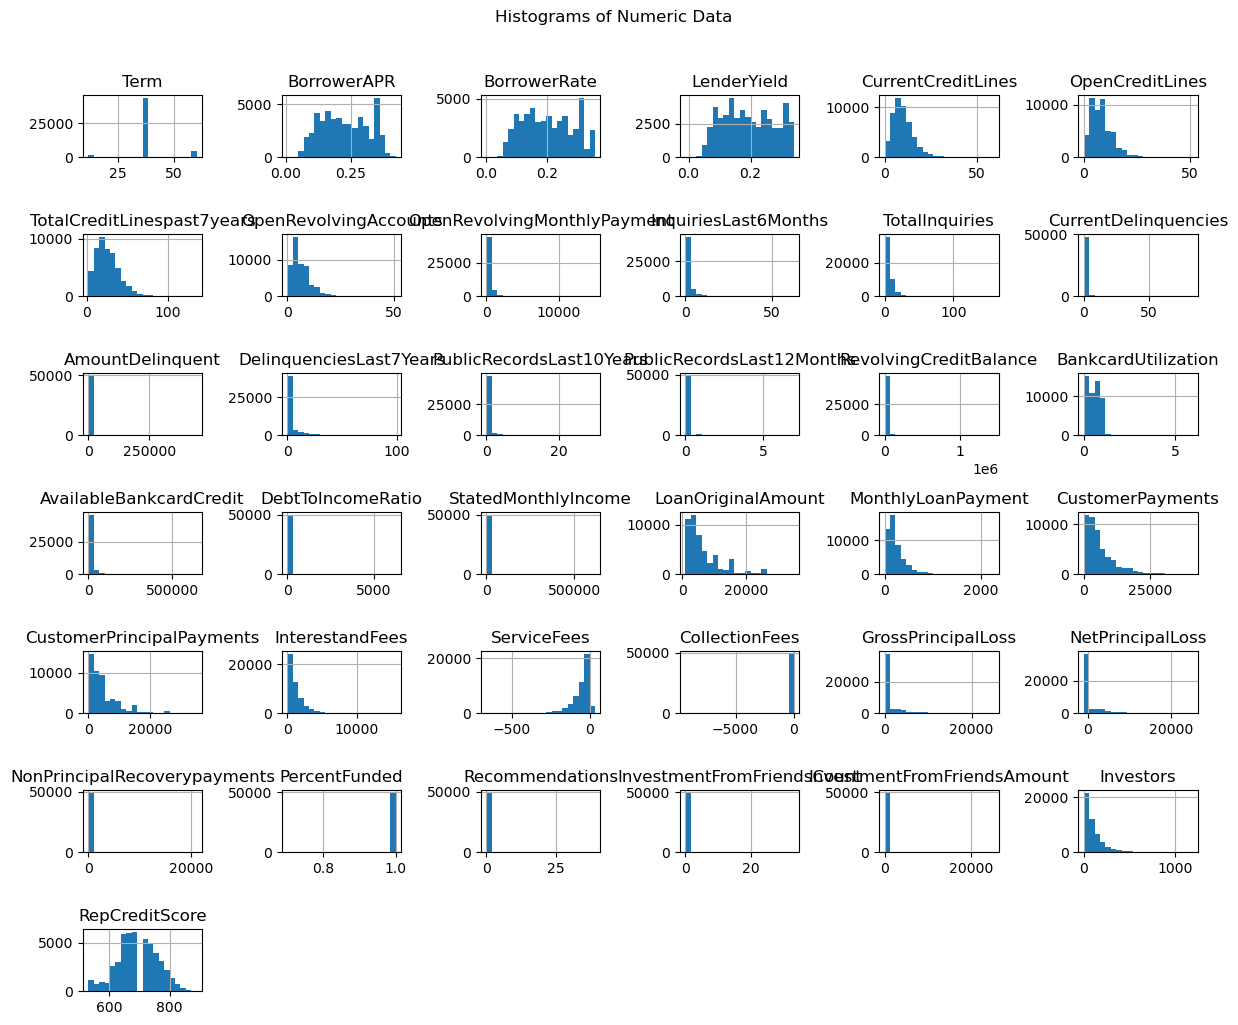

In [86]:
# Assuming 'numeric' is your DataFrame with numeric columns
numeric.hist(figsize=(12, 10), bins=20)
plt.suptitle("Histograms of Numeric Data", y=1.02)  # Add a title above the subplots
plt.tight_layout()
plt.show()

In [87]:
# Categorical
cat = df_sorted.select_dtypes(include=['object', 'category'])
cat.head()

ListingCategory EmploymentStatus     IncomeRange     LoanStatus
0       Not Available    Self-employed  $25,000-49,999      Completed
1       Not Available        Full-time       $1-24,999      Completed
2  Debt Consolidation        Full-time  $25,000-49,999  Not Completed
3            Personal            Other  $50,000-74,999  Not Completed
4       Not Available        Full-time  $25,000-49,999      Completed

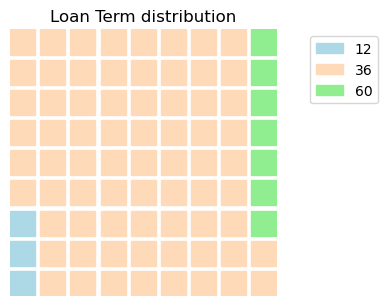

In [88]:
data = {'12': numeric[numeric['Term'] == 12].count()['Term'], 
        '36': numeric[numeric['Term'] == 36].count()['Term'], '60': numeric[numeric['Term'] == 60].count()['Term']}
fig = plt.figure(
    FigureClass=Waffle, 
    rows=9, 
    columns=9, 
    values=data,
    figsize=(4, 4),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)},
    colors=("lightblue", "peachpuff", "lightgreen")
)
plt.title('Loan Term distribution')
plt.show()

- Most of the loans is for 36 months.

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


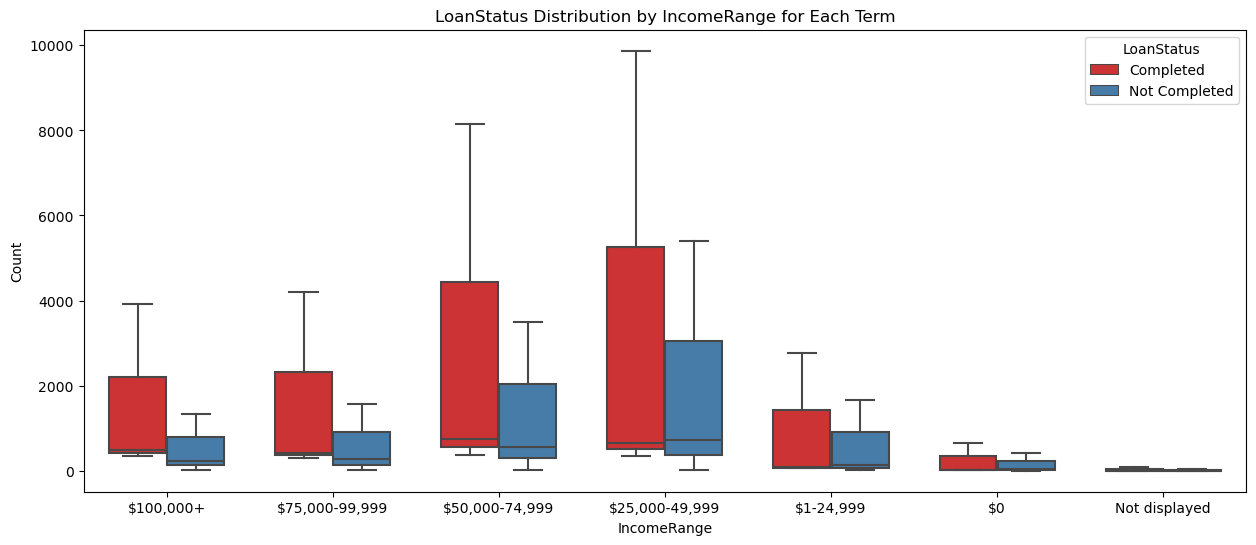

In [89]:
# Count the occurrences of each combination of 'IncomeRange', 'LoanStatus', and 'Term'
count_df = df_sorted.groupby(['IncomeRange', 'LoanStatus', 'Term']).size().reset_index(name='Count')

# Create box plots for each term
plt.figure(figsize=(15, 6))
sb.boxplot(x='IncomeRange', y='Count', hue='LoanStatus', data=count_df, palette='Set1', width=0.7, fliersize=0)
plt.title('LoanStatus Distribution by IncomeRange for Each Term')
plt.xlabel('IncomeRange')
plt.ylabel('Count')
plt.legend(title='LoanStatus')
plt.show()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


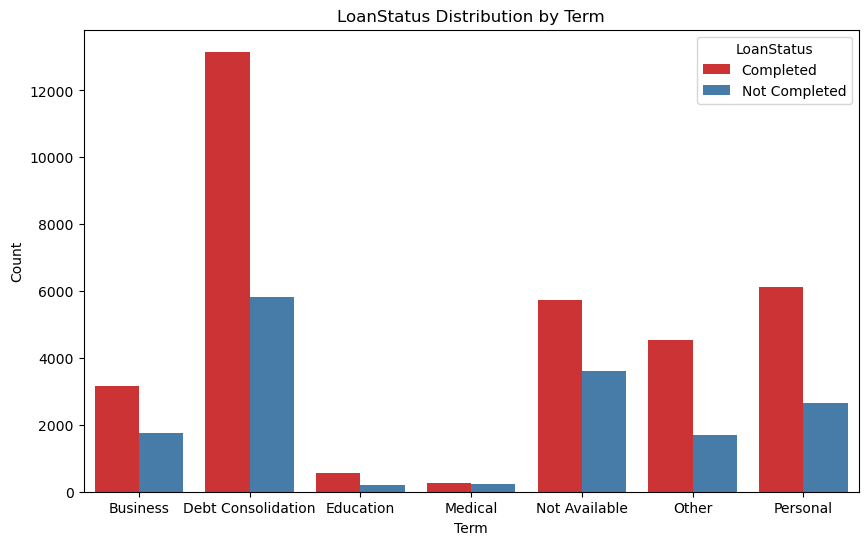

In [90]:
# Count the occurrences of each combination of 'LoanStatus' and 'Term'
count_df = df_sorted.groupby(['LoanStatus', 'ListingCategory']).size().reset_index(name='Count')

# Plotting the bar plot
plt.figure(figsize=(10, 6))
sb.barplot(x='ListingCategory', y='Count', hue='LoanStatus', data=count_df, palette='Set1')
plt.title('LoanStatus Distribution by Term')
plt.xlabel('Term')
plt.ylabel('Count')
plt.show()

In [91]:
df_sorted.columns

Index(['Term', 'BorrowerAPR', 'BorrowerRate', 'LenderYield', 'ListingCategory',
       'EmploymentStatus', 'IsBorrowerHomeowner', 'CurrentCreditLines',
       'OpenCreditLines', 'TotalCreditLinespast7years',
       'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment',
       'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies',
       'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'AvailableBankcardCredit', 'DebtToIncomeRatio', 'IncomeRange',
       'IncomeVerifiable', 'StatedMonthlyIncome', 'LoanOriginalAmount',
       'MonthlyLoanPayment', 'CustomerPayments', 'CustomerPrincipalPayments',
       'InterestandFees', 'ServiceFees', 'CollectionFees',
       'GrossPrincipalLoss', 'NetPrincipalLoss',
       'NonPrincipalRecoverypayments', 'PercentFunded', 'Recommendations',
       'InvestmentFromFriendsCount', 'InvestmentFromFriendsAmount',
       'Inv

# Outlier Detection
- Interquartile Range
- Grubbs Test

### Interquartile Range

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categ

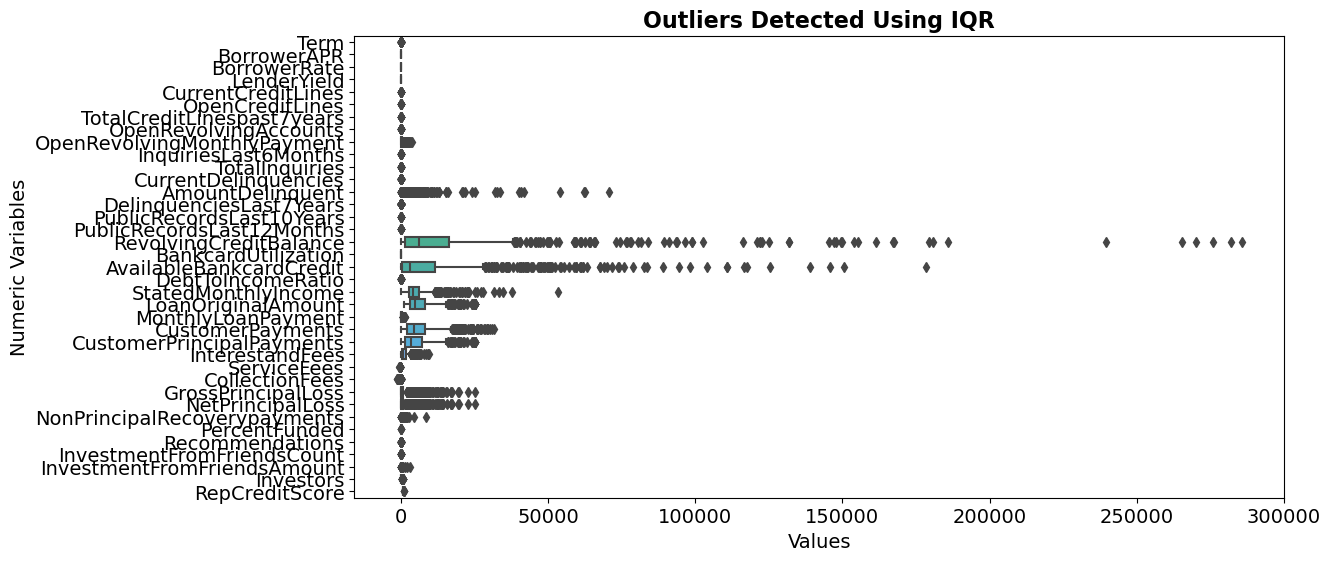

In [92]:
# Take a sample of the data
sample_size = 1000
df_sample = df_sorted.sample(sample_size, random_state=42)

# Calculate IQR for each numeric column
Q1 = df_sample.select_dtypes(include=['int64', 'float64']).quantile(0.25)
Q3 = df_sample.select_dtypes(include=['int64', 'float64']).quantile(0.75)
IQR = Q3 - Q1

# Set lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers using IQR method
outliers_iqr = ((df_sample.select_dtypes(include=['int64', 'float64']) < lower_bound) |
                (df_sample.select_dtypes(include=['int64', 'float64']) > upper_bound))

# Visualize outliers using box plots
plt.figure(figsize=(12, 6))
sb.boxplot(data=df_sample.select_dtypes(include=['int64', 'float64']), orient='h')
plt.xlabel('Values', fontsize=14)
plt.ylabel('Numeric Variables', fontsize=14)

# Increase font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 

plt.title('Outliers Detected Using IQR',fontsize=16, fontweight='bold')

# Save the plot
plt.savefig('IQR.png', dpi=300, bbox_inches='tight')
plt.show()


### Grubbs Test

In [93]:
def find_outliers(selcted_variables):
    outliers = {}
    for column in selcted_variables.columns:
        # Check if the column contains numeric data
        if pd.api.types.is_numeric_dtype(selcted_variables[column]):
            numeric_data = selcted_variables[column].dropna().tolist()

            # Check if there are enough data points for the test
            num_elements = len(numeric_data)
            if num_elements < 3:
                outliers[column] = None  # Not enough data points for the test
                continue

            # Perform Grubbs' test
            z_scores = zscore(numeric_data)
            threshold = t.ppf(1 - 0.05 / (2 * num_elements), num_elements - 2)
            max_z_score = np.max(np.abs(z_scores))

            if max_z_score > threshold:
                # If an outlier is detected, find its index and value
                outlier_index = np.argmax(np.abs(z_scores))
                outlier_value = numeric_data[outlier_index]
                outliers[column] = outlier_value
            else:
                # No outliers detected for this column
                outliers[column] = None
        else:
            # Non-numeric column, ignore it
            outliers[column] = None
    return outliers

# Example usage with a pandas DataFrame named 'data'
# Replace 'data' with your actual DataFrame containing numeric and categorical columns
outliers = find_outliers(df_sorted)

# Print the outliers detected for each numeric column
for column, outlier_value in outliers.items():
    if outlier_value is not None:
        print(f"Grubbs' test detected an outlier in column '{column}': {outlier_value}")
    else:
        print(f"No outliers detected in column '{column}'. ")

No outliers detected in column 'Term'. 
No outliers detected in column 'BorrowerAPR'. 
No outliers detected in column 'BorrowerRate'. 
No outliers detected in column 'LenderYield'. 
No outliers detected in column 'ListingCategory'. 
No outliers detected in column 'EmploymentStatus'. 
No outliers detected in column 'IsBorrowerHomeowner'. 
Grubbs' test detected an outlier in column 'CurrentCreditLines': 59.0
Grubbs' test detected an outlier in column 'OpenCreditLines': 51.0
Grubbs' test detected an outlier in column 'TotalCreditLinespast7years': 136.0
Grubbs' test detected an outlier in column 'OpenRevolvingAccounts': 51
Grubbs' test detected an outlier in column 'OpenRevolvingMonthlyPayment': 14985.0
Grubbs' test detected an outlier in column 'InquiriesLast6Months': 63.0
Grubbs' test detected an outlier in column 'TotalInquiries': 158.0
Grubbs' test detected an outlier in column 'CurrentDelinquencies': 83.0
Grubbs' test detected an outlier in column 'AmountDelinquent': 444745.0
Grubbs' 

Grubbs' test is a statistical hypothesis test that is effective for identifying single outliers in normally distributed data, whereas the IQR method is a rule-based approach suitable for detecting outliers in a wider range of data distributions and can identify both single and multiple outliers. The choice between these methods depends on the characteristics of your data and the goals of your analysis.

# Correlation Test 
- Pearson Correlation

In [94]:
# Calculate Pearson correlation
pearson_corr = numeric.corr()

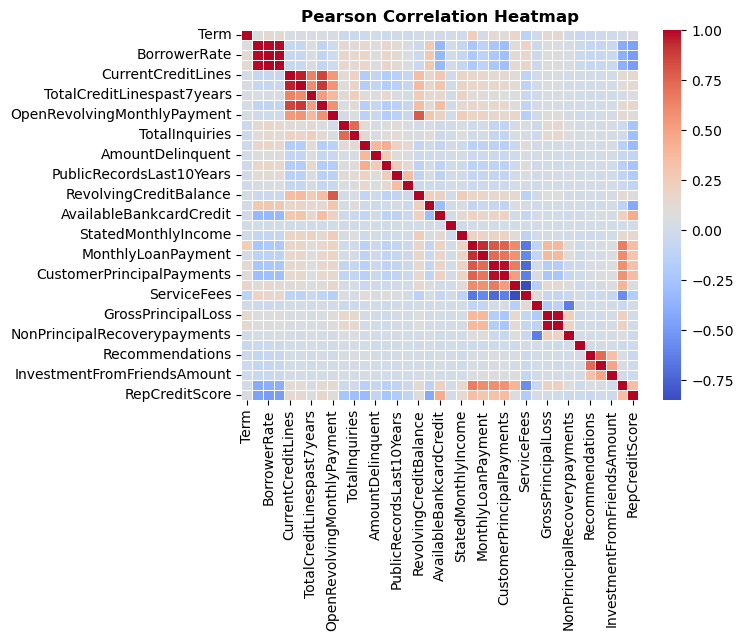

In [95]:
# Heatmap for Pearson correlation
sb.heatmap(pearson_corr, cmap='coolwarm', linewidths=0.5)

# title
plt.title("Pearson Correlation Heatmap", fontsize=12, fontweight='bold')

# Save the plot after displaying it
plt.savefig('corr.png', dpi=300, bbox_inches='tight')
# display plot
plt.show()



Multicollinearity:
High correlations between predictor variables can lead to multicollinearity, making it challenging to isolate the individual effect of each variable. Consider removing one of the highly correlated variables to address multicollinearity issues.

In [96]:
# Calculate the absolute correlation matrix for numeric variables
cr = numeric.corr().abs()

'''Select only elements with Pearson correlation greater than 0.7, 
Unstack and transpose the selected correlation matrix and Sort values in descending order and drop duplicates'''

cr[pearson_corr>0.7].unstack().transpose().sort_values(ascending=False).drop_duplicates()

Term                       Term                           1.000000
BorrowerRate               LenderYield                    0.999211
NetPrincipalLoss           GrossPrincipalLoss             0.991934
BorrowerAPR                BorrowerRate                   0.989287
                           LenderYield                    0.989194
CustomerPayments           CustomerPrincipalPayments      0.983286
CurrentCreditLines         OpenCreditLines                0.955025
LoanOriginalAmount         MonthlyLoanPayment             0.923010
OpenRevolvingAccounts      OpenCreditLines                0.895139
                           CurrentCreditLines             0.858392
CustomerPayments           LoanOriginalAmount             0.791407
RevolvingCreditBalance     OpenRevolvingMonthlyPayment    0.785819
CustomerPrincipalPayments  LoanOriginalAmount             0.758661
TotalInquiries             InquiriesLast6Months           0.738806
Recommendations            InvestmentFromFriendsCount     0.73

In [97]:
# drop highly correlated variables
df_sorted.drop(columns=['BorrowerAPR','LenderYield','NetPrincipalLoss',
                        'CustomerPrincipalPayments','OpenCreditLines', 
                        'CurrentCreditLines', 'RevolvingCreditBalance',
                        'OpenRevolvingAccounts', 'LoanOriginalAmount',
                        'OpenRevolvingMonthlyPayment', 'CustomerPayments',
                       'TotalCreditLinespast7years', 'InquiriesLast6Months', 
                        'InvestmentFromFriendsCount'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [98]:
# Numerical
numeric = df_sorted.select_dtypes(include='number')

### Check

In [99]:
cr = numeric.corr().abs()
cr[pearson_corr>0.7].unstack().transpose().sort_values(ascending=False).drop_duplicates()

Term  Term            1.0
      BorrowerRate    NaN
dtype: float64

# Feature Engineering
### Data Transformation

In [100]:
# create a copy for feature engineering
df_features = df_sorted.copy()

#### Label Encoding for the Target Variable (Loan Status)

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


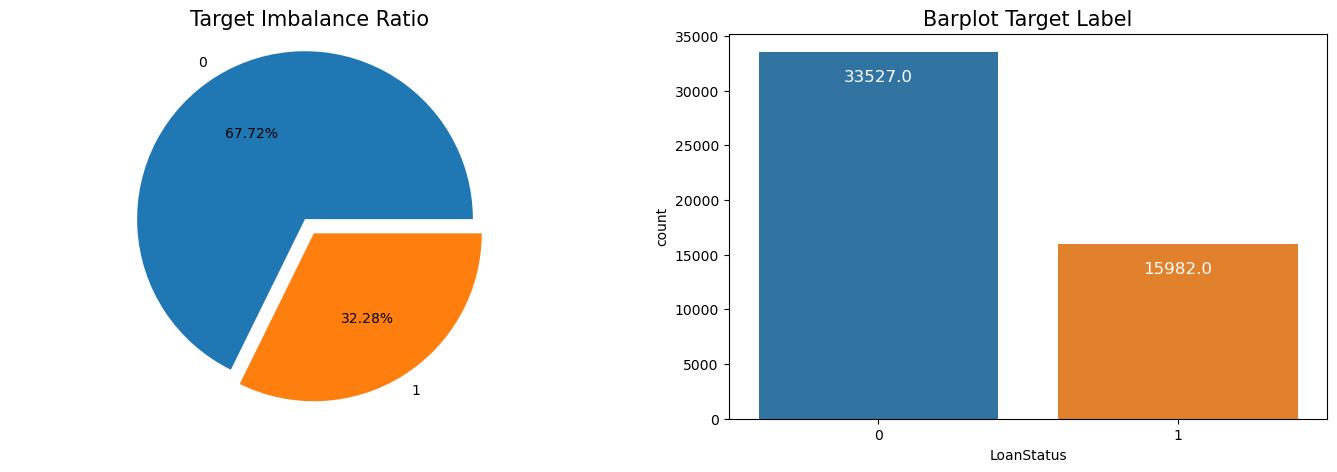

In [101]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'LoanStatus' column
df_features['LoanStatus'] = label_encoder.fit_transform(df_features['LoanStatus'])

plt.figure(figsize=(17,(100)/20))

plt.subplot(121)
plt.pie(round(df_features['LoanStatus'].value_counts()/len(df_features)*100,2),labels=list(df_features['LoanStatus'].value_counts().index),autopct = "%.2f%%",explode = (0,0.1))
plt.axis("equal")
plt.title("Target Imbalance Ratio",size=15)

plt.subplot(122)
ax = sb.countplot(data=df_features, x='LoanStatus')
plt.title("Barplot Target Label", fontsize=15)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=12)

In [102]:
df_sorted.LoanStatus.value_counts()

LoanStatus
Completed        33527
Not Completed    15982
Name: count, dtype: int64

In [103]:
loan_status = df_features['LoanStatus']
loan_status.value_counts()

LoanStatus
0    33527
1    15982
Name: count, dtype: int64

#### Onehot coding for categorical variables

In [104]:
categorical_columns = ['ListingCategory','EmploymentStatus', 'IsBorrowerHomeowner','IncomeRange','IncomeVerifiable']

# Step 1: Create dummy variables for categorical columns
data_with_dummies = pd.get_dummies(df_features, columns=categorical_columns, drop_first=True)

# 'drop_first=True' drops the first category in each categorical variable to avoid multicollinearity

# Display the DataFrame with dummy variables
print(data_with_dummies)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [105]:
data_with_dummies.columns

Index(['Term', 'BorrowerRate', 'TotalInquiries', 'CurrentDelinquencies',
       'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'BankcardUtilization', 'AvailableBankcardCredit', 'DebtToIncomeRatio',
       'StatedMonthlyIncome', 'MonthlyLoanPayment', 'InterestandFees',
       'ServiceFees', 'CollectionFees', 'GrossPrincipalLoss',
       'NonPrincipalRecoverypayments', 'PercentFunded', 'Recommendations',
       'InvestmentFromFriendsAmount', 'Investors', 'RepCreditScore',
       'LoanStatus', 'ListingCategory_Debt Consolidation',
       'ListingCategory_Education', 'ListingCategory_Medical',
       'ListingCategory_Not Available', 'ListingCategory_Other',
       'ListingCategory_Personal', 'EmploymentStatus_Not employed',
       'EmploymentStatus_Other', 'EmploymentStatus_Part-time',
       'EmploymentStatus_Retired', 'EmploymentStatus_Self-employed',
       'IsBorrowerHomeowner_True', 'IncomeRange_$75,000-99,999',
  

In [106]:
# experiment data shape
data_with_dummies.shape

(49509, 43)

### Split Dataset

In [107]:
# Extracting features (independent variables) from the dataset by excluding the target variable "LoanStatus"
X = data_with_dummies.drop("LoanStatus", axis=1)

# Extracting the target variable "LoanStatus" for the machine learning task
y = data_with_dummies["LoanStatus"]


# Split the data into training (80%) and the rest (20%).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [108]:
# Split the data into training (80%) and the rest (20%).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [109]:
# check if the stratified sampling method works by calculating the percentage of the charged off class
print('Percentage of Charged off label in y_train: ', round(sum(y_train)/len(y_train)*100, 2), '%')

Percentage of Charged off label in y_train:  32.28 %


In [110]:
# Size of data samples
print('Independent training size (X_train):', X_train.shape)
print('Dependent training size (y_train):', y_train.shape)
print('Independent testing size (X_test):', X_test.shape)
print('Dependent testing size (y_train):', y_test.shape)

Independent training size (X_train): (39607, 42)
Dependent training size (y_train): (39607,)
Independent testing size (X_test): (9902, 42)
Dependent testing size (y_train): (9902,)


# Experiments
- experiments with imbalanced data
- experiments with balanced data ( OverSampling with SMOTE)
- experiments with balanced data ( UnderSampling with RandomUnderSampler)
- experiments with normalized data ( MinMaxScalar)
- experiments summary
- cross validation
- hyperparameter tuning with RandomizedCV


#### Baseline model
- Decision Trees
#### Bagging Models
- Random forest
- Bagging estimator with decision trees
#### Boosting Models
- Extreme gradient boosting (XGB)
- Adaptive Boosting (Adaboost)



### Define a Function for Classification

In [111]:
# create a DataFrame to store the model evaluations
model_evaluations_df = pd.DataFrame(columns=['Model', 'Accuracy Score', 'Precision Score',
                                             'Recall Score', 'AUC Score'])

def evaluate_model(X_train, y_train, X_test, y_test, model, model_name):
    
    # Train the provided model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Evaluate the model
    accuracy = round(accuracy_score(y_test, predictions), 2)
    precision = round(precision_score(y_test, predictions), 2)
    recall = round(recall_score(y_test, predictions), 2)
    auc = round(roc_auc_score(y_test, predictions), 2)
    
    # Print and return evaluation metrics
    print("Model Evaluation", model_name)

    evaluation_dict = {
        'Model': model_name,
        'Accuracy Score': accuracy,
        'Precision Score': precision,
        'Recall Score': recall,
        'AUC Score': auc
    }
    
    # Print Classification Report
    print("\nClassification Report")
    print(classification_report(y_test, predictions))
    

    # Plot Confusion Matrix
    # Generate Confusion Matrices
    conf_matrix_test = confusion_matrix(y_test, predictions)
    # Plot Subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
    # Subplot for Confusion Matrix
    disp_test = ConfusionMatrixDisplay(conf_matrix_test, display_labels=['Completed','Charged Off'])
    disp_test.plot(cmap='Blues', values_format='d', ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    
    # Plot roc-auc Curve
    # Get predicted probabilities for the positive class
    y_scores_test = model.predict_proba(X_test)[:, 1]
    
    # Calculate the ROC curve
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_scores_test)
    
     # Calculate the area under the ROC curve (AUC)
    roc_auc_test = roc_auc_score(y_test, y_scores_test)
    
    # Subplot for ROC curve
    axes[1].plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'AUC = {roc_auc_test:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve')
    axes[1].legend(loc='lower right')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()
    
    return evaluation_dict





### Baseline Model ( Decision Trees)

Model Evaluation Imbalanced and Non Scaled Decision Trees (Baseline Model)

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      6706
           1       0.90      0.93      0.91      3196

    accuracy                           0.94      9902
   macro avg       0.93      0.94      0.94      9902
weighted avg       0.94      0.94      0.94      9902



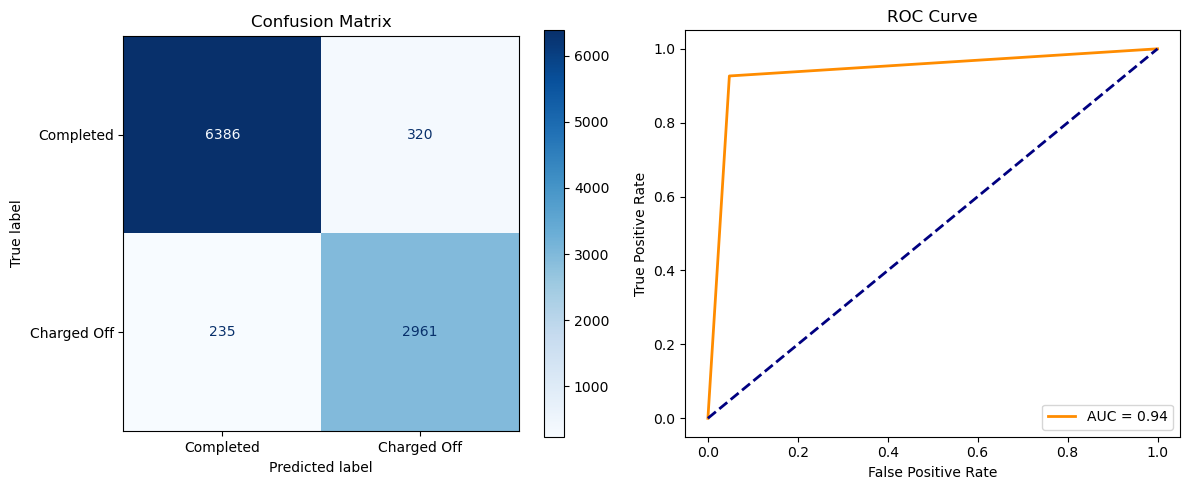

{'Model': 'Imbalanced and Non Scaled Decision Trees (Baseline Model)',
 'Accuracy Score': 0.94,
 'Precision Score': 0.9,
 'Recall Score': 0.93,
 'AUC Score': 0.94}

In [112]:
# Instantiate a Decision Tree classifier with a specified random state
ns_dt_model = DecisionTreeClassifier(random_state=42)

# Evaluate the Decision Tree model on the test set and storing the results
evaluation_ns_dt_model = evaluate_model(X_train, y_train, X_test, y_test, ns_dt_model,
                                        "Imbalanced and Non Scaled Decision Trees (Baseline Model)")

# Display the evaluation results
evaluation_ns_dt_model


### Imbalanced and Non Scaled Bagging Models
#### Imbalanced and Non Scaled Random Forest

Model Evaluation Imbalanced and Non Scaled Random Forest

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6706
           1       0.99      0.92      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



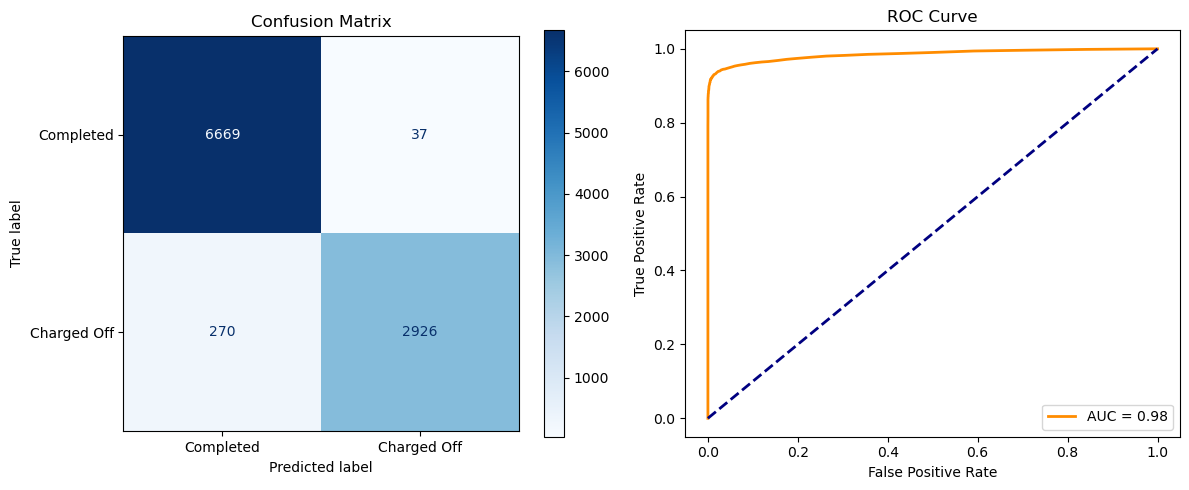

{'Model': 'Imbalanced and Non Scaled Random Forest',
 'Accuracy Score': 0.97,
 'Precision Score': 0.99,
 'Recall Score': 0.92,
 'AUC Score': 0.96}

In [113]:
ns_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluation_ns_rf_model = evaluate_model(X_train, y_train, X_test, y_test, ns_rf_model, 'Imbalanced and Non Scaled Random Forest')
evaluation_ns_rf_model

#### Imbalanced and Non Scaled Bagging Meta-Estimator (using Decision Trees)

Model Evaluation Imbalanced and Non Scaled Bagging Decision Trees

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6706
           1       0.98      0.92      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



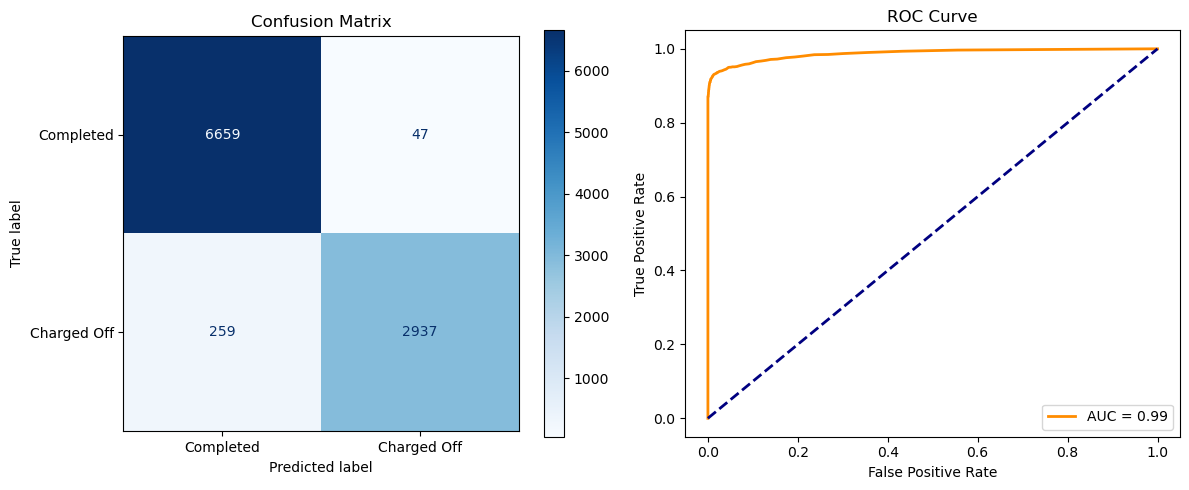

{'Model': 'Imbalanced and Non Scaled Bagging Decision Trees',
 'Accuracy Score': 0.97,
 'Precision Score': 0.98,
 'Recall Score': 0.92,
 'AUC Score': 0.96}

In [114]:
ns_bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
evaluation_ns_bagging_model = evaluate_model(X_train, y_train, X_test, y_test, ns_bagging_model, 'Imbalanced and Non Scaled Bagging Decision Trees')
evaluation_ns_bagging_model

### Imbalanced and Non Scaled Boosting Models
#### Imbalanced and Non Scaled XGBoost

Model Evaluation Imbalanced and Non Scaled XGBoost

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6706
           1       0.98      0.92      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.97      9902
weighted avg       0.97      0.97      0.97      9902



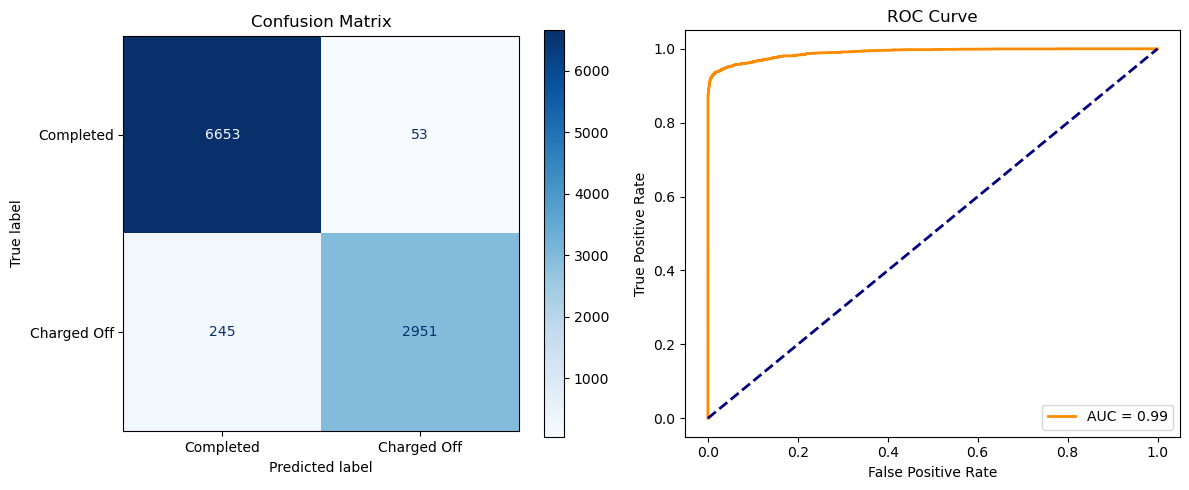

{'Model': 'Imbalanced and Non Scaled XGBoost',
 'Accuracy Score': 0.97,
 'Precision Score': 0.98,
 'Recall Score': 0.92,
 'AUC Score': 0.96}

In [115]:
ns_xgb_model = xgb.XGBClassifier(objective='binary:logistic',n_estimators=100,  gamma=0.1, random_state=42)
evaluation_ns_xgb_model = evaluate_model(X_train, y_train, X_test, y_test, ns_xgb_model, 'Imbalanced and Non Scaled XGBoost')
evaluation_ns_xgb_model

#### Imbalanced and Non Scaled AdaBoost

Model Evaluation Imbalanced and Non Scaled AdaBoost

Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      6706
           1       0.99      0.89      0.94      3196

    accuracy                           0.96      9902
   macro avg       0.97      0.95      0.96      9902
weighted avg       0.97      0.96      0.96      9902



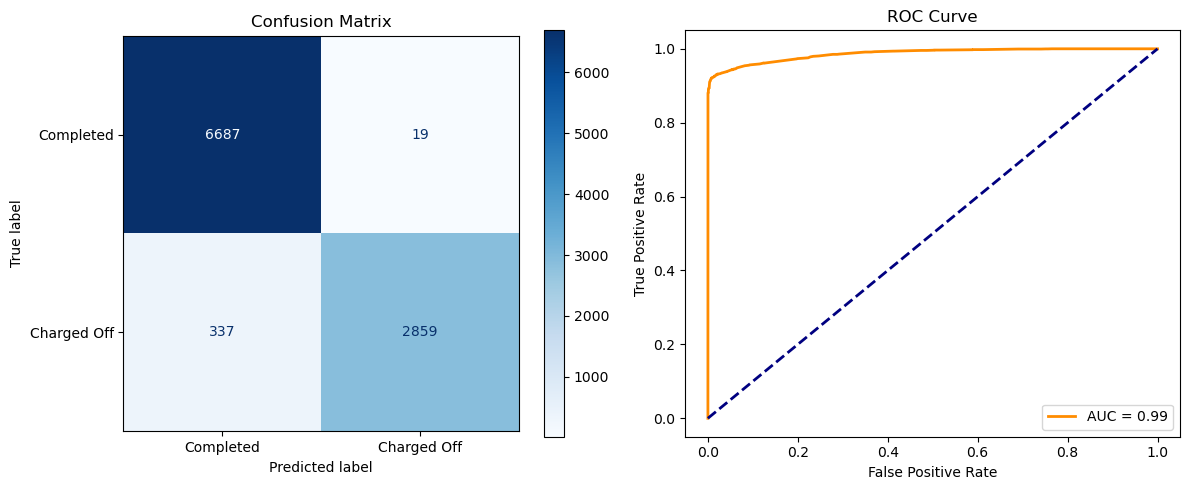

{'Model': 'Imbalanced and Non Scaled AdaBoost',
 'Accuracy Score': 0.96,
 'Precision Score': 0.99,
 'Recall Score': 0.89,
 'AUC Score': 0.95}

In [116]:
ns_ada_model = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
evaluation_ns_ada_model = evaluate_model(X_train, y_train, X_test, y_test, ns_ada_model, 'Imbalanced and Non Scaled AdaBoost')
evaluation_ns_ada_model

## Data Normalization with MinMaxScaler

In [117]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Standardize the features of the training set
X_train_scaled = scaler.fit_transform(X_train)

# Standardize the features of the test set using the scaler fitted on the training set
X_test_scaled = scaler.transform(X_test)

### Imbalanced and Scaled Bagging Models
#### Imbalanced and Scaled Random Forest

Model Evaluation Imbalanced and Scaled Random Forest

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6706
           1       0.99      0.92      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



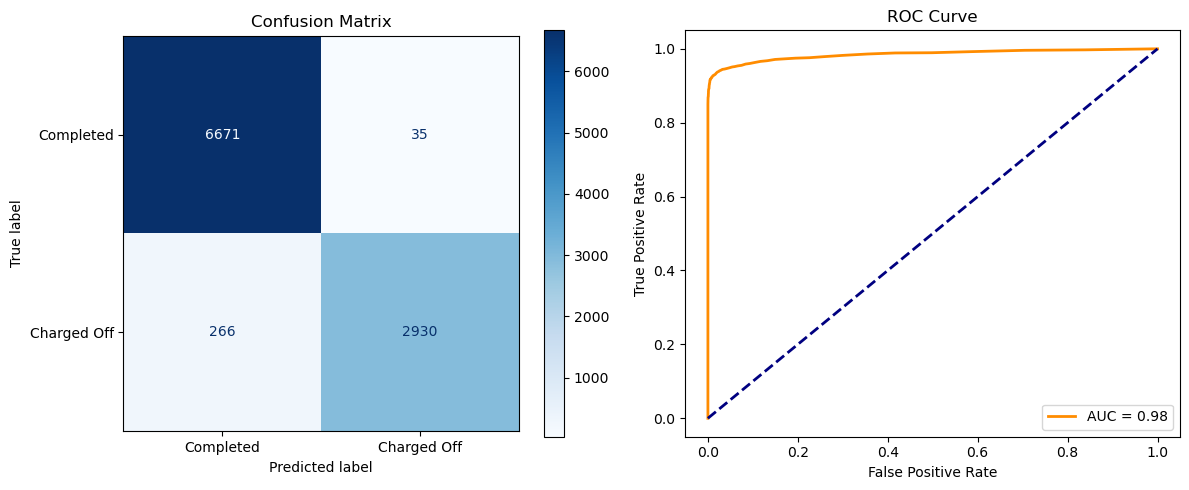

{'Model': 'Imbalanced and Scaled Random Forest',
 'Accuracy Score': 0.97,
 'Precision Score': 0.99,
 'Recall Score': 0.92,
 'AUC Score': 0.96}

In [118]:
is_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluation_is_rf_model = evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, is_rf_model, 'Imbalanced and Scaled Random Forest')
evaluation_is_rf_model

#### Imbalanced and Scaled Bagging Meta-Estimator (using Decision Trees)

Model Evaluation Imbalanced and Scaled Bagging Meta-Estimator

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6706
           1       0.98      0.92      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



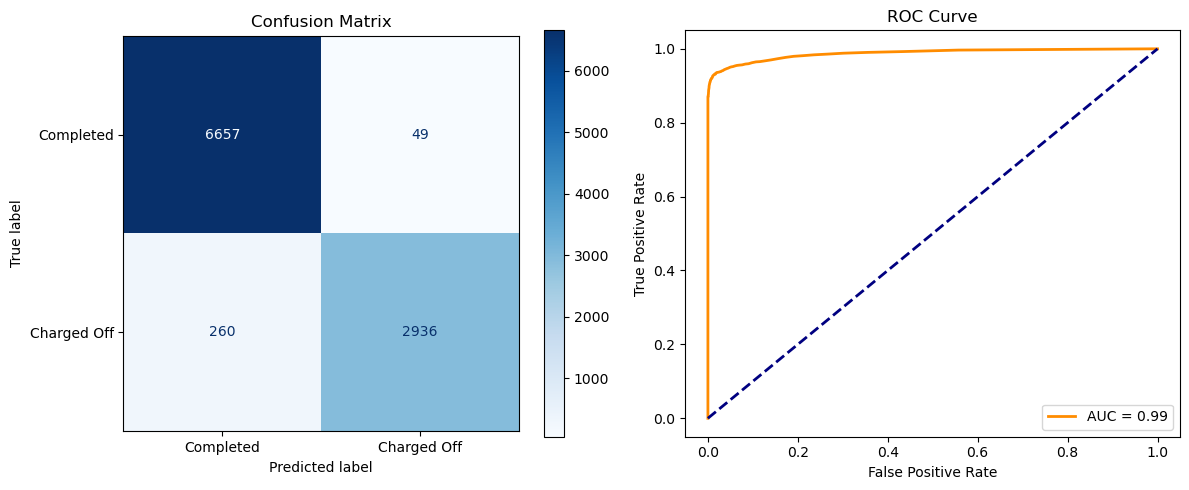

{'Model': 'Imbalanced and Scaled Bagging Meta-Estimator',
 'Accuracy Score': 0.97,
 'Precision Score': 0.98,
 'Recall Score': 0.92,
 'AUC Score': 0.96}

In [119]:
is_bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
evaluation_is_bagging_model = evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, is_bagging_model, 'Imbalanced and Scaled Bagging Meta-Estimator')
evaluation_is_bagging_model

### Imbalanced and Scaled Boosting Models 
#### Imbalanced and Scaled XGBoost

Model Evaluation Imbalanced and Scaled XGBoost

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6706
           1       0.98      0.92      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.97      9902
weighted avg       0.97      0.97      0.97      9902



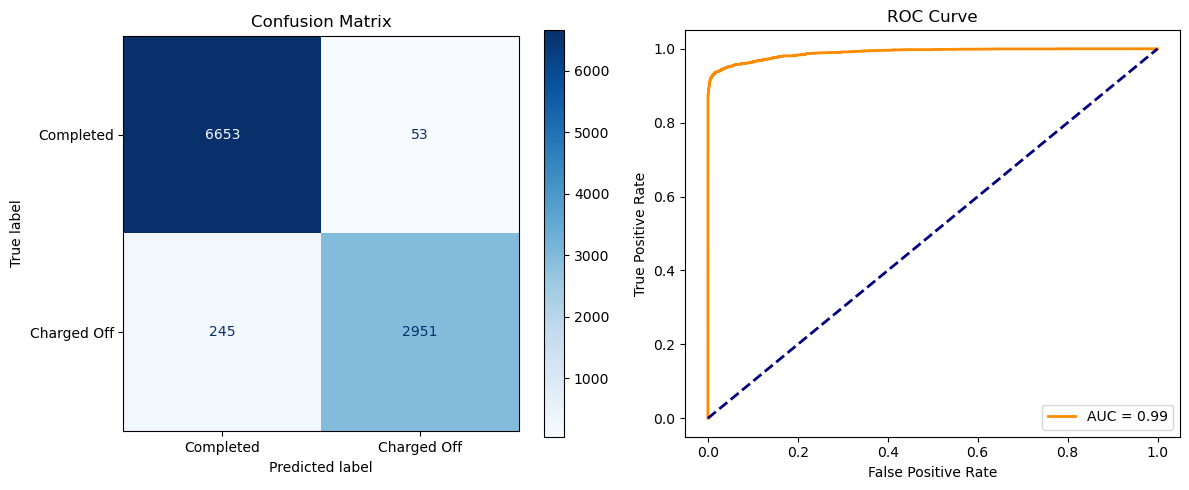

{'Model': 'Imbalanced and Scaled XGBoost',
 'Accuracy Score': 0.97,
 'Precision Score': 0.98,
 'Recall Score': 0.92,
 'AUC Score': 0.96}

In [120]:
is_xgb_model = xgb.XGBClassifier(objective='binary:logistic',n_estimators=100,  gamma=0.1, random_state=42)
evaluation_is_xgb_model = evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, is_xgb_model, 'Imbalanced and Scaled XGBoost')
evaluation_is_xgb_model

#### Imbalanced and Scaled AdaBoost

Model Evaluation Imbalanced and Scaled AdaBoost

Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      6706
           1       0.99      0.89      0.94      3196

    accuracy                           0.96      9902
   macro avg       0.97      0.95      0.96      9902
weighted avg       0.97      0.96      0.96      9902



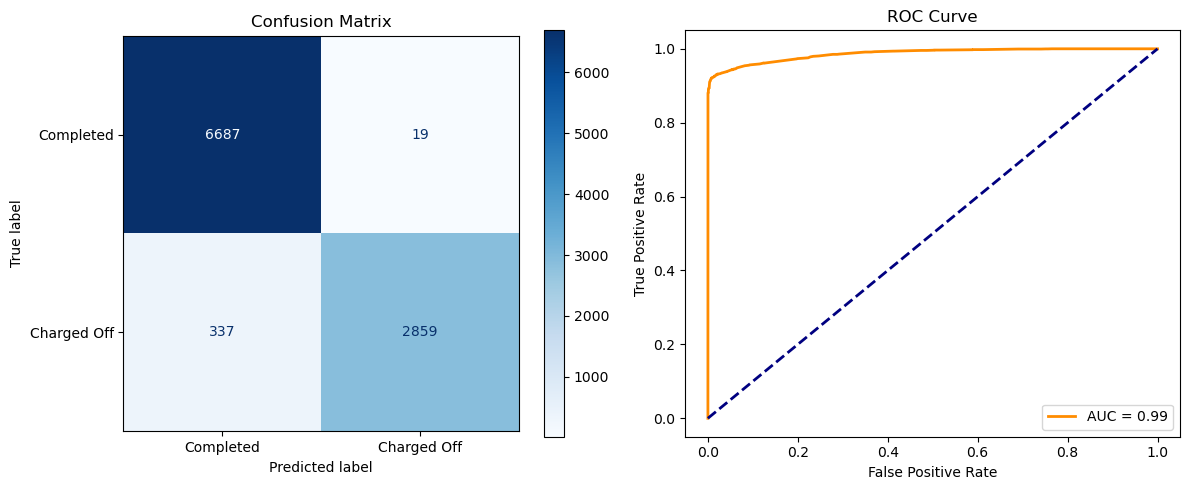

{'Model': 'Imbalanced and Scaled AdaBoost',
 'Accuracy Score': 0.96,
 'Precision Score': 0.99,
 'Recall Score': 0.89,
 'AUC Score': 0.95}

In [121]:
is_ada_model = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
evaluation_is_ada_model = evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, is_ada_model, 'Imbalanced and Scaled AdaBoost')
evaluation_is_ada_model

## Balance Dataset (Over Sampling)

In [122]:
# Create a SMOTE instance with specified parameters
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Resample the original training set without scaling
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Resample the scaled training set
X_train_scaled_resampled, y_train_scaled_resampled = smote.fit_resample(X_train_scaled, y_train)

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


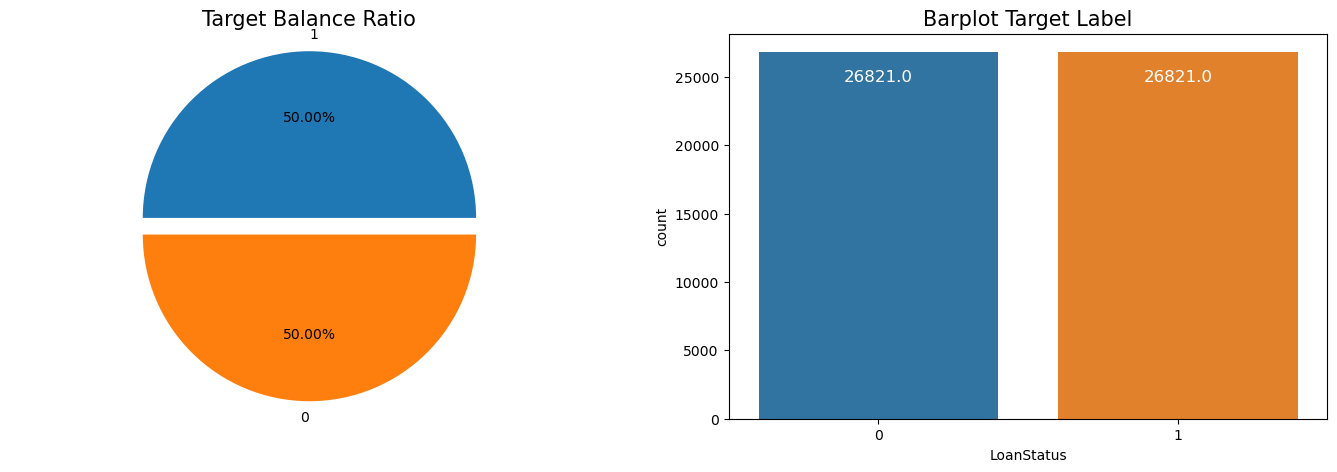

In [123]:
# Convert the NumPy arrays to DataFrames
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X.columns)
y_train_resampled_df = pd.DataFrame(y_train_resampled, columns=['LoanStatus'])

# Create a DataFrame for the balanced dataset
smote_data = pd.concat([X_train_resampled_df, y_train_resampled_df], axis=1)

# Create a figure and subplots
plt.figure(figsize=(17, 5))  # Adjust the figure size as needed

# Plot 1: Pie chart for target imbalance ratio
plt.subplot(121)
plt.pie(round(smote_data['LoanStatus'].value_counts() / len(smote_data) * 100, 2),
        labels=list(smote_data['LoanStatus'].value_counts().index),
        autopct="%.2f%%",
        explode=(0, 0.1))
plt.axis("equal")
plt.title("Target Balance Ratio", size=15)

# Plot 2: Countplot for target label
plt.subplot(122)
ax = sb.countplot(data=smote_data, x='LoanStatus')
plt.title("Barplot Target Label", fontsize=15)

# Annotate the count values on top of the bars
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + 0.4, p.get_height()), ha='center', va='top', color='white', size=12)

plt.show()  # Show the plots

### Balanced and Non Scaled Bagging Models
#### Balanced and Non Scaled Random Forest

Model Evaluation Over Balanced and Non Scaled Random Fores

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6706
           1       0.98      0.92      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



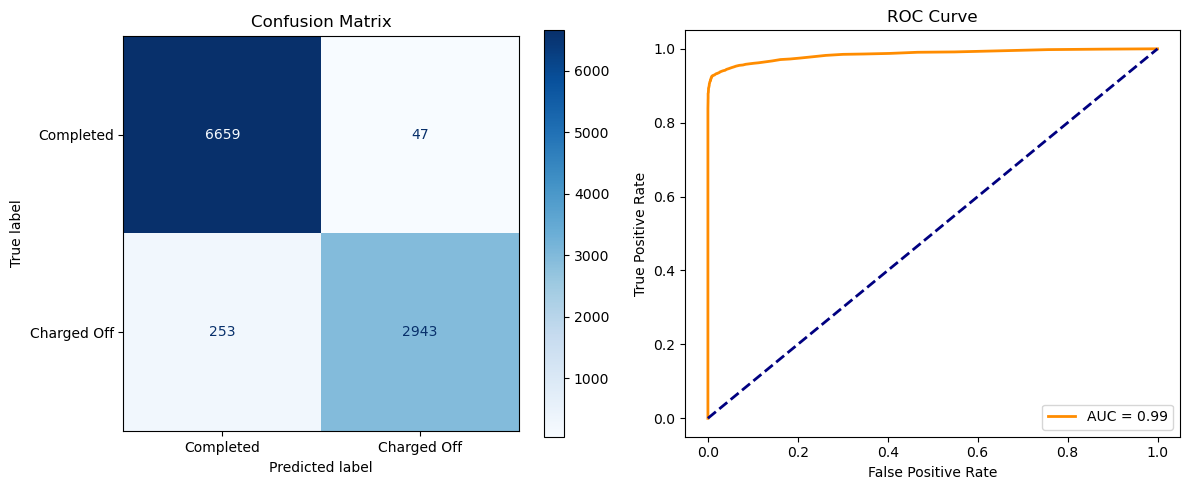

{'Model': 'Over Balanced and Non Scaled Random Fores',
 'Accuracy Score': 0.97,
 'Precision Score': 0.98,
 'Recall Score': 0.92,
 'AUC Score': 0.96}

In [124]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluation_rf_model = evaluate_model(X_train_resampled, y_train_resampled, X_test, y_test, rf_model, 'Over Balanced and Non Scaled Random Fores')
evaluation_rf_model

#### Balanced and Non Scaled Bagging Meta-Estimator (using Decision Trees)

Model Evaluation Over Balanced and Non Scaled Bagging Meta-Estimator

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6706
           1       0.98      0.92      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



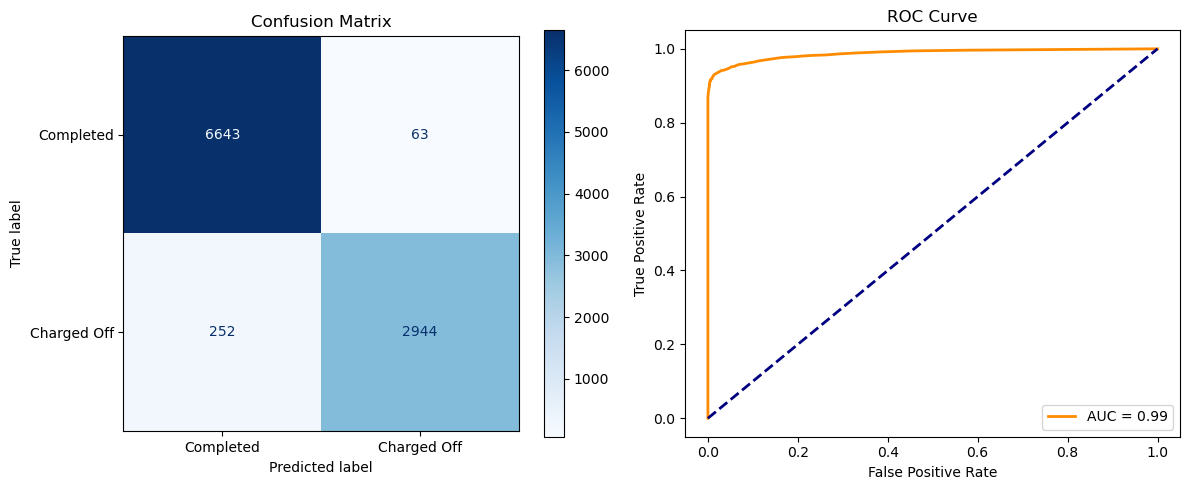

{'Model': 'Over Balanced and Non Scaled Bagging Meta-Estimator',
 'Accuracy Score': 0.97,
 'Precision Score': 0.98,
 'Recall Score': 0.92,
 'AUC Score': 0.96}

In [125]:
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
evaluation_bagging_model = evaluate_model(X_train_resampled, y_train_resampled, X_test, y_test, bagging_model, 'Over Balanced and Non Scaled Bagging Meta-Estimator')
evaluation_bagging_model

### Balanced and Non Scaled Boosting Models
#### Balanced and Non Scaled XGBoost

Model Evaluation Over Balanced and Non Scaled XGBoost

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6706
           1       0.98      0.92      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



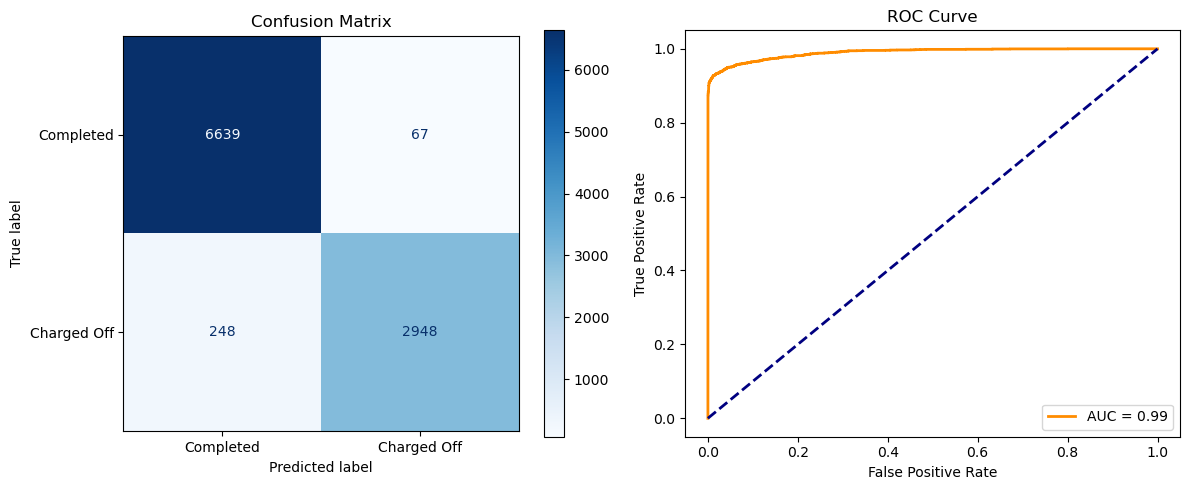

{'Model': 'Over Balanced and Non Scaled XGBoost',
 'Accuracy Score': 0.97,
 'Precision Score': 0.98,
 'Recall Score': 0.92,
 'AUC Score': 0.96}

In [126]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic',n_estimators=100,  gamma=0.1, random_state=42)
evaluation_xgb_model = evaluate_model(X_train_resampled, y_train_resampled, X_test, y_test, xgb_model, 'Over Balanced and Non Scaled XGBoost')
evaluation_xgb_model

#### Balanced and Non Scaled AdaBoost

Model Evaluation Over Balanced and Non Scaled AdaBoost

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6706
           1       0.98      0.92      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



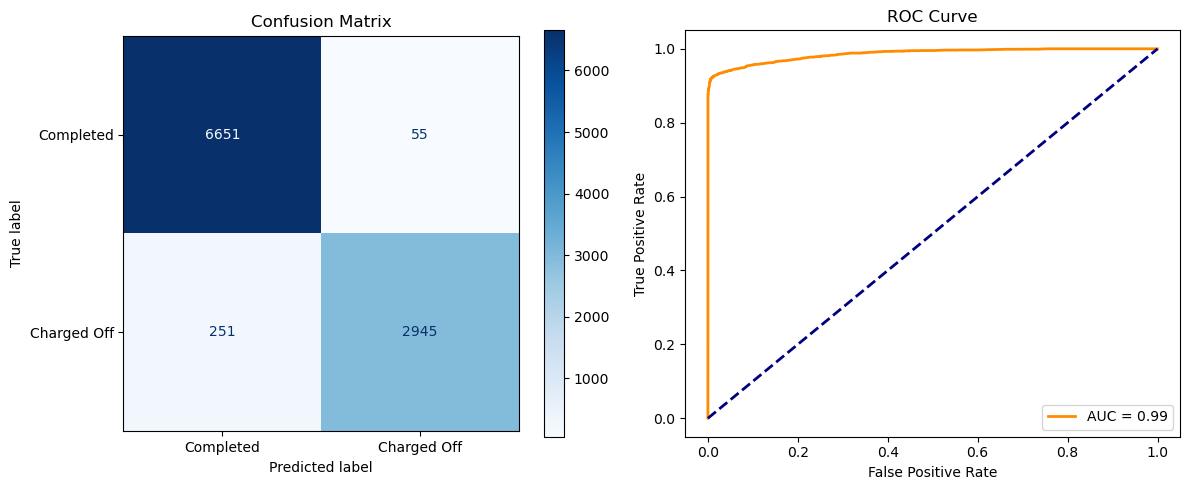

{'Model': 'Over Balanced and Non Scaled AdaBoost',
 'Accuracy Score': 0.97,
 'Precision Score': 0.98,
 'Recall Score': 0.92,
 'AUC Score': 0.96}

In [127]:
ada_model = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
evaluation_ada_model = evaluate_model(X_train_resampled, y_train_resampled, X_test, y_test, ada_model, 'Over Balanced and Non Scaled AdaBoost')
evaluation_ada_model

### Balanced and Scaled Bagging Models
#### Balanced and Scaled Random Forest

Model Evaluation Over Balanced and Scaled Random Forest

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6706
           1       0.98      0.92      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



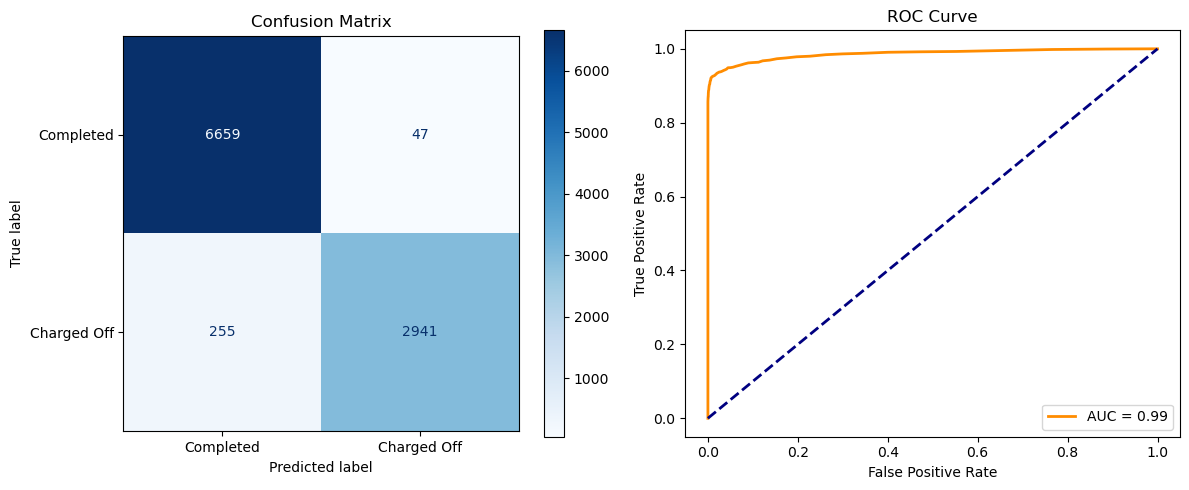

{'Model': 'Over Balanced and Scaled Random Forest',
 'Accuracy Score': 0.97,
 'Precision Score': 0.98,
 'Recall Score': 0.92,
 'AUC Score': 0.96}

In [128]:
bs_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluation_bs_rf_model = evaluate_model(X_train_scaled_resampled, y_train_scaled_resampled, X_test_scaled, y_test, bs_rf_model, 'Over Balanced and Scaled Random Forest')
evaluation_bs_rf_model

#### Balanced and Scaled Bagging Meta-Estimator (using Decision Trees) 

Model Evaluation Over Balanced and Scaled Bagging Meta-Estimator

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6706
           1       0.98      0.92      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



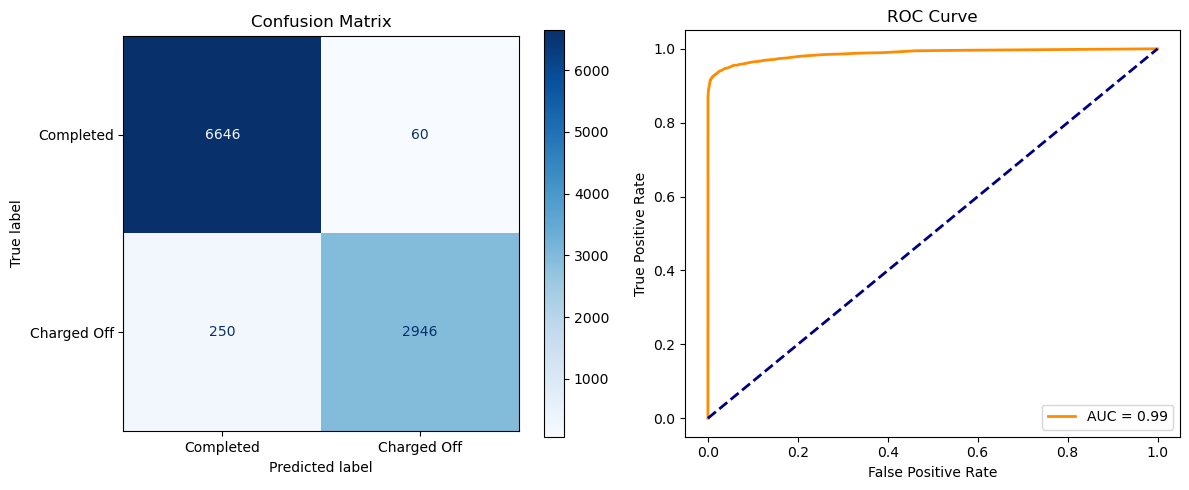

{'Model': 'Over Balanced and Scaled Bagging Meta-Estimator',
 'Accuracy Score': 0.97,
 'Precision Score': 0.98,
 'Recall Score': 0.92,
 'AUC Score': 0.96}

In [129]:
bs_bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
evaluation_bs_bagging_model = evaluate_model(X_train_scaled_resampled, y_train_scaled_resampled, X_test_scaled, y_test, bs_bagging_model, 'Over Balanced and Scaled Bagging Meta-Estimator')
evaluation_bs_bagging_model

### Balanced and Scaled Boosting Models 
#### Balanced and Scaled XGBoost

Model Evaluation Over Balanced and Scaled XGBoost

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6706
           1       0.98      0.92      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



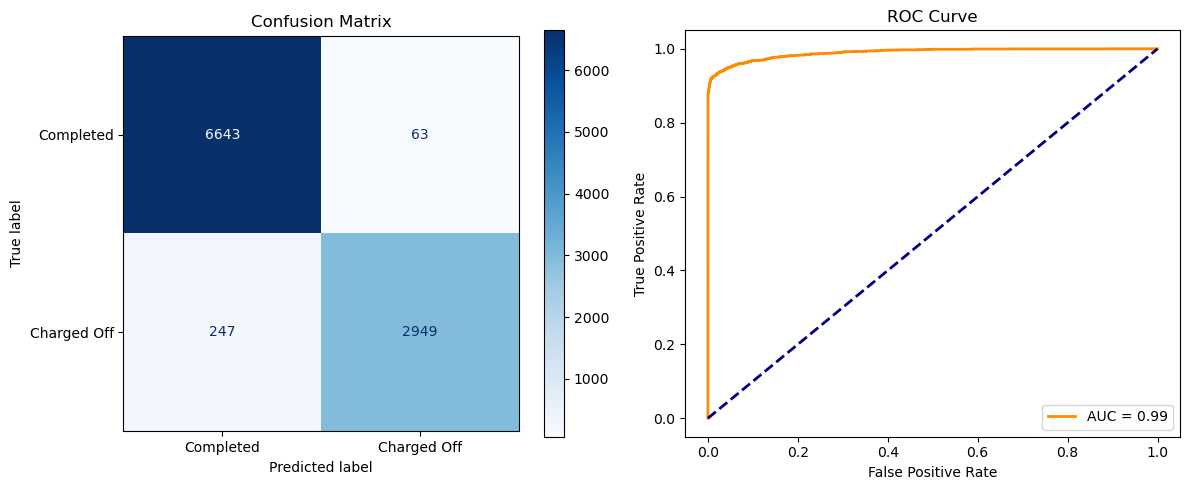

{'Model': 'Over Balanced and Scaled XGBoost',
 'Accuracy Score': 0.97,
 'Precision Score': 0.98,
 'Recall Score': 0.92,
 'AUC Score': 0.96}

In [130]:
bs_xgb_model = xgb.XGBClassifier(objective='binary:logistic',n_estimators=100,  gamma=0.1, random_state=42)
evaluation_bs_xgb_model = evaluate_model(X_train_scaled_resampled, y_train_scaled_resampled, X_test_scaled, y_test, bs_xgb_model, 'Over Balanced and Scaled XGBoost')
evaluation_bs_xgb_model

#### Balanced and Scaled AdaBoost

Model Evaluation Over Balanced and Scaled Gradient AdaBoost

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6706
           1       0.98      0.92      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



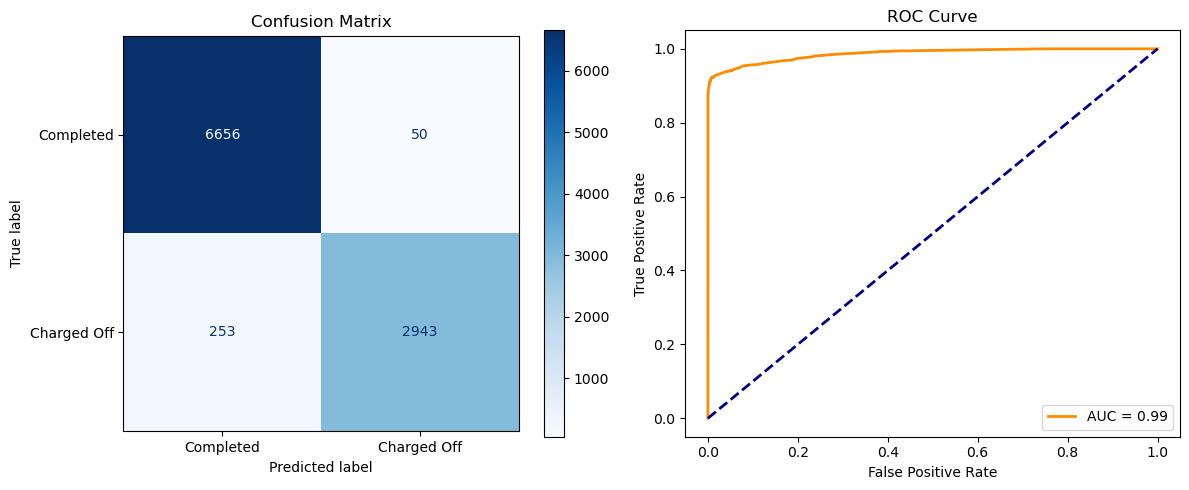

{'Model': 'Over Balanced and Scaled Gradient AdaBoost',
 'Accuracy Score': 0.97,
 'Precision Score': 0.98,
 'Recall Score': 0.92,
 'AUC Score': 0.96}

In [131]:
bs_ada_model = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
evaluation_bs_ada_model = evaluate_model(X_train_scaled_resampled, y_train_scaled_resampled, X_test_scaled, y_test, bs_ada_model, 'Over Balanced and Scaled Gradient AdaBoost')
evaluation_bs_ada_model

## Balanced dataset (UnderSampling)

In [132]:
# Creating a RandomUnderSampler instance with a fixed random state for reproducibility
rus = RandomUnderSampler(random_state=42)

# Performing random under-sampling on the original training data
X_train_under_resampled, y_train_under_resampled = rus.fit_resample(X_train, y_train)

# Performing random under-sampling on the scaled training data
X_train_scaled_under_resampled, y_train_scaled_under_resampled = rus.fit_resample(X_train_scaled, y_train)

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


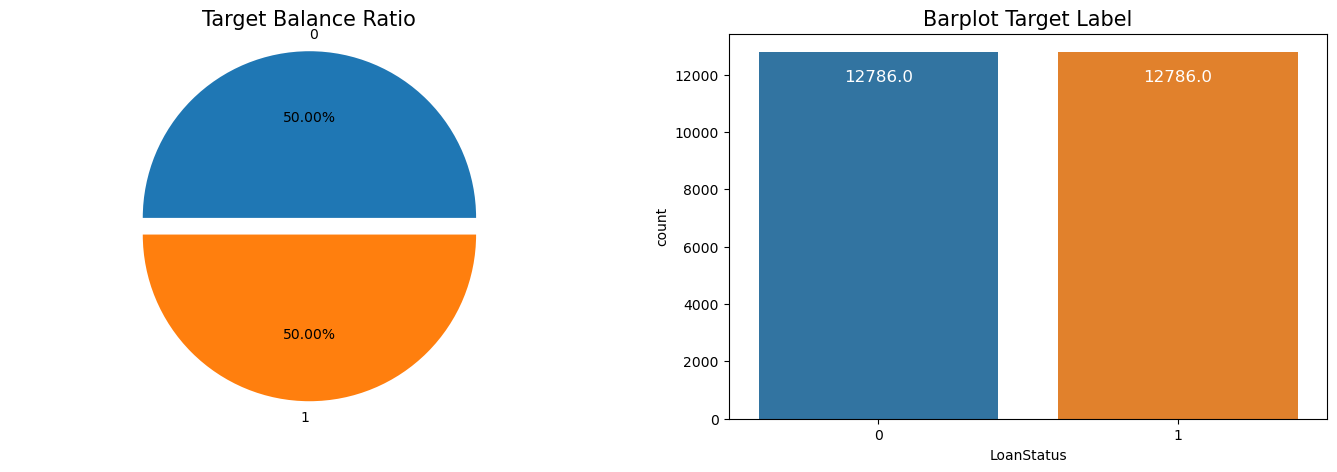

In [133]:
# Convert the NumPy arrays to DataFrames
X_train_under_resampled_df = pd.DataFrame(X_train_under_resampled, columns=X.columns)
y_train_under_resampled_df = pd.DataFrame(y_train_under_resampled, columns=['LoanStatus'])

# Create a DataFrame for the balanced dataset
rus_data = pd.concat([X_train_under_resampled_df, y_train_under_resampled_df], axis=1)

# Create a figure and subplots
plt.figure(figsize=(17, 5))  # Adjust the figure size as needed

# Plot 1: Pie chart for target imbalance ratio
plt.subplot(121)
plt.pie(round(rus_data['LoanStatus'].value_counts() / len(smote_data) * 100, 2),
        labels=list(rus_data['LoanStatus'].value_counts().index),
        autopct="%.2f%%",
        explode=(0, 0.1))
plt.axis("equal")
plt.title("Target Balance Ratio", size=15)

# Plot 2: Countplot for target label
plt.subplot(122)
ax = sb.countplot(data=rus_data, x='LoanStatus')
plt.title("Barplot Target Label", fontsize=15)

# Annotate the count values on top of the bars
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + 0.4, p.get_height()), ha='center', va='top', color='white', size=12)

plt.show()  # Show the plots

In [134]:
# Printing the sizes of data samples

# Independent training size (X_train_under_resampled)
print('Independent training size (X_train_under_resampled):', X_train_under_resampled.shape)

# Dependent training size (y_train_under_resampled)
print('Dependent training size (y_train_under_resampled):', y_train_under_resampled.shape)

# Independent testing size (X_test)
print('Independent testing size (X_test):', X_test.shape)

# Dependent testing size (y_train)
print('Dependent testing size (y_train):', y_test.shape)

Independent training size (X_train_under_resampled): (25572,)
Dependent training size (y_train_under_resampled): (25572,)
Independent testing size (X_test): (9902, 42)
Dependent testing size (y_train): (9902,)


### Under Balanced and Non Scaled Bagging Models
#### Under Balanced and Non Scaled Random Forest

Model Evaluation Under Balanced and Non Scaled Random Forest

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6706
           1       0.97      0.93      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



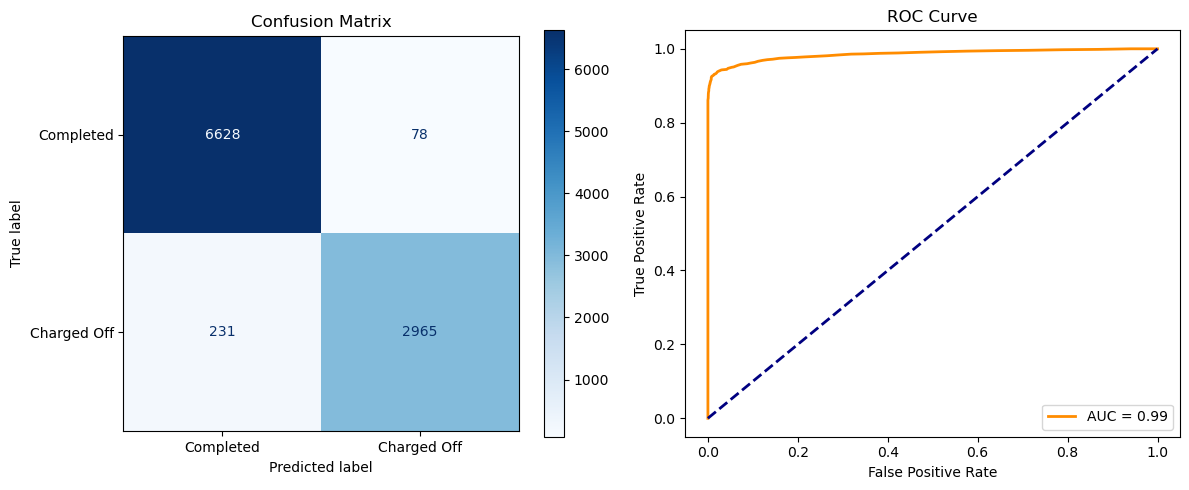

{'Model': 'Under Balanced and Non Scaled Random Forest',
 'Accuracy Score': 0.97,
 'Precision Score': 0.97,
 'Recall Score': 0.93,
 'AUC Score': 0.96}

In [135]:
# Creating a RandomForestClassifier with specified hyperparameters
un_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Evaluating the RandomForestClassifier model on the test set and storing the results
evaluation_un_rf_model = evaluate_model(X_train_under_resampled, 
                                        y_train_under_resampled, X_test, y_test, 
                                        un_rf_model, 
                                        'Under Balanced and Non Scaled Random Forest')

# Displaying the evaluation results
evaluation_un_rf_model


#### Under Balanced and Non Scaled Bagging Meta-Estimator (using Decision Trees)

Model Evaluation Under Balanced and Non Scaled Bagging Meta-Estimator

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6706
           1       0.96      0.93      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



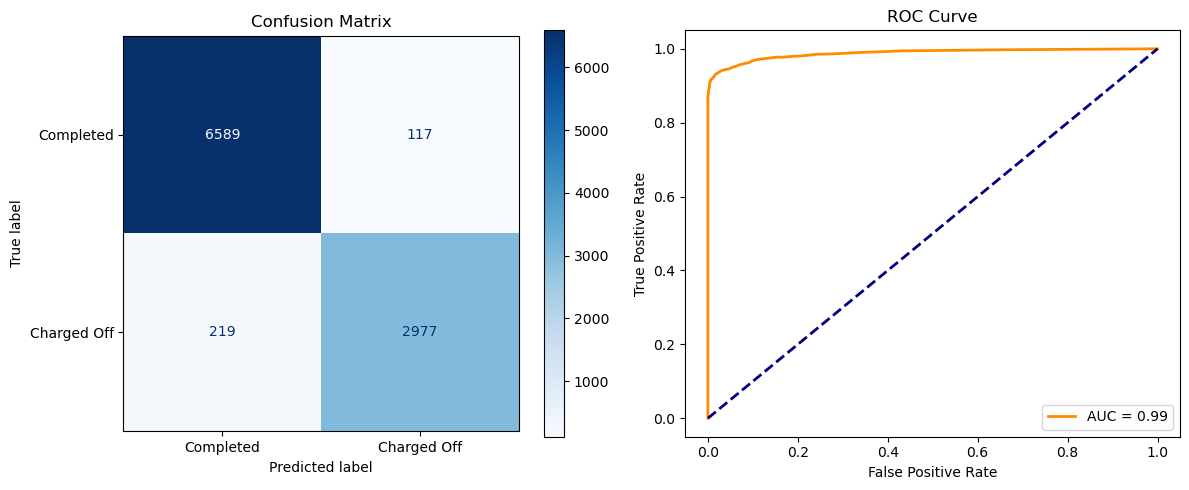

{'Model': 'Under Balanced and Non Scaled Bagging Meta-Estimator',
 'Accuracy Score': 0.97,
 'Precision Score': 0.96,
 'Recall Score': 0.93,
 'AUC Score': 0.96}

In [136]:
# Creating an ensemble model with Bagging Classifier using Decision Tree as the base estimator
un_bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), 
                                     n_estimators=100, random_state=42)

# Evaluating the Bagging Classifier using Decision Trees and storing the results
evaluation_un_bagging_model = evaluate_model(X_train_under_resampled, 
                                             y_train_under_resampled, X_test, y_test, 
                                             un_bagging_model, 
                                             'Under Balanced and Non Scaled Bagging Meta-Estimator')

# Displaying the evaluation results
evaluation_un_bagging_model


### Under Balanced and Non Scaled Boosting Models
#### Under Balanced and Non Scaled XGBoost

Model Evaluation Under Balanced and Non Scaled XGBoost

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      6706
           1       0.95      0.94      0.95      3196

    accuracy                           0.96      9902
   macro avg       0.96      0.96      0.96      9902
weighted avg       0.96      0.96      0.96      9902



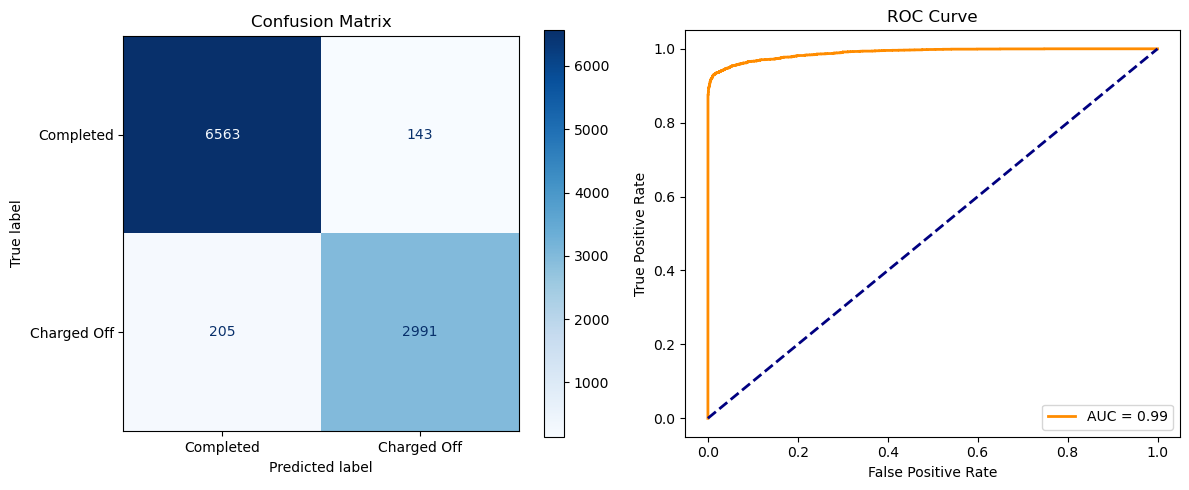

{'Model': 'Under Balanced and Non Scaled XGBoost',
 'Accuracy Score': 0.96,
 'Precision Score': 0.95,
 'Recall Score': 0.94,
 'AUC Score': 0.96}

In [137]:
# Creating an XGBoost classifier with specified hyperparameters
un_xgb_model = xgb.XGBClassifier(objective='binary:logistic', 
                                 n_estimators=100, gamma=0.1, random_state=42)

# Evaluating the XGBoost model on the test set and storing the results
evaluation_un_xgb_model = evaluate_model(X_train_under_resampled, 
                                         y_train_under_resampled, X_test, y_test,
                                         un_xgb_model, 
                                         'Under Balanced and Non Scaled XGBoost')

# Displaying the evaluation results
evaluation_un_xgb_model


#### Under Balanced and Non Scaled AdaBoost

Model Evaluation Under Balanced and Non Scaled AdaBoost

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6706
           1       0.98      0.92      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



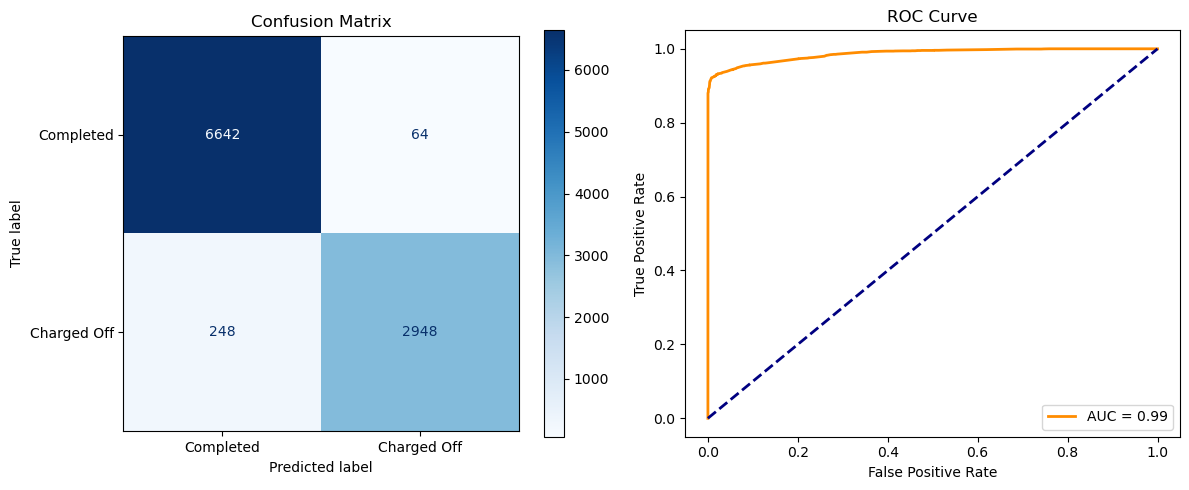

{'Model': 'Under Balanced and Non Scaled AdaBoost',
 'Accuracy Score': 0.97,
 'Precision Score': 0.98,
 'Recall Score': 0.92,
 'AUC Score': 0.96}

In [138]:
# Creating an AdaBoost classifier with specified hyperparameters
un_ada_model = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Evaluating the AdaBoost model on the test set and storing the results
evaluation_un_ada_model = evaluate_model(X_train_under_resampled,
                                         y_train_under_resampled, X_test, 
                                         y_test, un_ada_model, 
                                         'Under Balanced and Non Scaled AdaBoost')

# Displaying the evaluation results
evaluation_un_ada_model


### Under Balanced and Scaled Bagging Models
#### Under Balanced and Scaled Random Forest

Model Evaluation Under Balanced and Scaled Random Forest

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6706
           1       0.98      0.93      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



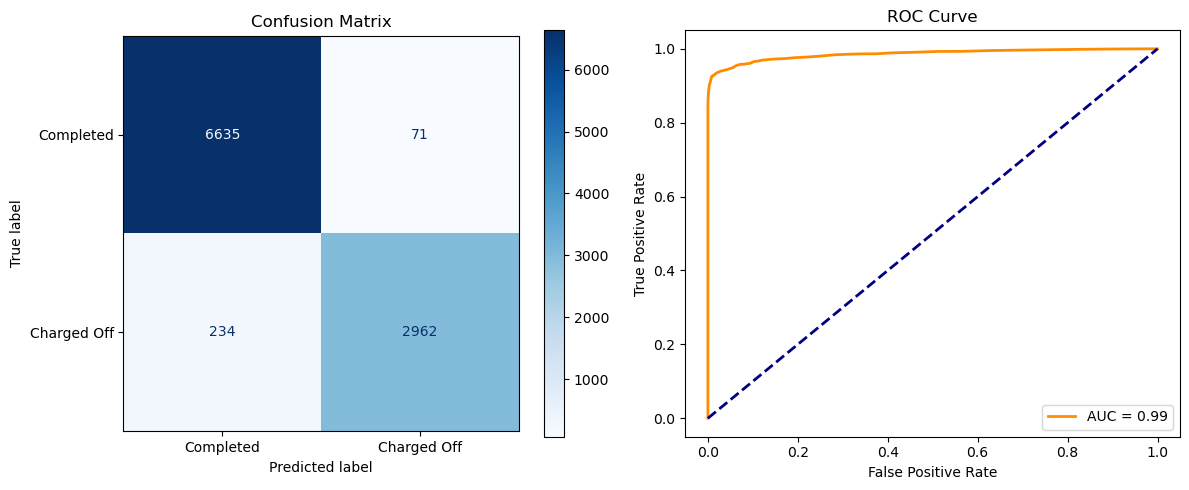

{'Model': 'Under Balanced and Scaled Random Forest',
 'Accuracy Score': 0.97,
 'Precision Score': 0.98,
 'Recall Score': 0.93,
 'AUC Score': 0.96}

In [139]:
# Initialize a Random Forest Classifier with 100 estimators and a random seed of 42
ubs_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Evaluate the Random Forest Classifier on the test set and storing the results
evaluation_ubs_rf_model = evaluate_model(X_train_scaled_under_resampled, 
                                          y_train_scaled_under_resampled, 
                                          X_test_scaled, 
                                          y_test, 
                                          ubs_rf_model, 
                                          'Under Balanced and Scaled Random Forest')

# Display the evaluation results for the Under Balanced and Scaled Random Forest model
evaluation_ubs_rf_model


#### Under Balanced and Scaled Bagging Meta-Estimator (using Decision Trees) 

Model Evaluation Under Balanced and Scaled Bagging Meta-Estimator

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6706
           1       0.96      0.93      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



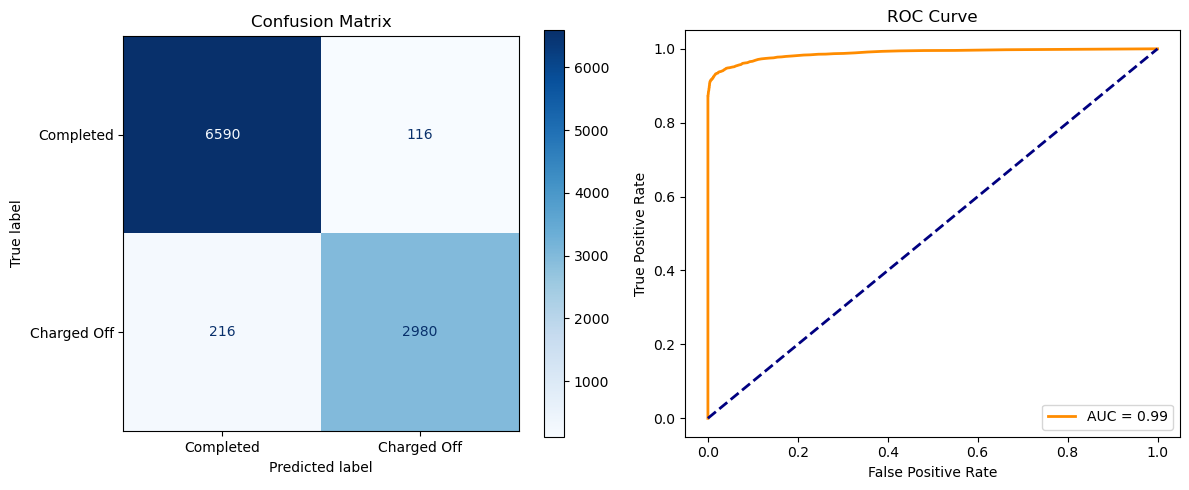

{'Model': 'Under Balanced and Scaled Bagging Meta-Estimator',
 'Accuracy Score': 0.97,
 'Precision Score': 0.96,
 'Recall Score': 0.93,
 'AUC Score': 0.96}

In [140]:
# Creating a Bagging Classifier with a Decision Tree as the base estimator
ubs_bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), 
                                      n_estimators=100, random_state=42)

# Evaluating the Bagging Classifier on the test set and storing the results
evaluation_ubs_bagging_model = evaluate_model(
    X_train_scaled_under_resampled,  # Training features
    y_train_scaled_under_resampled,  # Training labels
    X_test_scaled,  # Test features
    y_test,  # Test labels
    ubs_bagging_model,  # Bagging Classifier model
    'Under Balanced and Scaled Bagging Meta-Estimator'  # Model name for identification
)

# Displaying the evaluation results
evaluation_ubs_bagging_model


### Under Balanced and Scaled Boosting Models 
#### Under Balanced and Scaled XGBoost

Model Evaluation Under Balanced and Scaled XGBoost

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      6706
           1       0.95      0.94      0.95      3196

    accuracy                           0.96      9902
   macro avg       0.96      0.96      0.96      9902
weighted avg       0.96      0.96      0.96      9902



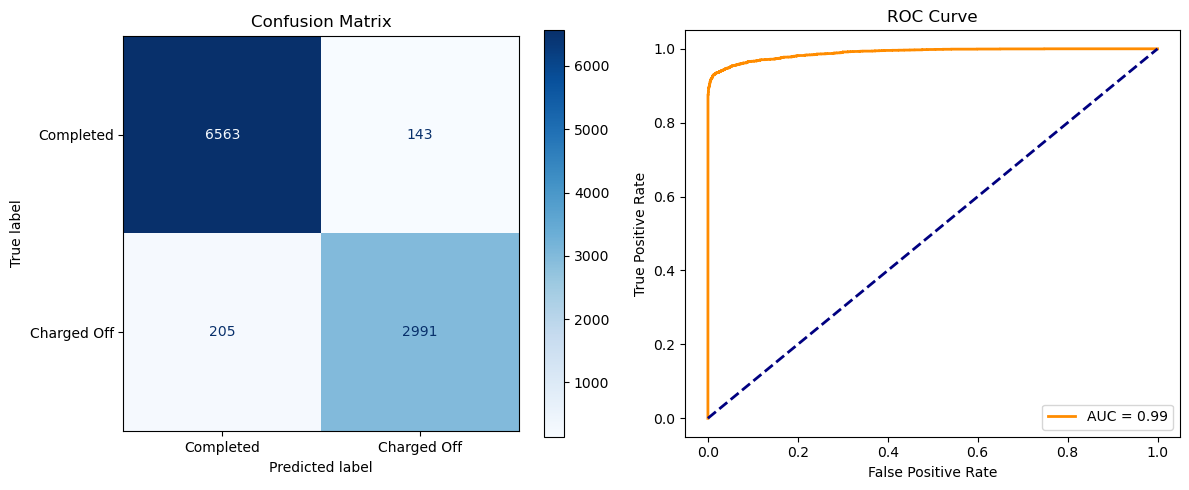

{'Model': 'Under Balanced and Scaled XGBoost',
 'Accuracy Score': 0.96,
 'Precision Score': 0.95,
 'Recall Score': 0.94,
 'AUC Score': 0.96}

In [141]:
# Creating an XGBoost classifier with specified parameters
ubs_xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100,
                                  gamma=0.1, random_state=42)

# Evaluating the XGBoost model on the test set and storing the results
evaluation_ubs_xgb_model = evaluate_model(X_train_scaled_under_resampled, 
                                          y_train_scaled_under_resampled, 
                                          X_test_scaled, y_test, ubs_xgb_model, 
                                          'Under Balanced and Scaled XGBoost')

# Displaying the evaluation metrics for the XGBoost model
evaluation_ubs_xgb_model

#### Under Balanced and Scaled AdaBoost

Model Evaluation Under Balanced and Scaled AdaBoost

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6706
           1       0.98      0.92      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



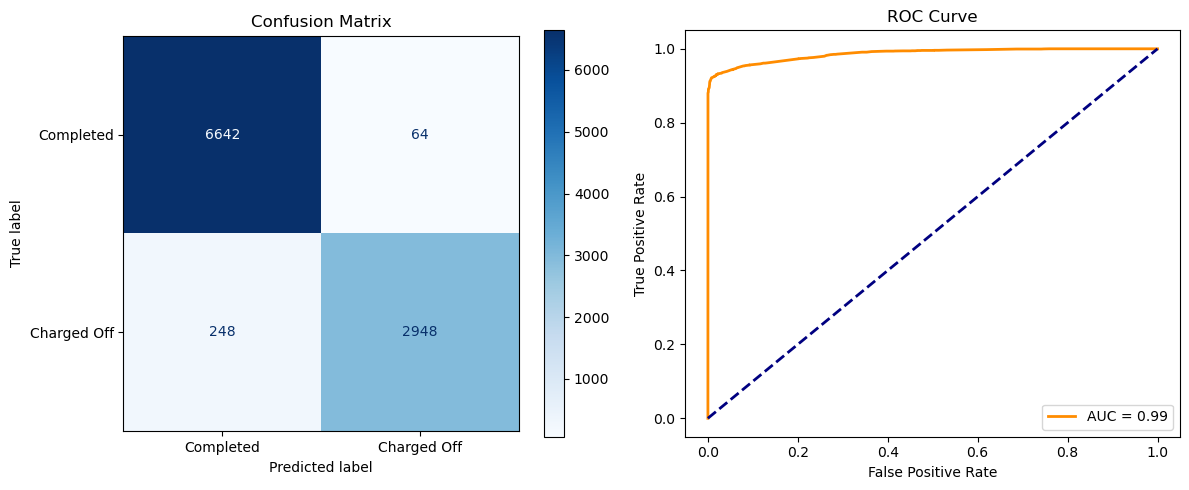

{'Model': 'Under Balanced and Scaled AdaBoost',
 'Accuracy Score': 0.97,
 'Precision Score': 0.98,
 'Recall Score': 0.92,
 'AUC Score': 0.96}

In [142]:
# Creating an AdaBoostClassifier model for UBS with specified hyperparameters
ubs_ada_model = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Evaluating the AdaBoostClassifier model on the test set and storing the results
evaluation_ubs_ada_model = evaluate_model(X_train_scaled_under_resampled, 
                                          y_train_scaled_under_resampled, X_test_scaled, 
                                          y_test, ubs_ada_model, 
                                          'Under Balanced and Scaled AdaBoost')

# Displaying the evaluation results
evaluation_ubs_ada_model

## Experiments Summary


In [143]:
# List of dictionaries containing evaluation metrics for multiple models
evaluation_dicts = [evaluation_ns_dt_model, evaluation_ns_rf_model,
                            evaluation_ns_bagging_model, evaluation_is_rf_model, 
                            evaluation_is_bagging_model, 
                            evaluation_rf_model,evaluation_bagging_model, 
                            evaluation_bs_rf_model, evaluation_bs_bagging_model, 
                            evaluation_un_rf_model, evaluation_un_bagging_model, 
                            evaluation_ubs_rf_model, evaluation_ubs_bagging_model,evaluation_ns_xgb_model, 
                             evaluation_ns_ada_model, evaluation_is_xgb_model, 
                             evaluation_is_ada_model, evaluation_xgb_model, 
                             evaluation_ada_model, evaluation_bs_xgb_model, 
                             evaluation_bs_ada_model, evaluation_un_xgb_model, 
                             evaluation_un_ada_model, evaluation_ubs_xgb_model,
                             evaluation_ubs_ada_model
                    ]


# Convert the list of dictionaries to a DataFrame
evaluation_df = pd.DataFrame(evaluation_dicts)

# Display the DataFrame
evaluation_df

Model  Accuracy Score  \
0   Imbalanced and Non Scaled Decision Trees (Baseline Model)            0.94   
1                     Imbalanced and Non Scaled Random Forest            0.97   
2            Imbalanced and Non Scaled Bagging Decision Trees            0.97   
3                         Imbalanced and Scaled Random Forest            0.97   
4                Imbalanced and Scaled Bagging Meta-Estimator            0.97   
5                   Over Balanced and Non Scaled Random Fores            0.97   
6         Over Balanced and Non Scaled Bagging Meta-Estimator            0.97   
7                      Over Balanced and Scaled Random Forest            0.97   
8             Over Balanced and Scaled Bagging Meta-Estimator            0.97   
9                 Under Balanced and Non Scaled Random Forest            0.97   
10       Under Balanced and Non Scaled Bagging Meta-Estimator            0.97   
11                    Under Balanced and Scaled Random Forest            0.97   
12           Under Balanced and Scaled Bagging Meta-Estimator            0.97   
13                          Imbalanced and Non Scaled XGBoost            0.97   
14                         Imbalanced and Non Scaled AdaBoost            0.96   
15                              Imbalanced and Scaled XGBoost            0.97   
16                             Imbalanced and Scaled AdaBoost            0.96   
17                       Over Balanced and Non Scaled XGBoost            0.97   
18                      Over Balanced and Non Scaled AdaBoost            0.97   
19                           Over Balanced and Scaled XGBoost            0.97   
20                 Over Balanced and Scaled Gradient AdaBoost            0.97   
21                      Under Balanced and Non Scaled XGBoost            0.96   
22                     Under Balanced and Non Scaled AdaBoost            0.97   
23                          Under Balanced and Scaled XGBoost            0.96   
24                         Under Balanced and Scaled AdaBoost            0.97   

    Precision Score  Recall Score  AUC Score  
0              0.90          0.93       0.94  
1              0.99          0.92       0.96  
2              0.98          0.92       0.96  
3              0.99          0.92       0.96  
4              0.98          0.92       0.96  
5              0.98          0.92       0.96  
6              0.98          0.92       0.96  
7              0.98          0.92       0.96  
8              0.98          0.92       0.96  
9              0.97          0.93       0.96  
10             0.96          0.93       0.96  
11             0.98          0.93       0.96  
12             0.96          0.93       0.96  
13             0.98          0.92       0.96  
14             0.99          0.89       0.95  
15             0.98          0.92       0.96  
16             0.99          0.89       0.95  
17             0.98          0.92       0.96  
18             0.98          0.92       0.96  
19             0.98          0.92       0.96  
20             0.98          0.92       0.96  
21             0.95          0.94       0.96  
22             0.98          0.92       0.96  
23             0.95          0.94       0.96  
24             0.98          0.92       0.96

In [144]:
# Assuming 'df' is your DataFrame
evaluation_df.to_csv('evaluation_df.csv', index=False)

### Cross validation

In [145]:
# Perform cross-validation and print the mean accuracy
models = [("Imbalanced and Non Scaled Decision Trees (Baseline Model)", ns_dt_model),
          ("Imbalanced and Non Scaled Random Forest", ns_rf_model),
          ("Imbalanced and Non Scaled Bagging Meta-Estimator", ns_bagging_model),
          ("Imbalanced and Scaled Random Forest", is_rf_model),
          ("Imbalanced and Scaled Bagging Meta-Estimator", is_bagging_model),
          ("Over Balanced and Non Scaled Random Forest", rf_model),
          ("Over Balanced and Non Scaled Bagging Meta-Estimator", bagging_model),
          ("Over Balanced and Scaled Random Forest", bs_rf_model),
          ("Over Balanced and Scaled Bagging Meta-Estimator", bs_bagging_model),
          ("Under Balanced and Non Scaled Random Forest", un_rf_model),
          ("Under Balanced and Non Scaled Bagging Meta-Estimator", un_bagging_model),
          ("Under Balanced and Scaled Random Forest", ubs_rf_model),
          ("Under Balanced and Scaled Bagging Meta-Estimator", ubs_bagging_model),
          ("Imbalanced and Non Scaled XGBoost", ns_xgb_model),
          ("Imbalanced and Non Scaled AdaBoost", ns_ada_model),
          ("Imbalanced and Scaled XGBoost", is_xgb_model),
          ("Imbalanced and Scaled AdaBoost", is_ada_model),
          ("Over Balanced and Non Scaled XGBoost", xgb_model),
          ("Over Balanced and Non Scaled AdaBoost", ada_model),
          ("Over Balanced and Scaled XGBoost", bs_xgb_model),
          ("Over Balanced and Scaled AdaBoost", bs_ada_model),
          ("Under Balanced and Non Scaled XGBoost", un_xgb_model),
          ("Under Balanced and Non Scaled AdaBoost", un_ada_model),
          ("Under Balanced and Scaled XGBoost", ubs_xgb_model),
          ("Under Balanced and Scaled AdaBoost", ubs_ada_model)]

### Define a function for cross validation

In [146]:
def perform_cross_validation(models, X, y, cv):
    # Create an empty list to store dictionaries
    cross_val_list = []

    # Perform cross-validation and print the mean accuracy
    for name, model in models:
        scores = cross_val_score(model, X, y, cv=cv)
        mean_score = round(scores.mean(), 2)
        std_score = round(scores.std(), 4)

        # Append results to the list
        cross_val_list.append({
            "Model": name,
            "Mean Score": mean_score,
            "Standard Deviation": std_score
        })

        print(f"{name} - Mean Score: {mean_score}, Standard Deviation: {std_score}")

    # Create a DataFrame from the list of dictionaries
    cross_val_df = pd.DataFrame(cross_val_list)

    return cross_val_df



In [147]:
cross_val_ten_df = perform_cross_validation(models, X, y, cv=10)

Imbalanced and Non Scaled Decision Trees (Baseline Model) - Mean Score: 0.93, Standard Deviation: 0.0492
Imbalanced and Non Scaled Random Forest - Mean Score: 0.97, Standard Deviation: 0.0022
Imbalanced and Non Scaled Bagging Meta-Estimator - Mean Score: 0.96, Standard Deviation: 0.0074
Imbalanced and Scaled Random Forest - Mean Score: 0.97, Standard Deviation: 0.0022
Imbalanced and Scaled Bagging Meta-Estimator - Mean Score: 0.96, Standard Deviation: 0.0074
Over Balanced and Non Scaled Random Forest - Mean Score: 0.97, Standard Deviation: 0.0022
Over Balanced and Non Scaled Bagging Meta-Estimator - Mean Score: 0.96, Standard Deviation: 0.0074
Over Balanced and Scaled Random Forest - Mean Score: 0.97, Standard Deviation: 0.0022
Over Balanced and Scaled Bagging Meta-Estimator - Mean Score: 0.96, Standard Deviation: 0.0074
Under Balanced and Non Scaled Random Forest - Mean Score: 0.97, Standard Deviation: 0.0022
Under Balanced and Non Scaled Bagging Meta-Estimator - Mean Score: 0.96, Sta

In [148]:
# save to csv
cross_val_ten_df.to_csv('cross_val_ten_df.csv', index=False)

## Hyperparameter Tuning with RandomizedCV 
### Define a function for optimization

In [149]:
def hyperparameter_tuning(model, param_grid, X_train, y_train):
    """
    Perform hyperparameter tuning using RandomizedSearchCV.

    Parameters:
    - model: The machine learning model to be tuned.
    - param_grid: Dictionary with hyperparameter names as keys and lists of hyperparameter settings to try.
    - X_train: Training features.
    - y_train: Training labels.
    - n_iter: Number of parameter settings sampled.
    - cv: Number of cross-validation folds.
    - scoring: Scoring metric for cross-validation.
    - random_state: Seed for reproducibility.

    Returns:
    - Best hyperparameters found by RandomizedSearchCV.
    """

    # Create RandomizedSearchCV object
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        n_iter=5,
        cv=5,
        scoring='roc_auc',
        random_state=42
    )

    # Fit the RandomizedSearchCV object to the data
    random_search.fit(X_train, y_train)

    # Print the best hyperparameters
    print("Best Hyperparameters:", random_search.best_params_)

### Random Forest

In [150]:
# Define parameter grid
rf_param_dist = {
    'n_estimators': [10,20,30,40, 50, 100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30]}

# Create a Random Forest model with a fixed random state
randomizied_model = RandomForestClassifier(random_state=42)

# Perform hyperparameter tuning using the defined function
hyperparameter_tuning(randomizied_model, rf_param_dist, X_train_scaled_under_resampled, y_train_scaled_under_resampled)

Best Hyperparameters: {'n_estimators': 200, 'max_depth': 20}


Model Evaluation Tuned Random Forest

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6706
           1       0.98      0.93      0.95      3196

    accuracy                           0.97      9902
   macro avg       0.97      0.96      0.96      9902
weighted avg       0.97      0.97      0.97      9902



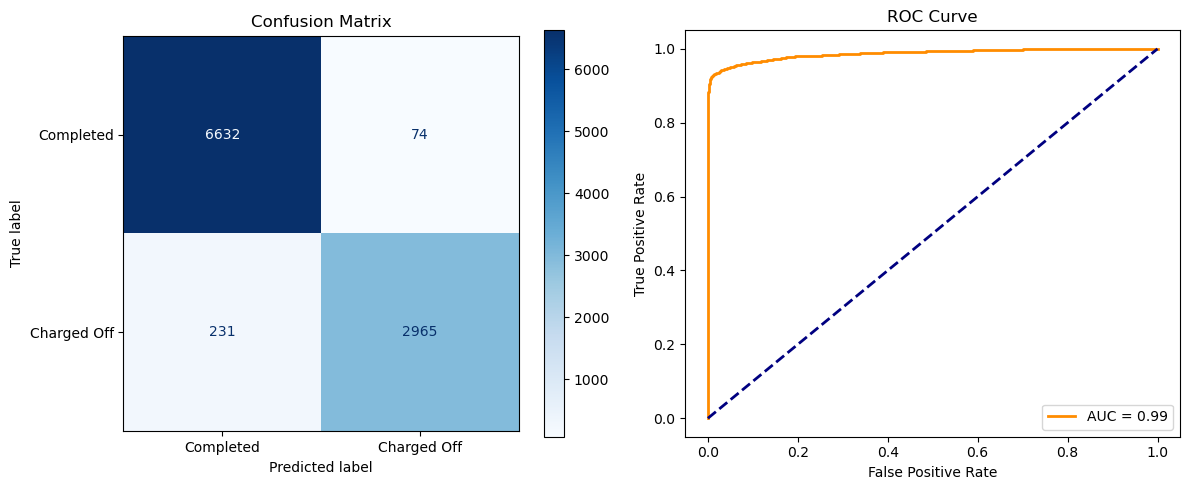

{'Model': 'Tuned Random Forest',
 'Accuracy Score': 0.97,
 'Precision Score': 0.98,
 'Recall Score': 0.93,
 'AUC Score': 0.96}

In [151]:
# Tuned Random Forest Model Instantiation
t_rf_model =  RandomForestClassifier(n_estimators=200, max_depth = 20, random_state=42)

# Evaluation of the Tuned Random Forest Model
evaluation_t_rf_model = evaluate_model(X_train_scaled_under_resampled, y_train_scaled_under_resampled, X_test_scaled, y_test, t_rf_model, 'Tuned Random Forest')

# Display the Evaluation Metrics
evaluation_t_rf_model

## Comparison 
### Undersampled and Scaled Random Forest vs Tuned Random Forest

In [152]:
# List of dictionaries containing evaluation metrics for the two random forest models
comparison_rf_dicts= [evaluation_ubs_rf_model, evaluation_t_rf_model]

# Convert the list of dictionaries to a DataFrame
comparison_rf_df= pd.DataFrame(comparison_rf_dicts)

# Display the DataFrame
comparison_rf_df

Model  Accuracy Score  Precision Score  \
0  Under Balanced and Scaled Random Forest            0.97             0.98   
1                      Tuned Random Forest            0.97             0.98   

   Recall Score  AUC Score  
0          0.93       0.96  
1          0.93       0.96

In [153]:
# save to csv
comparison_rf_df.to_csv('comparison_rf_df.csv', index=False)

### Further Comparision with confusion matrix

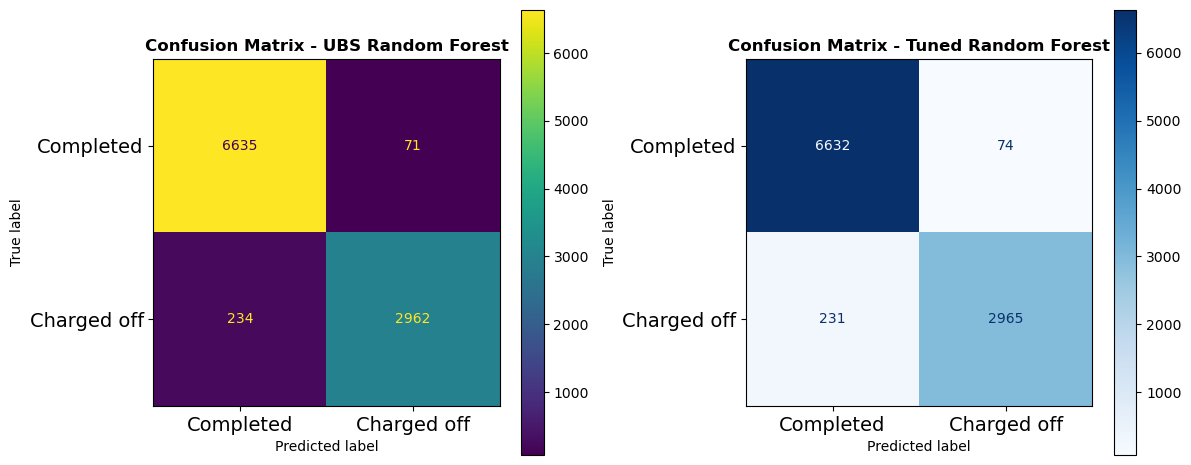

In [154]:
# Make predictions on the test set using both models
ubs_predictions = ubs_rf_model.predict(X_test_scaled)
t_predictions = t_rf_model.predict(X_test_scaled)

# Plot Confusion Matrix
# Generate Confusion Matrices
conf_matrix_ubs = confusion_matrix(y_test, ubs_predictions)
conf_matrix_t = confusion_matrix(y_test, t_predictions)

# Plot Subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Subplot for UBS Random Forest Confusion Matrix
disp_ubs = ConfusionMatrixDisplay(conf_matrix_ubs, display_labels=['Completed', 'Charged off'])
disp_ubs.plot(values_format='d', ax=axes[0])
axes[0].set_title('Confusion Matrix - UBS Random Forest', fontsize=12, fontweight='bold')

# Increase font size for UBS Random Forest subplot
axes[0].tick_params(axis='both', which='both', labelsize=14)

# Subplot for Tuned Random Forest Confusion Matrix
disp_t = ConfusionMatrixDisplay(conf_matrix_t, display_labels=['Completed', 'Charged off'])
disp_t.plot(cmap='Blues', values_format='d', ax=axes[1])
axes[1].set_title('Confusion Matrix - Tuned Random Forest', fontsize=12, fontweight='bold')

# Increase font size for Tuned Random Forest subplot
axes[1].tick_params(axis='both', which='both', labelsize=14)

# Save the plot as an image
plt.savefig('matrix.png')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

# Explainability 
### Random Forest Feature Importance 

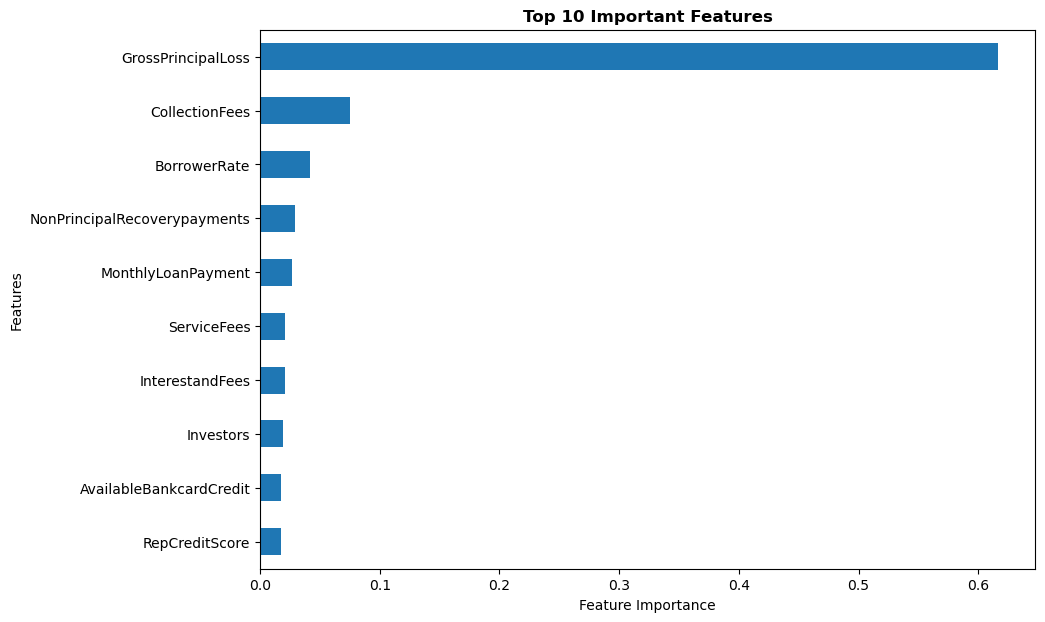

In [155]:
# Feature Importance with Random Forest Model
feat_importances = pd.Series(t_rf_model.feature_importances_, index=X.columns)

# Get the top 10 important features and sort by importance in descending order
top_features = feat_importances.nlargest(10)

# Plot in descending order
top_features[::-1].plot(kind='barh', figsize=(10, 7))
plt.title("Top 10 Important Features", fontsize = 12, fontweight = 'bold')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.savefig('rffeatures.png', dpi=300, bbox_inches='tight')
plt.show()

### Shap

In [156]:
# Train a KernelExplainer
explainer = shap.TreeExplainer(t_rf_model)

In [157]:
# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_test_scaled)

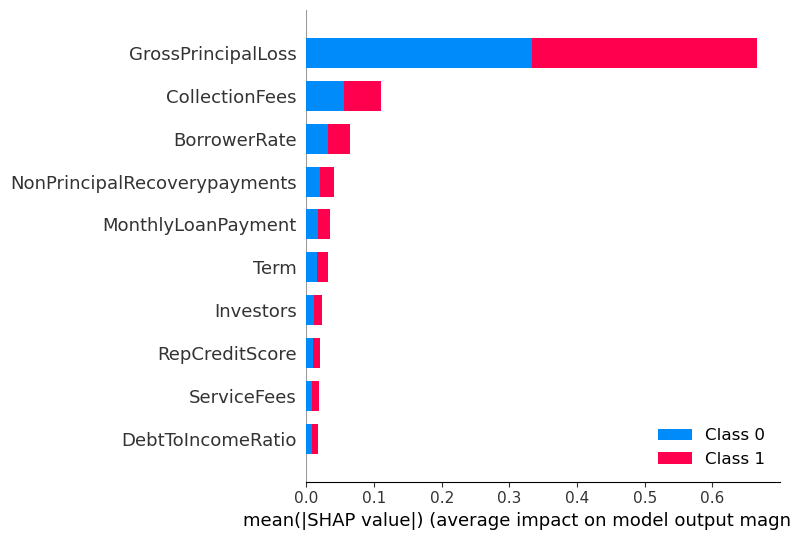

In [158]:
# Create a summary plot using the feature names
# Summary Plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, max_display = 10)


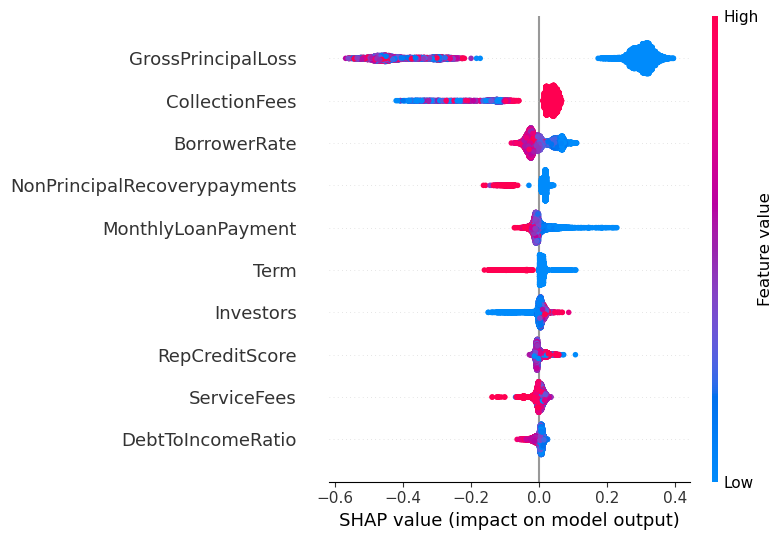

<Figure size 640x480 with 0 Axes>

In [159]:
# Summary Plot
shap_plot_completed = shap.summary_plot(shap_values[0], X_test_scaled, feature_names=X.columns, max_display = 10)

# Save the plot to a file (e.g., PNG format)
plt.savefig('shap_plot_completed.png')
# Display the saved plot
plt.show()

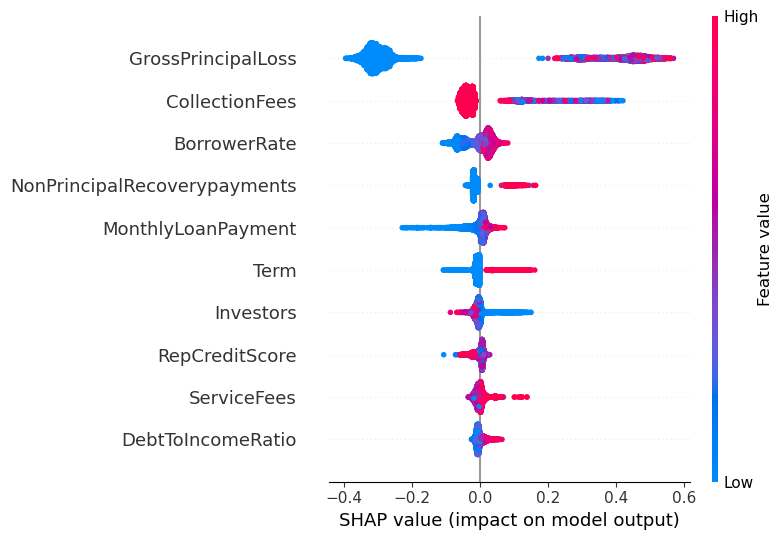

<Figure size 640x480 with 0 Axes>

In [160]:
# Create a summary plot using the feature names
# Summary Plot
shap_plot_chargedoff = shap.summary_plot(shap_values[1], X_test_scaled, feature_names=X.columns, max_display = 10)

# Save the plot to a file (e.g., PNG format)
plt.savefig('shap_plot_chargedoff.png')
# Display the saved plot
plt.show()

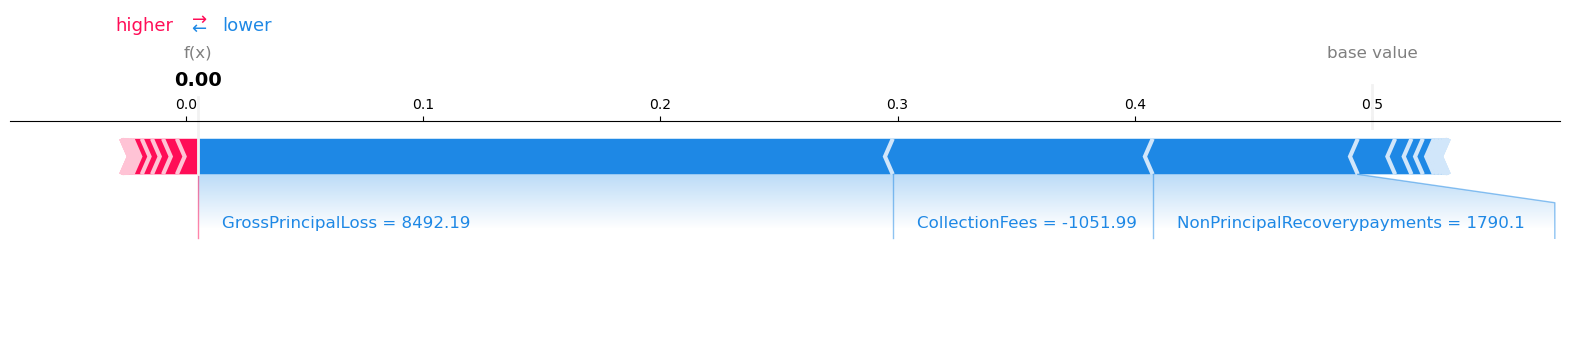

In [161]:
shap.plots.force(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0, :], matplotlib = True)

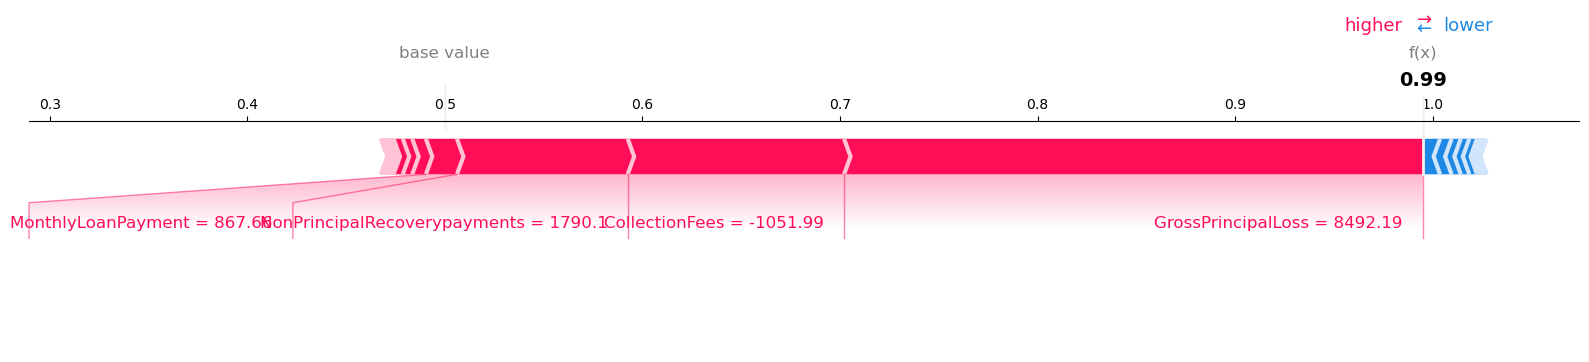

In [162]:
shap.plots.force(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0, :], matplotlib = True)

## Lime

### Local Explanations for Customer with row 92

In [170]:
# Creating a LIME explainer for tabular data
explainer_lime1 = lime.lime_tabular.LimeTabularExplainer(
    X_train_scaled_under_resampled,  # Training data used by LIME explainer
    feature_names=list(X.columns),    # List of feature names
    class_names=["Completed", "Charged off"],  # Class labels for classification
    mode='classification'  # Indicates the mode for classification problems
)

# Generating a LIME explanation for the specified data instance
explanation_lime1 = explainer_lime1.explain_instance(
    data_row=X_test.iloc[92],  # Data instance to explain
    predict_fn=t_rf_model.predict_proba  # Prediction function of the model
)

# Displaying the LIME explanation in a notebook with a table showing feature contributions
explanation_lime1.show_in_notebook(show_table=True)


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels

### Local Explanations for Customer with row 215

In [172]:
# Creating a LIME explainer for tabular data
explainer_lime2 = lime.lime_tabular.LimeTabularExplainer(
    X_train_scaled_under_resampled,  # Training data used by LIME explainer
    feature_names=list(X.columns),    # List of feature names
    class_names=["Completed", "Charged off"],  # Class labels for classification
    mode='classification'  # Indicates the mode for classification problems
)

# Generating a LIME explanation for the specified data instance
explanation_lime2 = explainer_lime2.explain_instance(
    data_row=X_test.iloc[215],  # Data instance to explain
    predict_fn=t_rf_model.predict_proba  # Prediction function of the model
)

# Displaying the LIME explanation in a notebook with a table showing feature contributions
explanation_lime2.show_in_notebook(show_table=True)


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels

### Local Explanations for Customer with row 1

In [173]:
# Creating a LIME explainer for tabular data
explainer_lime3 = lime.lime_tabular.LimeTabularExplainer(
    X_train_scaled_under_resampled,  # Training data used by LIME explainer
    feature_names=list(X.columns),    # List of feature names
    class_names=["Completed", "Charged off"],  # Class labels for classification
    mode='classification'  # Indicates the mode for classification problems
)

# Generating a LIME explanation for the specified data instance
explanation_lime3 = explainer_lime3.explain_instance(
    data_row=X_test.iloc[1],  # Data instance to explain
    predict_fn=t_rf_model.predict_proba  # Prediction function of the model
)

# Displaying the LIME explanation in a notebook with a table showing feature contributions
explanation_lime3.show_in_notebook(show_table=True)


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels